In [1]:
import os
import re
import sys

import numpy as np
import pandas as pd

import pytorch_lightning as pl
import scanpy as sc

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.lines import Line2D
import seaborn as sns
import textwrap

import gseapy as gp

pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis._utils import aggregate_cell_counts, calculate_DxC_effect, calculate_DxC_gene_effect, find_trans_fSNPs
from src.analysis.plotting import plot_ct_gex_vs_gt, plot_gene_loadings_for_factor, venny4py_custom_colors

Seed set to 32
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 32


In [2]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")
adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downregulated_NK', '

In [3]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)
gene_anno

gene_start gene_chromosome   gene_end      gene_name
Gene stable ID                                                       
ENSG00000000419    49551404              20   49575092           DPM1
ENSG00000000457   169818772               1  169863408          SCYL3
ENSG00000000460   169631245               1  169823221       C1orf112
ENSG00000000938    27938575               1   27961788            FGR
ENSG00000000971   196621008               1  196716634            CFH
...                     ...             ...        ...            ...
ENSG00000273269    47293080               2   47403650   RP11-761B3.1
ENSG00000273274    32930670               1   32962287         ZBTB8B
ENSG00000273294    33987279               5   34124633  RP11-1084J3.4
ENSG00000273331   196042953               3  196065244        TM4SF19
ENSG00000273398    68358370               2   68488362  RP11-474G23.1

[14212 rows x 4 columns]

In [4]:
adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)
adata.var = adata.var.assign(upstream_5MB = adata.var.apply(lambda x: max(0, x.gene_start - 5000000), axis=1),
                             downstream_5MB = adata.var.apply(lambda x: x.gene_end + 5000000, axis=1))

In [5]:
# COLORS FROM THE ORIGINAL PUBLICATION
cell_label_colors = {
    "CD4 SOX4": "#D6C1DE", # SOX4+ CD4 T cells
    "CD4 NC": "#882E72", # CD4 naive T cells
    "CD4 ET": "#B178A6", # CD4 effector T cells
    "CD8 NC": "#5289C7", # CD8 naive T cells
    "CD8 S100B": "#7BAFDE", # S100B+ CD8 cells
    "CD8 ET": "#1965B0", # CD8 effector cells 
    "NK": "#4EB265",
    "NK R": "#90C987", # NK recruiting cells
    "B IN": "#F6C141",
    "B Mem": "#F7EE55",
    "Mono C": "#F1932D", # classical monocytes
    "Mono NC": "#E8601C", # non-classical monocytes
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

# matching colros for major (L1) celltype
major_celltype_colors = {
    "CD4T": "darkmagenta",
    "CD8T": "steelblue", 
    "NK": "mediumseagreen",
    "B": "gold",
    "Mono": "orange",
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

In [6]:
background_genes = adata.var.GeneSymbol
# databases_bio = ["GO_Biological_Process_2023", "Elsevier_Pathway_Collection",  "GO_Molecular_Function_2023", "KEGG_2021_Human", "Reactome_2022"] 
databases_bio = ["GO_Biological_Process_2023", "GO_Molecular_Function_2023", "KEGG_2021_Human", "Reactome_2022"] 

In [46]:
cis_eQTLGen_hvgs = pd.read_csv("/data/danai/Data/eQTLGen_cis-eQTLs_trans-eQTLGen-disease-associated-SNPs_OneK1K-10K-HVG-HEX.tsv", sep="\t")

In [47]:
trans_eQTLGen_sign = pd.read_csv("/data/danai/Data/OneK1K/trans-eQTLGen-FDR005_OneK1K.tsv", sep="\t")
trans_eQTLGen_sign = trans_eQTLGen_sign.assign(snp_id = [i[0]+":"+i[1] for i in trans_eQTLGen_sign.SNP_id1.str.split("_")])
trans_eQTLGen_sign = trans_eQTLGen_sign.assign(QTL = trans_eQTLGen_sign.apply(lambda x: x.Gene+"-"+x.snp_id, axis=1))
trans_eQTLGen_sign.head()

Pvalue        SNP  SNPChr    SNPPos AssessedAllele OtherAllele  \
0  1.128895e-308  rs1354034       3  56849749              T           C   
1  1.128895e-308  rs1354034       3  56849749              T           C   
2  1.128895e-308  rs1354034       3  56849749              T           C   
3  1.128895e-308  rs1354034       3  56849749              T           C   
4  1.128895e-308  rs1354034       3  56849749              T           C   

    Zscore             Gene GeneSymbol GeneChr    GenePos  NrCohorts  \
0 -57.2518  ENSG00000163736       PPBP       4   74853334         37   
1 -50.8175  ENSG00000198478   SH3BGRL2       6   80377186         37   
2 -50.6486  ENSG00000005961     ITGA2B      17   42458210         36   
3 -49.9996  ENSG00000122786      CALD1       7  134542241         36   
4 -45.3023  ENSG00000166091      CMTM5      14   23847499         37   

   NrSamples  FDR    BonferroniP         SNP_id1         SNP_id2      snp_id  \
0      31684  0.0  6.659500e-302  3_56849749_T_C  3_56849749_C_T  3:56849749   
1      31684  0.0  6.659500e-302  3_56849749_T_C  3_56849749_C_T  3:56849749   
2      31470  0.0  6.659500e-302  3_56849749_T_C  3_56849749_C_T  3:56849749   
3      31644  0.0  6.659500e-302  3_56849749_T_C  3_56849749_C_T  3:56849749   
4      31684  0.0  6.659500e-302  3_56849749_T_C  3_56849749_C_T  3:56849749   

                          QTL  
0  ENSG00000163736-3:56849749  
1  ENSG00000198478-3:56849749  
2  ENSG00000005961-3:56849749  
3  ENSG00000122786-3:56849749  
4  ENSG00000166091-3:56849749

In [7]:
GT_matrix = pd.read_csv("/data/danai/Data/OneK1K/GT_matrix_trans-eQTLGen_in_OneK1K.tsv", sep="\t", index_col=0)
GT_matrix

1_1  2_2  3_3  4_4  6_6  7_7  8_8  9_9  10_10  11_11  ...  \
SNP_id                                                                 ...   
1_1247494_C_T    2.0  2.0  2.0  2.0  2.0  2.0  1.0  1.0    2.0    2.0  ...   
1_1894284_T_C    2.0  2.0  1.0  1.0  1.0  1.0  2.0  1.0    2.0    2.0  ...   
1_2069172_C_T    2.0  2.0  1.0  2.0  1.0  0.0  0.0  0.0    1.0    2.0  ...   
1_2146165_C_A    2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0    2.0    2.0  ...   
1_2233961_G_A    1.0  1.0  2.0  2.0  2.0  2.0  1.0  2.0    2.0    1.0  ...   
...              ...  ...  ...  ...  ...  ...  ...  ...    ...    ...  ...   
22_50971752_C_A  1.0  2.0  1.0  1.0  2.0  1.0  1.0  2.0    2.0    2.0  ...   
22_50991033_T_C  1.0  2.0  1.0  1.0  1.0  1.0  1.0  2.0    1.0    2.0  ...   
22_51063477_T_C  2.0  2.0  2.0  2.0  2.0  1.0  1.0  2.0    2.0    2.0  ...   
22_51101938_A_C  2.0  2.0  2.0  1.0  2.0  1.0  2.0  1.0    2.0    1.0  ...   
22_51106979_G_C  1.0  0.0  2.0  1.0  1.0  2.0  2.0  2.0    0.0    1.0  ...   

                 1079_1080  1080_1081  1081_1082  1083_1084  1084_1085  \
SNP_id                                                                   
1_1247494_C_T          2.0        2.0        1.0        2.0        1.0   
1_1894284_T_C          2.0        1.0        1.0        2.0        1.0   
1_2069172_C_T          1.0        1.0        1.0        1.0        1.0   
1_2146165_C_A          1.0        2.0        2.0        2.0        2.0   
1_2233961_G_A          2.0        1.0        2.0        2.0        0.0   
...                    ...        ...        ...        ...        ...   
22_50971752_C_A        2.0        0.0        2.0        1.0        2.0   
22_50991033_T_C        0.0        1.0        2.0        1.0        2.0   
22_51063477_T_C        2.0        1.0        2.0        2.0        2.0   
22_51101938_A_C        2.0        2.0        2.0        2.0        1.0   
22_51106979_G_C        0.0        2.0        1.0        0.0        0.0   

                 1096_845_2  1100_914_2  1102_932_2  1103_926_2  1104_920_2  
SNP_id                                                                       
1_1247494_C_T           2.0         1.0         2.0         2.0         1.0  
1_1894284_T_C           2.0         2.0         2.0         0.0         1.0  
1_2069172_C_T           0.0         2.0         1.0         2.0         2.0  
1_2146165_C_A           2.0         1.0         2.0         2.0         2.0  
1_2233961_G_A           2.0         2.0         2.0         2.0         2.0  
...                     ...         ...         ...         ...         ...  
22_50971752_C_A         2.0         1.0         1.0         1.0         2.0  
22_50991033_T_C         2.0         1.0         1.0         0.0         2.0  
22_51063477_T_C         2.0         1.0         2.0         2.0         2.0  
22_51101938_A_C         1.0         2.0         1.0         2.0         2.0  
22_51106979_G_C         1.0         1.0         1.0         1.0         2.0  

[9305 rows x 1034 columns]

In [8]:
hg_mapping = pd.read_csv("/data/danai/Data/OneK1K/trans-eQTL-Gen_liftOver_results.tsv", sep="\t")
hg_mapping

SNP_id_hg38  SNP_id_hg19
0       1:1312114    1:1247494
1       1:1962845    1:1894284
2       1:2137733    1:2069172
3       1:2214726    1:2146165
4       1:2302522    1:2233961
...           ...          ...
9299  22:50533323  22:50971266
9300  22:50552604  22:50971752
9301  22:50625049  22:50991033
9302  22:50663510  22:51063477
9303  22:50668551  22:51101938

[9304 rows x 2 columns]

In [9]:
rsids = pd.read_csv("/data/danai/Data/OneK1K/ALL_chroms.dose.filtered.R2_0.8_001MAF_HWE_trans-eQTLGen_rsIDs.bim",
                    sep="\t", index_col=False, names=["chr", "rsID", "bla", "position", "a0", "a1"])
rsids = rsids.assign(SNP_id_hg19 = rsids.chr.astype(str) + ":" + rsids.position.astype(str))
rsids

chr         rsID  bla  position a0 a1  SNP_id_hg19
0       1    1:1247494    0   1247494  T  C    1:1247494
1       1    rs4648739    0   1894284  C  T    1:1894284
2       1     rs425277    0   2069172  T  C    1:2069172
3       1   rs78265569    0   2146165  A  C    1:2146165
4       1   rs11576356    0   2233961  A  G    1:2233961
...   ...          ...  ...       ... .. ..          ...
9300   22  22:50971752    0  50971752  A  C  22:50971752
9301   22  22:50991033    0  50991033  C  T  22:50991033
9302   22    rs6151429    0  51063477  C  T  22:51063477
9303   22    rs6010044    0  51101938  C  A  22:51101938
9304   22    rs9616907    0  51106979  C  G  22:51106979

[9305 rows x 7 columns]

In [10]:
snp_mapping = hg_mapping.merge(rsids.filter(["SNP_id_hg19", "rsID", "a0", "a1"]), how="left", on="SNP_id_hg19")
snp_mapping = snp_mapping.drop_duplicates()
snp_mapping.shape

(9310, 5)

In [11]:
SNP_dict = dict(zip(GT_matrix.index, [i[0]+":"+i[1] for i in GT_matrix.index.str.split("_")]))
SNP_dict_inv = {v:k for k,v in SNP_dict.items()}

In [12]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)

True

In [13]:
sc.settings.figdir = os.path.join(model_results_dir, "Figures")

In [14]:
GxC_effects = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_LMM_results_BH-0.05_Ucontext.tsv"),
    sep="\t"
)
GxC_effects.Factor = GxC_effects.Factor.str.replace("U_", "D_")
GxC_effects.SNP_id.nunique()

941

In [15]:
GxC_effects[["SNP_chrom", "SNP_pos"]] = GxC_effects.SNP_id.str.split(":", expand=True)
GxC_effects.SNP_chrom = GxC_effects.SNP_chrom.astype(int)
GxC_effects.SNP_pos = GxC_effects.SNP_pos.astype(np.int64)

GxC_effects = GxC_effects.assign(fQTL = GxC_effects["SNP_id"]+"__"+GxC_effects["Factor"])

In [16]:
DxC_decoder = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_GxC_decoder.tsv"),
    sep="\t", index_col=0
)
DxC_decoder.columns = DxC_decoder.columns.str.replace("GxC", "DxC")
DxC_decoder.head()

DxC_Factor1  DxC_Factor2  DxC_Factor3  DxC_Factor4  \
Geneid                                                                
ENSG00000257019     0.000003    -0.000156     0.000261    -0.000105   
ENSG00000166987    -0.000101    -0.000302     0.000002    -0.000025   
ENSG00000170624    -0.000007    -0.000096    -0.000228     0.000753   
ENSG00000140519     0.000013    -0.000071     0.000062    -0.000007   
ENSG00000117115    -0.000463    -0.000236     0.000113    -0.000527   

                 DxC_Factor5  DxC_Factor6  DxC_Factor7  DxC_Factor8  \
Geneid                                                                
ENSG00000257019     0.000109    -0.000148     0.000145     0.000002   
ENSG00000166987     0.000096    -0.000122     0.000290    -0.000218   
ENSG00000170624    -0.000033    -0.000042    -0.000032     0.001457   
ENSG00000140519    -0.000070     0.000082    -0.000036     0.000126   
ENSG00000117115     0.000036     0.000147    -0.000130    -0.000716   

                 DxC_Factor9  DxC_Factor10  ...  DxC_Factor691  DxC_Factor692  \
Geneid                                      ...                                 
ENSG00000257019     0.000106     -0.000083  ...      -0.000125      -0.000088   
ENSG00000166987    -0.000033      0.000128  ...      -0.000093      -0.000059   
ENSG00000170624     0.000291     -0.000079  ...      -0.000690       0.000181   
ENSG00000140519    -0.000059     -0.000021  ...       0.000164       0.000251   
ENSG00000117115    -0.000064      0.000002  ...       0.000046       0.000210   

                 DxC_Factor693  DxC_Factor694  DxC_Factor695  DxC_Factor696  \
Geneid                                                                        
ENSG00000257019       0.000062      -0.000037      -0.000043      -0.000013   
ENSG00000166987      -0.000712       0.000007      -0.000217       0.000056   
ENSG00000170624      -0.004836       0.000014      -0.000040       0.000021   
ENSG00000140519      -0.000099       0.000035      -0.000080      -0.000019   
ENSG00000117115       0.000123      -0.000185      -0.000235       0.000060   

                 DxC_Factor697  DxC_Factor698  DxC_Factor699  DxC_Factor700  
Geneid                                                                       
ENSG00000257019      -0.000199      -0.000141       0.000042       0.000049  
ENSG00000166987       0.000027       0.000117      -0.000141       0.000014  
ENSG00000170624       0.000080       0.000070      -0.000669      -0.000014  
ENSG00000140519      -0.000139       0.000042      -0.000011      -0.000129  
ENSG00000117115      -0.000145       0.000712      -0.000128      -0.000025  

[5 rows x 700 columns]

In [17]:
D = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_U_embedding.tsv"),
    sep="\t", index_col=0
)
D.columns = D.columns.str.replace("U_", "D_")
D.head()

D_Factor1  D_Factor2  D_Factor3  D_Factor4  D_Factor5  D_Factor6  \
individual                                                                     
691_692     -1.042473  -3.014132   1.014801   1.139763  -0.087979  -0.651705   
693_694      0.204075  -1.975144  -0.909941  -3.882647  -2.031409  -1.043576   
688_689     -0.265995  -0.624907  -0.622831  -2.176815   0.853737  -0.117719   
683_684      0.416159  -2.862958  -0.515983   1.572177   0.868042  -0.119366   
684_685     -1.244226  -4.169203  -0.287462  -0.519455   3.750650  -1.336222   

            D_Factor7  D_Factor8  D_Factor9  D_Factor10  ...  D_Factor691  \
individual                                               ...                
691_692      0.490216  -0.437837  -0.698968   -0.075018  ...    -1.559727   
693_694     -0.600040   0.700274  -1.798226    1.284830  ...    -4.333742   
688_689      0.055314   0.302469   0.608836   -1.786304  ...    -0.670751   
683_684     -0.109651   0.556453   1.886532   -1.681124  ...    -2.243293   
684_685      0.230874  -0.624908   1.064494    0.636243  ...     0.699778   

            D_Factor692  D_Factor693  D_Factor694  D_Factor695  D_Factor696  \
individual                                                                    
691_692       -2.399024    -0.448335    -0.562907     1.627759     0.417358   
693_694       -0.440545     3.113877    -1.716786    -1.533546     0.933507   
688_689       -1.207303     8.913930    -0.353388    -0.325745    -1.125641   
683_684       -1.778274     0.387456     0.630929    -0.590417     0.165828   
684_685       -3.021685    -0.273128    -0.655736    -0.635290     0.228497   

            D_Factor697  D_Factor698  D_Factor699  D_Factor700  
individual                                                      
691_692       -0.134628     0.011702    -0.679321     0.457391  
693_694        1.020350     0.339764    -1.053410     0.119764  
688_689        0.403694    -0.928585     0.525144    -0.484701  
683_684       -2.937147     0.222008    -0.201923     0.057328  
684_685        1.079147    -1.051518     0.797644     0.003049  

[5 rows x 700 columns]

In [18]:
assignment_matrix = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_factor_assignment_matrix.tsv"),
    sep="\t", index_col=0
)
assignment_matrix.columns = assignment_matrix.columns.str.replace("U_", "D_")

In [19]:
cell_state = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_cell-state_latent.tsv"),
    sep="\t", index_col=0
)

In [20]:
umap_cc = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_cell-state_latent_UMAP.tsv"),
    sep="\t", index_col=0
)

In [39]:
adata.obsm["X_umap"] = umap_cc.loc[adata.obs.index].to_numpy()

In [21]:
sc.settings._vector_friendly = True

In [43]:
trans_fSNPs_all = find_trans_fSNPs(DxC_effects=GxC_effects, DxC_decoder=DxC_decoder, adata=adata)
trans_fSNPs_all.SNP_id.nunique()

480

In [24]:
tensorqtl_results = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/All_celltypes_results_tensorQTL_significant_BH_005.tsv", sep="\t")
tensorqtl_results.head()

SNP_id             gene       p_value  effect_size  effect_size_se  \
0   1:3091587  ENSG00000129691  1.626467e-07     0.379141        0.071849   
1   1:4193551  ENSG00000226209  2.383485e-08     0.137090        0.024354   
2   1:4668670  ENSG00000184925  2.701358e-07     0.250460        0.048347   
3  1:11171226  ENSG00000270800  2.312485e-08     0.116015        0.020590   
4  1:11280994  ENSG00000270800  2.312485e-08     0.116015        0.020590   

  ref_allele alt_allele celltype  Storey_q  BH_corrected_pvalue  \
0          C          T   CD4-ET  0.016391             0.016391   
1          G          A   CD4-ET  0.003805             0.003805   
2          G          A   CD4-ET  0.023879             0.023879   
3          C          T   CD4-ET  0.003718             0.003718   
4          T          C   CD4-ET  0.003718             0.003718   

   BY_corrected_pvalue  
0             0.357406  
1             0.082976  
2             0.520671  
3             0.081068  
4             0.081068

In [25]:
effects_LIVI_not_tensor = GxC_effects.loc[~GxC_effects.SNP_id.isin(tensorqtl_results.SNP_id)]

In [22]:
trans_fSNPs = pd.read_csv(
    os.path.join(model_results_dir, "trans-fSNPs_only-LIVI.tsv"), sep="\t"
)
trans_fSNPs.SNP_id.nunique()

294

In [26]:
# Rename SNPs for plotting
GxC_effects = GxC_effects.assign(SNP = GxC_effects.SNP_id)
GxC_effects = GxC_effects.assign(SNP_id = GxC_effects.SNP.map(SNP_dict_inv))
GxC_effects.head()

Factor           SNP_id  effect_size  effect_size_se       p_value  \
0   D_Factor1  14_81884515_G_A     0.128089        0.029964  1.747683e-05   
1   D_Factor5  19_58963530_G_A     0.585091        0.071890  1.218412e-16   
2  D_Factor11  6_161111700_C_T     1.012741        0.201583  4.265749e-07   
3  D_Factor12   3_39555580_A_G     0.505091        0.055674  1.831975e-20   
4  D_Factor14  2_232579379_G_A    -0.201663        0.025578  1.112895e-15   

  assessed_allele  corrected_pvalue  SNP_chrom    SNP_pos  \
0               G      3.124271e-02         14   81884515   
1               G      8.928493e-13         19   58963530   
2               C      1.083497e-03          6  161111700   
3               A      1.759641e-16          3   39555580   
4               G      7.537058e-12          2  232579379   

                      fQTL          SNP  
0   14:81884515__D_Factor1  14:81884515  
1   19:58963530__D_Factor5  19:58963530  
2  6:161111700__D_Factor11  6:161111700  
3   3:39555580__D_Factor12   3:39555580  
4  2:232579379__D_Factor14  2:232579379

## Novel trans-eQTLs in continuous cell-states (e.g. differentiating B or T cells)

In [23]:
# Factors active in myeloid cells
myeloid_factors = assignment_matrix.filter(trans_fSNPs.Factor).loc["Cell-state_Factor6"][assignment_matrix.filter(trans_fSNPs.Factor).loc["Cell-state_Factor6"] > 0.9].index.tolist()
myeloid_factors

['D_Factor68',
 'D_Factor123',
 'D_Factor159',
 'D_Factor162',
 'D_Factor185',
 'D_Factor214',
 'D_Factor256',
 'D_Factor318',
 'D_Factor385',
 'D_Factor566',
 'D_Factor570',
 'D_Factor675']

In [60]:
len(myeloid_factors)

12

In [24]:
# Factors active in B cells
Bcell_factors = assignment_matrix.filter(trans_fSNPs.Factor).loc["Cell-state_Factor7"][assignment_matrix.filter(trans_fSNPs.Factor).loc["Cell-state_Factor7"] > 0.9].index.tolist()
Bcell_factors

['D_Factor19',
 'D_Factor132',
 'D_Factor136',
 'D_Factor152',
 'D_Factor210',
 'D_Factor231',
 'D_Factor266',
 'D_Factor275',
 'D_Factor285',
 'D_Factor293',
 'D_Factor297',
 'D_Factor348',
 'D_Factor376',
 'D_Factor465',
 'D_Factor497',
 'D_Factor503',
 'D_Factor512',
 'D_Factor552',
 'D_Factor566',
 'D_Factor586',
 'D_Factor621',
 'D_Factor634']

In [61]:
len(Bcell_factors)

22

In [65]:
# Factors active in CD4 T cells
cd4T_factors = assignment_matrix.filter(trans_fSNPs.Factor).loc["Cell-state_Factor5"][assignment_matrix.filter(trans_fSNPs.Factor).loc["Cell-state_Factor5"] > 0.9].index.tolist()
cd4T_factors

['D_Factor140',
 'D_Factor152',
 'D_Factor220',
 'D_Factor242',
 'D_Factor287',
 'D_Factor310',
 'D_Factor318',
 'D_Factor470',
 'D_Factor564',
 'D_Factor598']

In [63]:
len(cd4T_factors)

10

In [26]:
# Factors active in CD8 T cells
cd8T_factors = assignment_matrix.filter(trans_fSNPs.Factor).loc["Cell-state_Factor11"][assignment_matrix.filter(trans_fSNPs.Factor).loc["Cell-state_Factor11"] > 0.9].index.tolist()
cd8T_factors

['D_Factor25',
 'D_Factor58',
 'D_Factor61',
 'D_Factor182',
 'D_Factor318',
 'D_Factor412',
 'D_Factor439',
 'D_Factor452',
 'D_Factor471',
 'D_Factor486',
 'D_Factor523',
 'D_Factor628',
 'D_Factor638']

In [62]:
len(cd8T_factors)

13

In [27]:
GxC_effects.loc[GxC_effects.Factor.isin(myeloid_factors+Bcell_factors+cd4T_factors)].SNP_id.nunique()

403

In [28]:
GxC_effects.loc[GxC_effects.Factor.isin(myeloid_factors+Bcell_factors+cd4T_factors+cd8T_factors)].SNP_id.nunique()

424

In [38]:
(424/941)*100

45.05844845908608

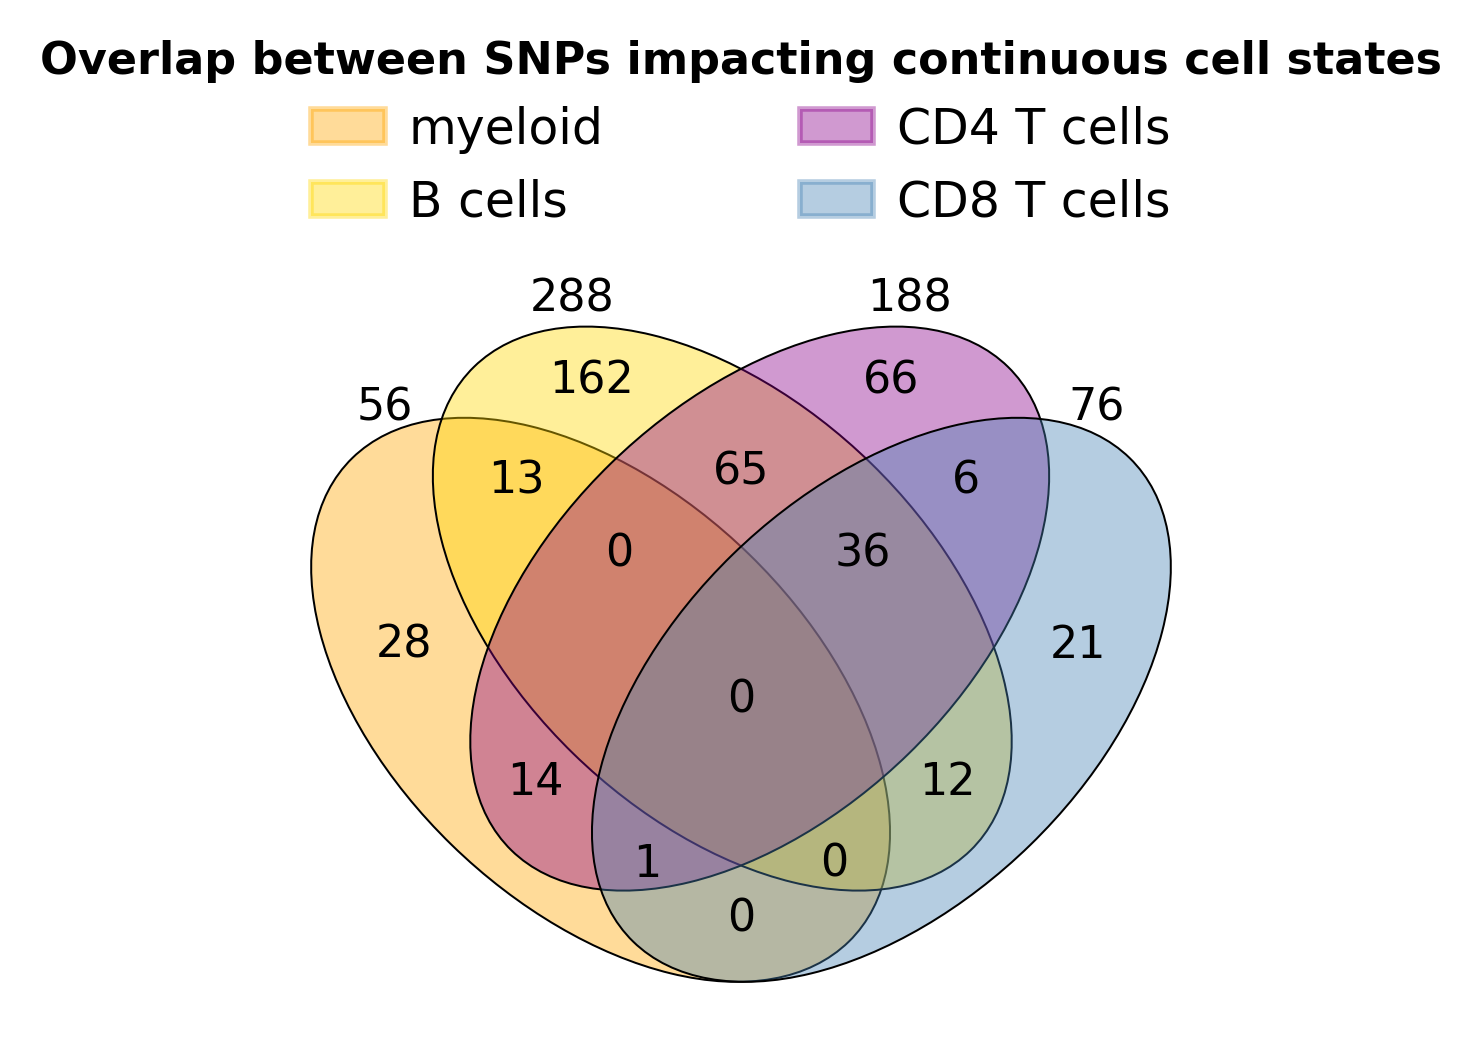

In [47]:
venny4py_custom_colors(sets={"myeloid": set(GxC_effects.loc[GxC_effects.Factor.isin(myeloid_factors)].SNP_id.unique()),
                             "B cells": set(GxC_effects.loc[GxC_effects.Factor.isin(Bcell_factors)].SNP_id.unique()),
                             "CD4 T cells":set(GxC_effects.loc[GxC_effects.Factor.isin(cd4T_factors)].SNP_id.unique()),
                             "CD8 T cells":set(GxC_effects.loc[GxC_effects.Factor.isin(cd8T_factors)].SNP_id.unique()),  }, 
                       custom_colors=[major_celltype_colors["Mono"], major_celltype_colors["B"], major_celltype_colors["CD4T"], major_celltype_colors["CD8T"]], 
                       plot_title="Overlap between SNPs impacting continuous cell states",
                       out=os.path.join(model_results_dir, "Figures", "SNP-Overlap_continuous-cell-states"),
                       alpha=0.4,
                       fontsize=8,
                       size=3,
                       ext="png")

In [51]:
effects_LIVI_not_tensor.loc[effects_LIVI_not_tensor.Factor.isin(myeloid_factors+Bcell_factors+cd4T_factors+cd8T_factors)].SNP_id.nunique()

285

In [53]:
(285/effects_LIVI_not_tensor.SNP_id.nunique())*100

47.18543046357616

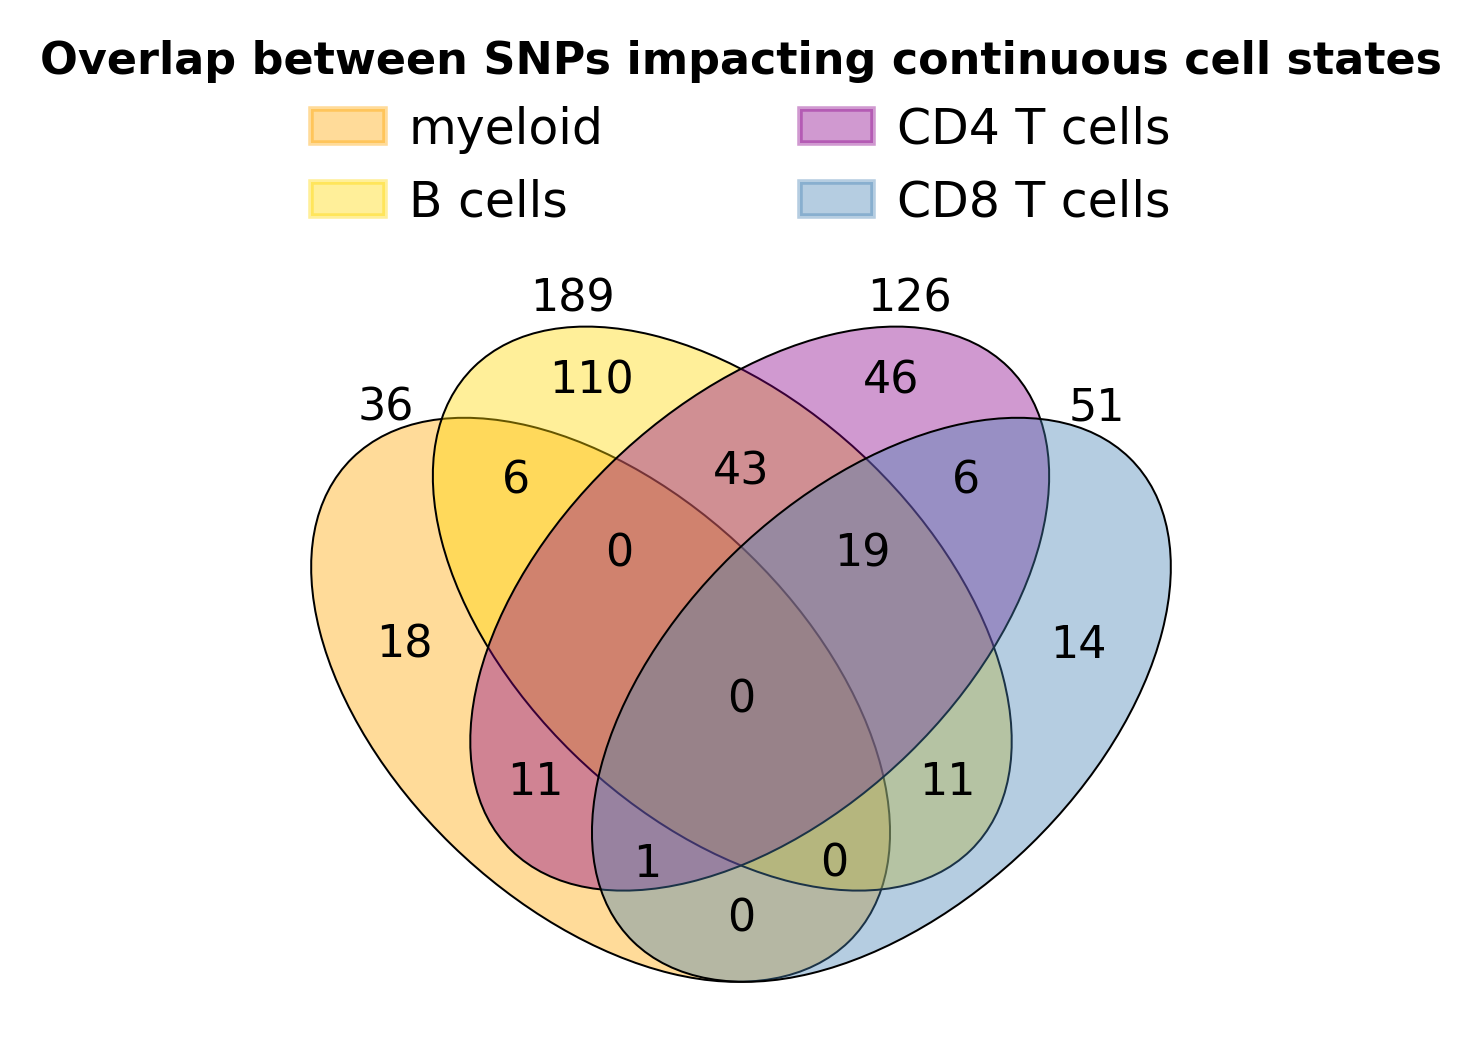

In [59]:
venny4py_custom_colors(sets={"myeloid": set(effects_LIVI_not_tensor.loc[effects_LIVI_not_tensor.Factor.isin(myeloid_factors)].SNP_id.unique()),
                             "B cells": set(effects_LIVI_not_tensor.loc[effects_LIVI_not_tensor.Factor.isin(Bcell_factors)].SNP_id.unique()),
                             "CD4 T cells":set(effects_LIVI_not_tensor.loc[effects_LIVI_not_tensor.Factor.isin(cd4T_factors)].SNP_id.unique()),
                             "CD8 T cells":set(effects_LIVI_not_tensor.loc[effects_LIVI_not_tensor.Factor.isin(cd8T_factors)].SNP_id.unique()),  }, 
                       custom_colors=[major_celltype_colors["Mono"], major_celltype_colors["B"], major_celltype_colors["CD4T"], major_celltype_colors["CD8T"]], 
                       plot_title="Overlap between SNPs impacting continuous cell states",
                       out=os.path.join(model_results_dir, "Figures", "SNP-Overlap_continuous-cell-states_only-LIVI"),
                       alpha=0.4,
                       fontsize=8,
                       size=3,
                       ext="png")

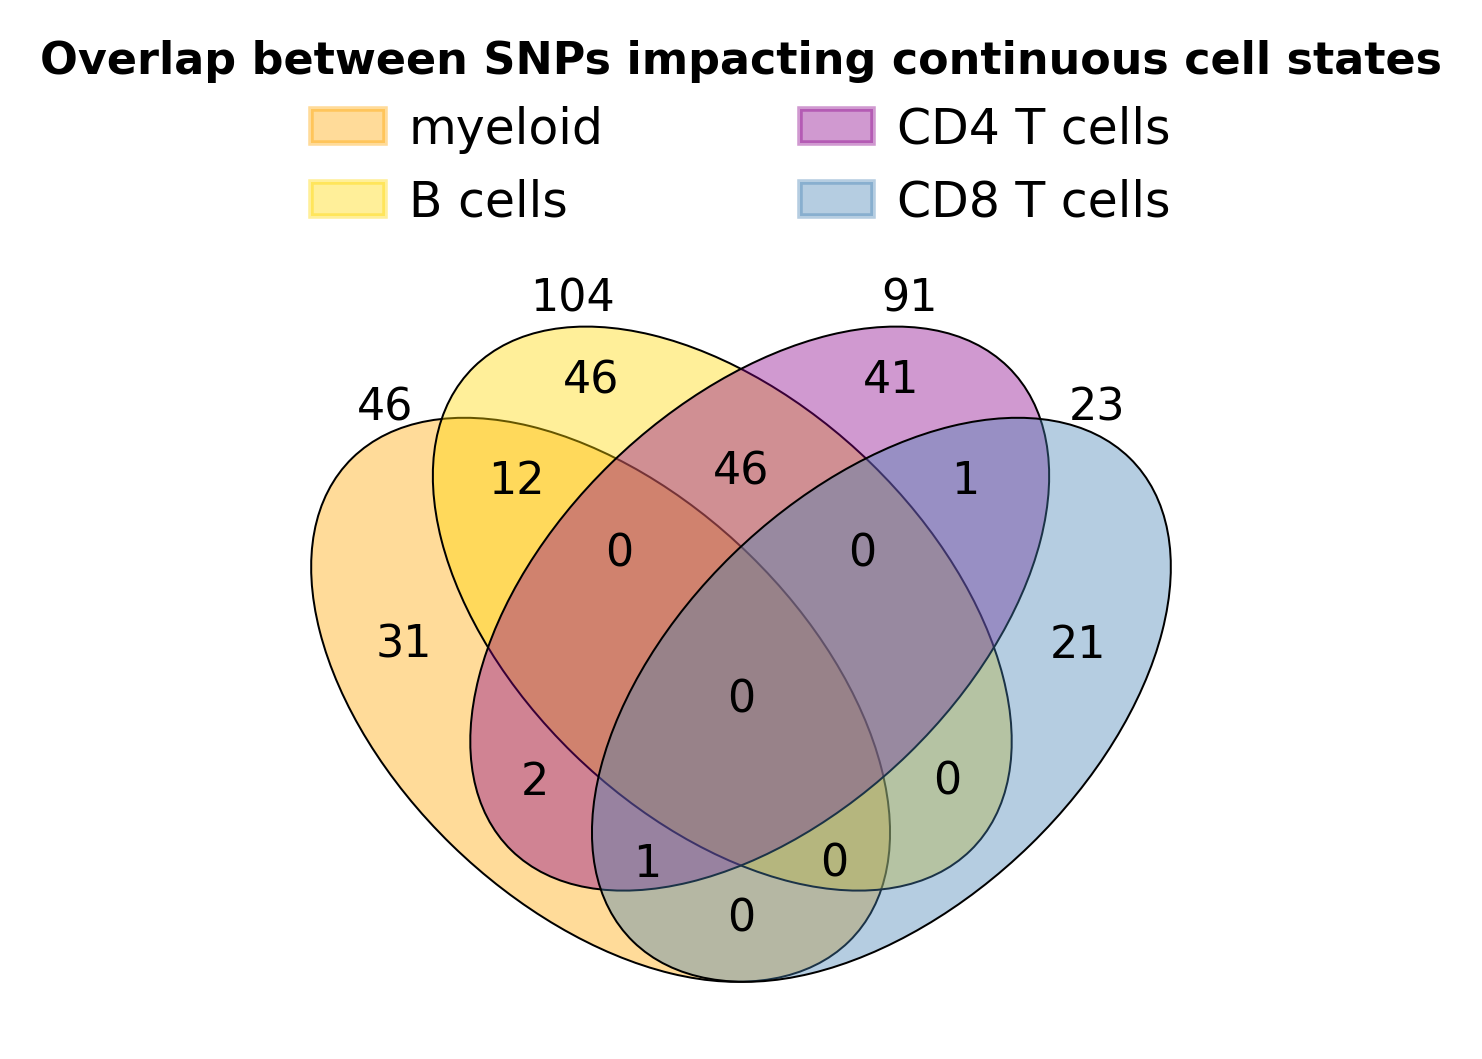

In [57]:
venny4py_custom_colors(sets={"myeloid": set(trans_fSNPs_all.loc[trans_fSNPs_all.Factor.isin(myeloid_factors)].SNP_id.unique()),
                             "B cells": set(trans_fSNPs_all.loc[trans_fSNPs_all.Factor.isin(Bcell_factors)].SNP_id.unique()),
                             "CD4 T cells":set(trans_fSNPs_all.loc[trans_fSNPs_all.Factor.isin(cd4T_factors)].SNP_id.unique()),
                             "CD8 T cells":set(trans_fSNPs_all.loc[trans_fSNPs_all.Factor.isin(cd8T_factors)].SNP_id.unique()),  }, 
                       custom_colors=[major_celltype_colors["Mono"], major_celltype_colors["B"], major_celltype_colors["CD4T"], major_celltype_colors["CD8T"]], 
                       plot_title="Overlap between SNPs impacting continuous cell states",
                       out=os.path.join(model_results_dir, "Figures", "SNP-Overlap_continuous-cell-states_trans-fSNPs-all"),
                       alpha=0.4,
                       fontsize=8,
                       size=3,
                       ext="pdf")

In [29]:
trans_fSNPs.loc[trans_fSNPs.Factor.isin(myeloid_factors+Bcell_factors+cd4T_factors)].SNP_id.nunique()

125

In [30]:
trans_fSNPs.loc[trans_fSNPs.Factor.isin(myeloid_factors+Bcell_factors+cd4T_factors+cd8T_factors)].SNP_id.nunique()

140

In [66]:
trans_fSNPs.loc[trans_fSNPs.Factor.isin(cd4T_factors)].sort_values("corrected_pvalue", ascending=True).drop_duplicates(subset=["Factor"], keep="first")

SNP_id       Factor                      fQTL  effect_size  \
263   6:31636742  D_Factor598   6:31636742__D_Factor598     0.603537   
98    6:29789171  D_Factor287   6:29789171__D_Factor287     0.229134   
237   6:90957463  D_Factor564   6:90957463__D_Factor564    -0.156747   
186   20:6584604  D_Factor470   20:6584604__D_Factor470    -0.153954   
38    1:20227723  D_Factor152   1:20227723__D_Factor152     0.094600   
70   14:24871926  D_Factor220  14:24871926__D_Factor220     0.150469   
112  9:107695848  D_Factor310  9:107695848__D_Factor310     0.182800   
33   5:158843235  D_Factor140  5:158843235__D_Factor140     0.094701   
79   2:111615079  D_Factor242  2:111615079__D_Factor242     0.455684   
116  2:111786637  D_Factor318  2:111786637__D_Factor318    -0.295377   

     effect_size_se       p_value assessed_allele  corrected_pvalue  \
263        0.055697  4.924309e-29               A      7.382954e-25   
98         0.048211  1.749344e-06               T      3.989176e-03   
237        0.034045  3.670008e-06               C      7.868319e-03   
186        0.034478  7.180592e-06               G      1.445851e-02   
38         0.021191  7.222687e-06               G      1.452981e-02   
70         0.034236  1.001134e-05               C      1.936326e-02   
112        0.041752  1.083149e-05               A      2.071002e-02   
33         0.021702  1.158711e-05               C      2.201923e-02   
79         0.107478  2.049749e-05               G      3.570581e-02   
116        0.070507  2.573474e-05               A      4.319078e-02   

     SNP_chrom    SNP_pos  
263          6   31636742  
98           6   29789171  
237          6   90957463  
186         20    6584604  
38           1   20227723  
70          14   24871926  
112          9  107695848  
33           5  158843235  
79           2  111615079  
116          2  111786637

### SNP 6:29789171 (rs1610677) on D287 (KLRB1 gene)

In [27]:
rsid = snp_mapping.loc[snp_mapping.SNP_id_hg19 == "6:29789171"].rsID.iloc[0]
rsid

'rs1610677'

In [28]:
snp_mapping.loc[snp_mapping.rsID == rsid]

SNP_id_hg38 SNP_id_hg19       rsID a0 a1
3366  6:29821394  6:29789171  rs1610677  C  T

In [48]:
cis_eQTLGen_hvgs.loc[cis_eQTLGen_hvgs.snp_id == "6:29789171"]

Pvalue          SNP  SNPChr    SNPPos AssessedAllele  \
2184   2.979700e-188  rs115377808       6  29789171              C   
2896   2.471500e-139  rs115377808       6  29789171              C   
3835   4.774700e-100  rs115377808       6  29789171              C   
3852    1.760200e-99  rs115377808       6  29789171              C   
8554    1.093400e-31  rs115377808       6  29789171              C   
11561   1.694900e-19  rs115377808       6  29789171              C   
20490   6.975500e-08  rs115377808       6  29789171              C   
20601   8.121900e-08  rs115377808       6  29789171              C   
23203   1.753000e-06  rs115377808       6  29789171              C   
24722   7.605400e-06  rs115377808       6  29789171              C   

      OtherAllele   Zscore             Gene GeneSymbol  GeneChr   GenePos  \
2184            T  29.2642  ENSG00000204644      ZFP57        6  29644528   
2896            T  25.1279  ENSG00000204642      HLA-F        6  29698428   
3835            T -21.2324  ENSG00000204632      HLA-G        6  29796823   
3852            T -21.1711  ENSG00000206503      HLA-A        6  29911349   
8554            T  11.7131  ENSG00000204592      HLA-E        6  30459613   
11561           T  -9.0314  ENSG00000066379      ZNRD1        6  30029681   
20490           T   5.3919  ENSG00000137331       IER3        6  30711653   
20601           T  -5.3643  ENSG00000137404        NRM        6  30657510   
23203           T  -4.7799  ENSG00000137337       MDC1        6  30676625   
24722           T   4.4760  ENSG00000234127     TRIM26        6  30166718   

       NrCohorts  NrSamples       FDR    BonferroniP      snp_id  
2184          12       7715  0.000000  3.794400e-180  6:29789171  
2896          30      23793  0.000000  3.147300e-131  6:29789171  
3835          31      23833  0.000000   6.080200e-92  6:29789171  
3852          30      23619  0.000000   2.241500e-91  6:29789171  
8554          11       6796  0.000000   1.392400e-23  6:29789171  
11561         12       7715  0.000000   2.158300e-11  6:29789171  
20490         12       7715  0.000259   1.000000e+00  6:29789171  
20601         32      24752  0.000303   1.000000e+00  6:29789171  
23203         12       7715  0.004821   1.000000e+00  6:29789171  
24722         12       7715  0.019978   1.000000e+00  6:29789171

In [49]:
trans_eQTLGen_sign.loc[trans_eQTLGen_sign.snp_id == "6:29789171"]

Pvalue          SNP  SNPChr    SNPPos AssessedAllele OtherAllele  \
11008  1.033100e-08  rs115377808       6  29789171              C           T   
14392  1.243400e-07  rs115377808       6  29789171              C           T   
18820  9.505900e-07  rs115377808       6  29789171              C           T   
20968  1.916800e-06  rs115377808       6  29789171              C           T   
21364  2.147800e-06  rs115377808       6  29789171              C           T   
27123  8.234300e-06  rs115377808       6  29789171              C           T   

       Zscore             Gene GeneSymbol GeneChr    GenePos  NrCohorts  \
11008  5.7254  ENSG00000169507   SLC38A11       2  165782365         33   
14392 -5.2868  ENSG00000101150    TPD52L2      20   62509770         32   
18820 -4.9014  ENSG00000179218       CALR      19   13052347         33   
20968  4.7620  ENSG00000198546     ZNF511      10  135144006         33   
21364  4.7391  ENSG00000184281      TSSC4      11    2423412         33   
27123  4.4590  ENSG00000178035     IMPDH2       3   49064299         33   

       NrSamples       FDR  BonferroniP         SNP_id1         SNP_id2  \
11008      29827  0.000136          1.0  6_29789171_C_T  6_29789171_T_C   
14392      29613  0.001127          1.0  6_29789171_C_T  6_29789171_T_C   
18820      29827  0.006598          1.0  6_29789171_C_T  6_29789171_T_C   
20968      29827  0.012457          1.0  6_29789171_C_T  6_29789171_T_C   
21364      29827  0.013861          1.0  6_29789171_C_T  6_29789171_T_C   
27123      29827  0.042109          1.0  6_29789171_C_T  6_29789171_T_C   

           snp_id                         QTL  
11008  6:29789171  ENSG00000169507-6:29789171  
14392  6:29789171  ENSG00000101150-6:29789171  
18820  6:29789171  ENSG00000179218-6:29789171  
20968  6:29789171  ENSG00000198546-6:29789171  
21364  6:29789171  ENSG00000184281-6:29789171  
27123  6:29789171  ENSG00000178035-6:29789171

In [50]:
eQTLGen_genes = trans_eQTLGen_sign.loc[trans_eQTLGen_sign.snp_id == "6:29789171"].Gene.tolist()

In [61]:
tensorqtl_results.loc[tensorqtl_results.gene.isin(eQTLGen_genes)]

SNP_id             gene       p_value  effect_size  \
3570   19:47724564  ENSG00000169507  5.271338e-07     0.068753   
3939   14:36649246  ENSG00000179218  6.760883e-07    -0.125671   
7795   4:145026126  ENSG00000169507  2.099785e-07     0.125798   
13104  17:38173637  ENSG00000169507  5.725125e-11     0.146231   
15586  3:159637678  ENSG00000169507  1.678458e-07     0.071489   
15587  3:159665050  ENSG00000169507  2.597788e-07     0.070359   
15860  5:176576293  ENSG00000169507  6.385836e-08     0.074641   
16246   8:69873452  ENSG00000169507  7.521953e-26     0.147811   
16578  11:46761055  ENSG00000169507  2.050611e-21     0.129800   

       effect_size_se ref_allele alt_allele   celltype      Storey_q  \
3570         0.013612          C          T  CD8-S100B  3.829836e-02   
3939         0.025125          T          C     CD8-ET  4.545711e-02   
7795         0.024057          C          T       NK-R  1.988540e-02   
13104        0.022052          C          T    Mono-NC  3.346131e-05   
15586        0.013561          C          A         DC  1.681585e-02   
15587        0.013561          A          G         DC  2.322816e-02   
15860        0.013692          C          G         DC  8.138290e-03   
16246        0.013645          T          C         DC  8.412403e-19   
16578        0.013329          G          A         DC  1.450503e-14   

       BH_corrected_pvalue  BY_corrected_pvalue  
3570          3.829836e-02         8.350730e-01  
3939          4.545711e-02         9.911652e-01  
7795          1.988540e-02         4.335893e-01  
13104         3.346131e-05         7.296039e-04  
15586         1.681585e-02         3.666595e-01  
15587         2.322816e-02         5.064761e-01  
15860         8.138290e-03         1.774506e-01  
16246         8.412403e-19         1.834274e-17  
16578         1.450503e-14         3.162736e-13

In [68]:
tensorqtl_results.loc[tensorqtl_results.SNP_id == "6:29789171"]

Empty DataFrame
Columns: [SNP_id, gene, p_value, effect_size, effect_size_se, ref_allele, alt_allele, celltype, Storey_q, BH_corrected_pvalue, BY_corrected_pvalue]
Index: []

In [30]:
trans_fSNPs.loc[(trans_fSNPs.SNP_id == "6:29789171") & (trans_fSNPs.Factor == "D_Factor287")]

SNP_id       Factor                     fQTL  effect_size  \
98  6:29789171  D_Factor287  6:29789171__D_Factor287     0.229134   

    effect_size_se   p_value assessed_allele  corrected_pvalue  SNP_chrom  \
98        0.048211  0.000002               T          0.003989          6   

     SNP_pos  
98  29789171

In [31]:
GT_matrix.loc[SNP_dict_inv["6:29789171"]].value_counts()

6_29789171_T_C
1.0    489
2.0    315
0.0    230
Name: count, dtype: int64

/tmp/ipykernel_1773371/1126630027.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


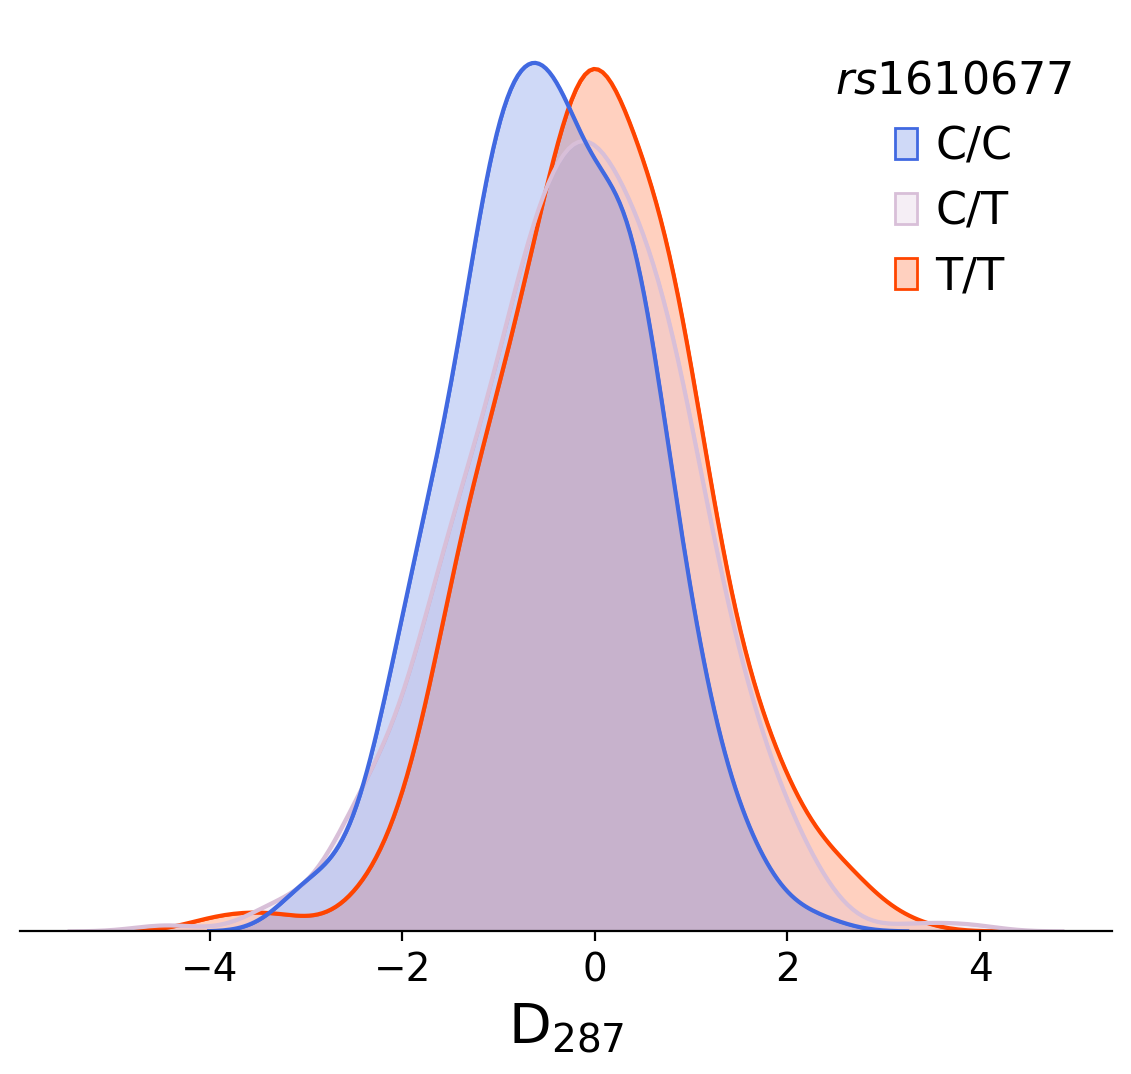

In [33]:
tmp = pd.merge(D["D_Factor287"], GT_matrix.loc[SNP_dict_inv["6:29789171"]].astype(int), right_index=True, left_index=True, how="left")
labels_dict = dict(zip([0, 1, 2], ["C/C", "C/T", "T/T"]))
tmp["6_29789171_T_C"].replace(labels_dict, inplace=True)
tmp.rename(columns={"6_29789171_T_C":f"${rsid}$"}, inplace=True)

legend_handles = []
legend_labels = []

p = sns.kdeplot(x="D_Factor287", hue=f"${rsid}$", fill=True, data=tmp, palette=["royalblue", "thistle", "orangered"], 
                hue_order=["C/C", "C/T", "T/T"], legend=True, common_norm=False)
p = sns.kdeplot(x="D_Factor287", hue=f"${rsid}$", fill=False, data=tmp, palette=["royalblue", "thistle", "orangered"], 
                hue_order=["C/C", "C/T", "T/T"], legend=False, common_norm=False)

p.set_xlabel("D$_{287}$", fontsize=20)
p.tick_params(axis="x", labelsize=14) 
p.set_ylabel("")
p.set_yticks([])
p.spines["left"].set_visible(False)
p.spines["right"].set_visible(False)
p.spines["top"].set_visible(False)

leg = p.get_legend()
legend_labels = [t.get_text() for t in leg.get_texts()]
legend_handles = leg.legend_handles

p.legend(title=f"${rsid}$", handles=legend_handles, labels=legend_labels, frameon=False, title_fontsize=16, fontsize=16)

plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_D287_colored-by_6-29789171_wo-y-axis.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_D287_colored-by_6-29789171_wo-y-axis.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_D287_colored-by_6-29789171_wo-y-axis.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")

/data/danai/scripts/LIVI/src/analysis/plotting.py:2173: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


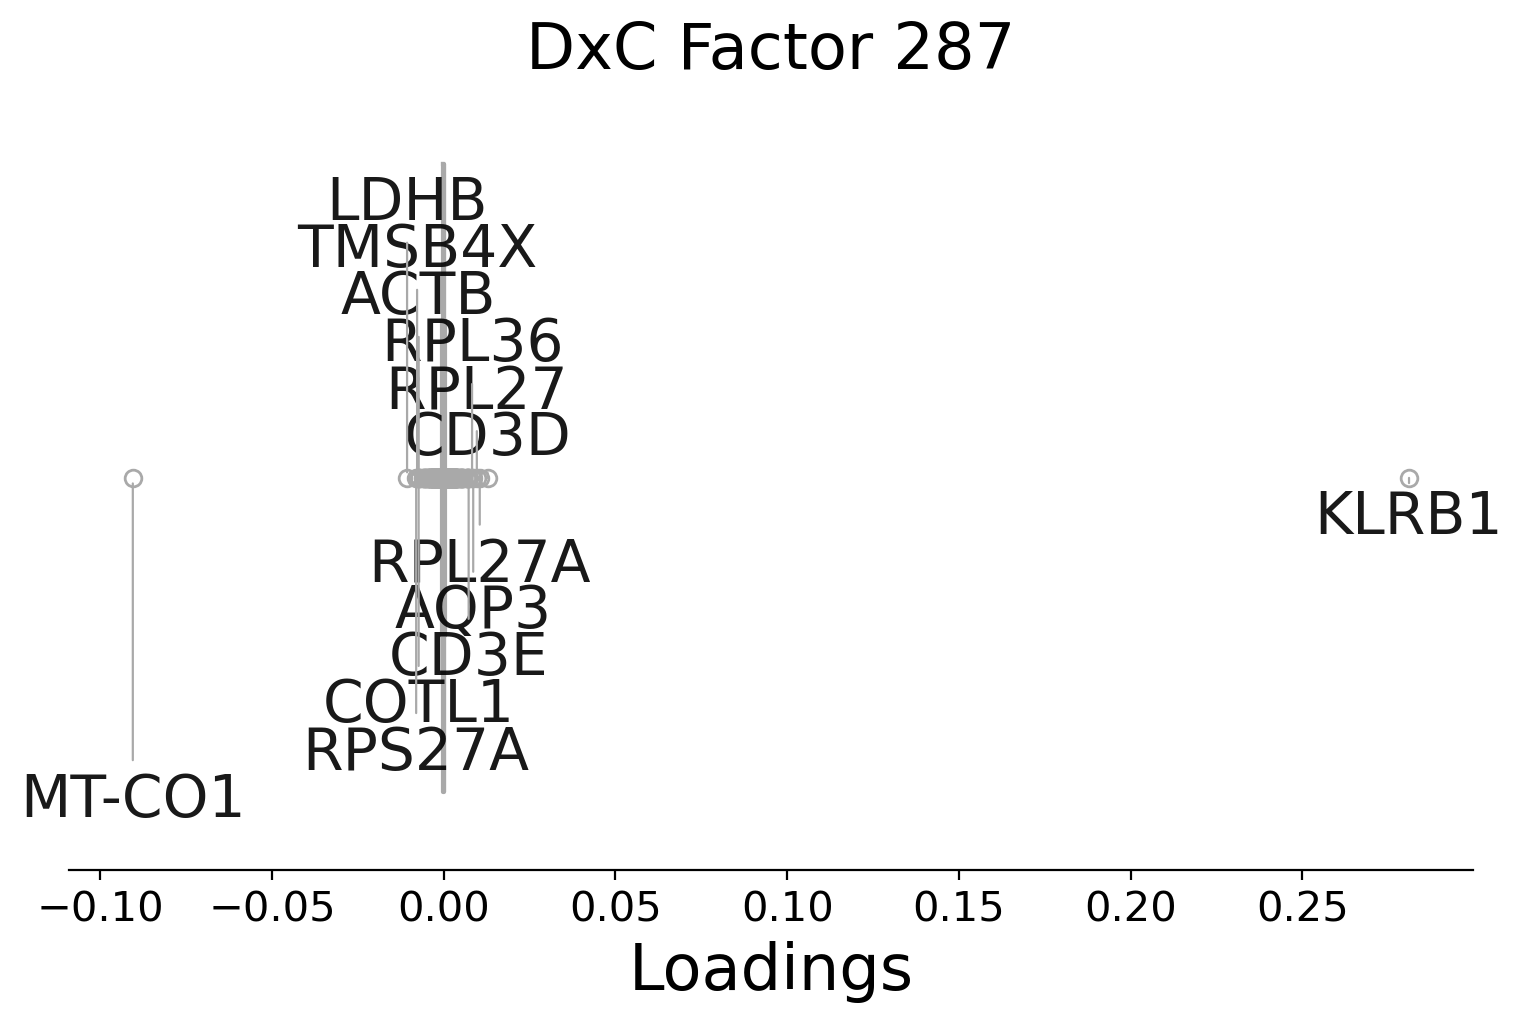

In [34]:
plot_gene_loadings_for_factor(
    DxC_decoder=DxC_decoder,
    factor="DxC_Factor287",
    adata_var=adata.var,
    gene_name_column="GeneSymbol",
    color="darkgrey",
    spines_invisible=True,
    n_top_genes=13,
    genes_to_annotate=None,
    annotation_fontsize=21,
    offset=0.06,
    x_distance=1e-1,
    savefig=os.path.join(model_results_dir, "Figures", "Gene-loadings_DxC287_6-29789171_trans-fSNP.pdf"),
)

In [248]:
DxC_decoder["DxC_Factor287"].abs().nlargest(10)

Geneid
ENSG00000111796    0.281044
ENSG00000198804    0.090512
ENSG00000167286    0.012754
ENSG00000111716    0.010663
ENSG00000166441    0.010498
ENSG00000131469    0.009644
ENSG00000165272    0.008593
ENSG00000130255    0.008259
ENSG00000143947    0.008018
ENSG00000205542    0.007746
Name: DxC_Factor287, dtype: float64

In [35]:
DxC_beta = calculate_DxC_effect(
    DxC_associations = GxC_effects,
    SNP_id = SNP_dict_inv["6:29789171"],
    cell_state_latent = cell_state,
    A = assignment_matrix,
)
DxC_beta.head()

DxC_Factor72  DxC_Factor147  DxC_Factor151  DxC_Factor287  \
barcode                                                                         
AAACCTGAGAATGTTG-1     -0.007276      -0.038780       0.038759       0.053716   
AAACCTGAGAGAACAG-1     -0.063860      -0.057446       0.023825       0.009920   
AAACCTGAGCATGGCA-1     -0.005829      -0.031685       0.066290       0.019374   
AAACCTGAGTATTGGA-1     -0.021607      -0.052110       0.031630       0.024830   
AAACCTGAGTGTCCCG-1     -0.023770      -0.068878       0.017423       0.017722   

                    DxC_Factor308  DxC_Factor450  DxC_Factor598  
barcode                                                          
AAACCTGAGAATGTTG-1       0.009958      -0.026488       0.100939  
AAACCTGAGAGAACAG-1       0.005511      -0.037981       0.118390  
AAACCTGAGCATGGCA-1       0.015909      -0.040754       0.077111  
AAACCTGAGTATTGGA-1       0.009149      -0.031191       0.093165  
AAACCTGAGTGTCCCG-1       0.006765      -0.022299       0.098340

In [37]:
DxC_beta_ct = DxC_beta.abs().merge(adata.obs.cell_label, right_index=True, left_index=True)
DxC_beta_ct = DxC_beta_ct.groupby("cell_label", observed=True).apply(lambda x: x["DxC_Factor287"].mean(), include_groups=False).rename("DxC_Factor287")
DxC_beta_ct

cell_label
B IN         0.008951
B Mem        0.015035
CD4 ET       0.040374
CD4 NC       0.033733
CD4 SOX4     0.027243
CD8 ET       0.010784
CD8 NC       0.025381
CD8 S100B    0.022445
DC           0.006138
Mono C       0.006244
Mono NC      0.005542
NK           0.008713
NK R         0.009706
Plasma       0.003781
Name: DxC_Factor287, dtype: float64

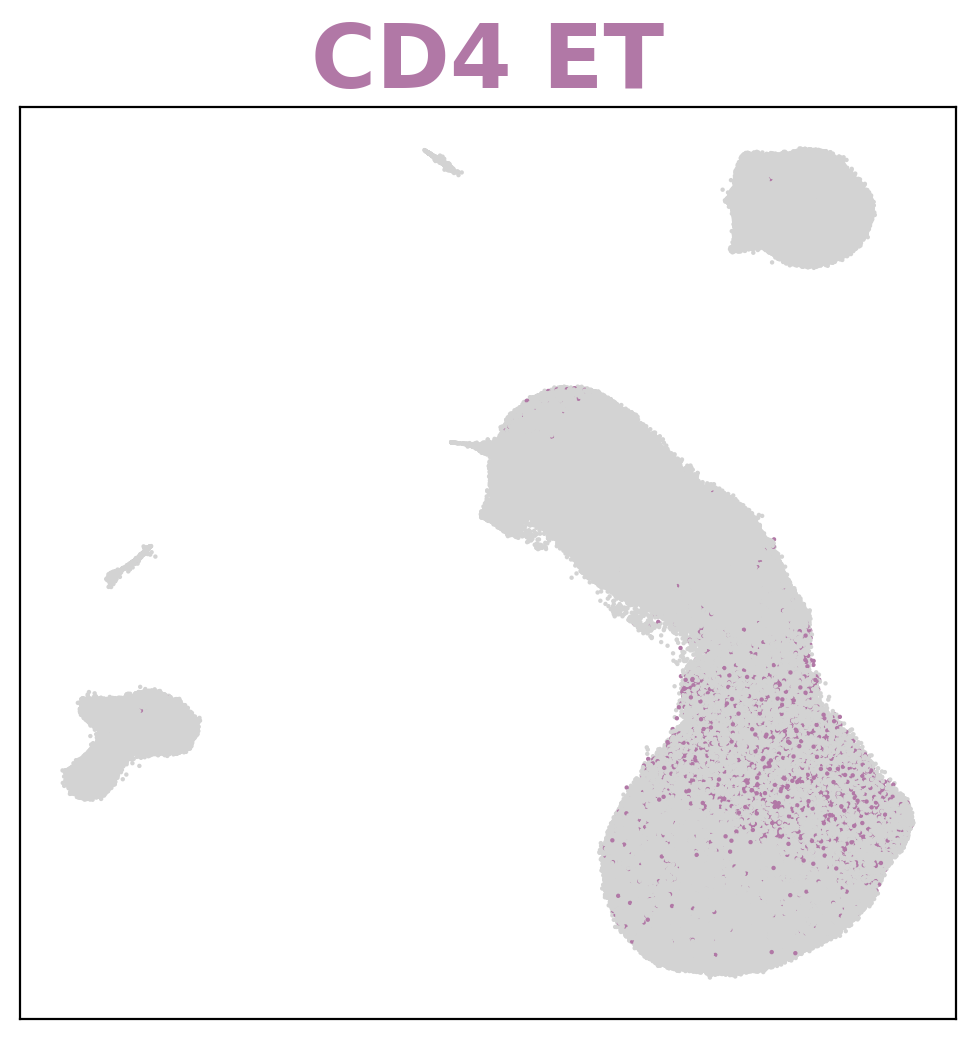

In [42]:
adata.obs = adata.obs.assign(cells2plot = [False]*adata.obs.shape[0])
adata.obs.loc[adata.obs.cell_label == "CD4 ET", "cells2plot"] = True

fig, axs = plt.subplots(figsize=(6,6))

sc.pl.umap(adata,
           color="cells2plot", 
           # title=r"$CD4^+$ ET cells",
           title=r"CD4 ET",
           size=10,
           palette=["lightgrey", cell_label_colors["CD4 ET"]],
           hspace=0.14,
           save=None,
           show=False,
           legend_loc="none",
           ax=axs)

# axs.set_xlabel("UMAP1", fontsize=24)
# axs.set_ylabel("UMAP2", fontsize=24)
axs.set_xlabel("")
axs.set_ylabel("")
axs.set_title(axs.get_title(), fontdict={"fontsize":32, "color":cell_label_colors["CD4 ET"], "weight":"bold"})

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-ET-cells-highlighted_wo-axis-labels.eps"), 
            bbox_inches="tight", transparent=True, dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-ET-cells-highlighted_wo-axis-labels.png"), 
            bbox_inches="tight", transparent=True, dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-ET-cells-highlighted_wo-axis-labels.pdf"), 
            bbox_inches="tight", transparent=True, dpi=400)

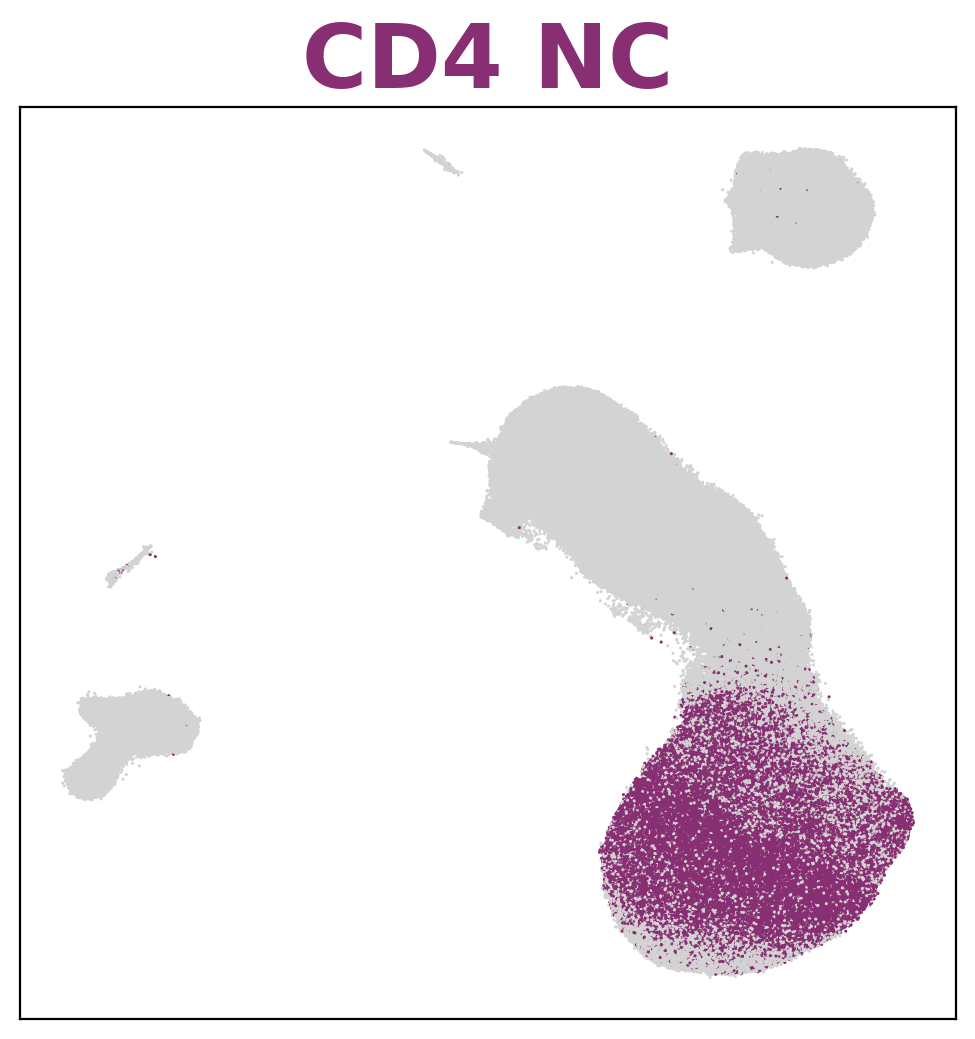

In [41]:
adata.obs = adata.obs.assign(cells2plot = [False]*adata.obs.shape[0])
adata.obs.loc[adata.obs.cell_label == "CD4 NC", "cells2plot"] = True

fig, axs = plt.subplots(figsize=(6,6))

sc.pl.umap(adata,
           color="cells2plot", 
           title="CD4 NC",
           size=5,
           palette=["lightgrey", cell_label_colors["CD4 NC"]],
           hspace=0.14,
           save=None,
           show=False,
           legend_loc="none",
           ax=axs)

# axs.set_xlabel("UMAP1", fontsize=24)
# axs.set_ylabel("UMAP2", fontsize=24)
axs.set_xlabel("")
axs.set_ylabel("")
axs.set_title(axs.get_title(), fontdict={"fontsize":32, "color":cell_label_colors["CD4 NC"], "weight":"bold"})


plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-NC-cells-highlighted_wo-axis-labels.eps"), 
            bbox_inches="tight", transparent=True, dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-NC-cells-highlighted_wo-axis-labels.png"), 
            bbox_inches="tight", transparent=True, dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-NC-cells-highlighted_wo-axis-labels.pdf"), 
            bbox_inches="tight", transparent=True, dpi=400)

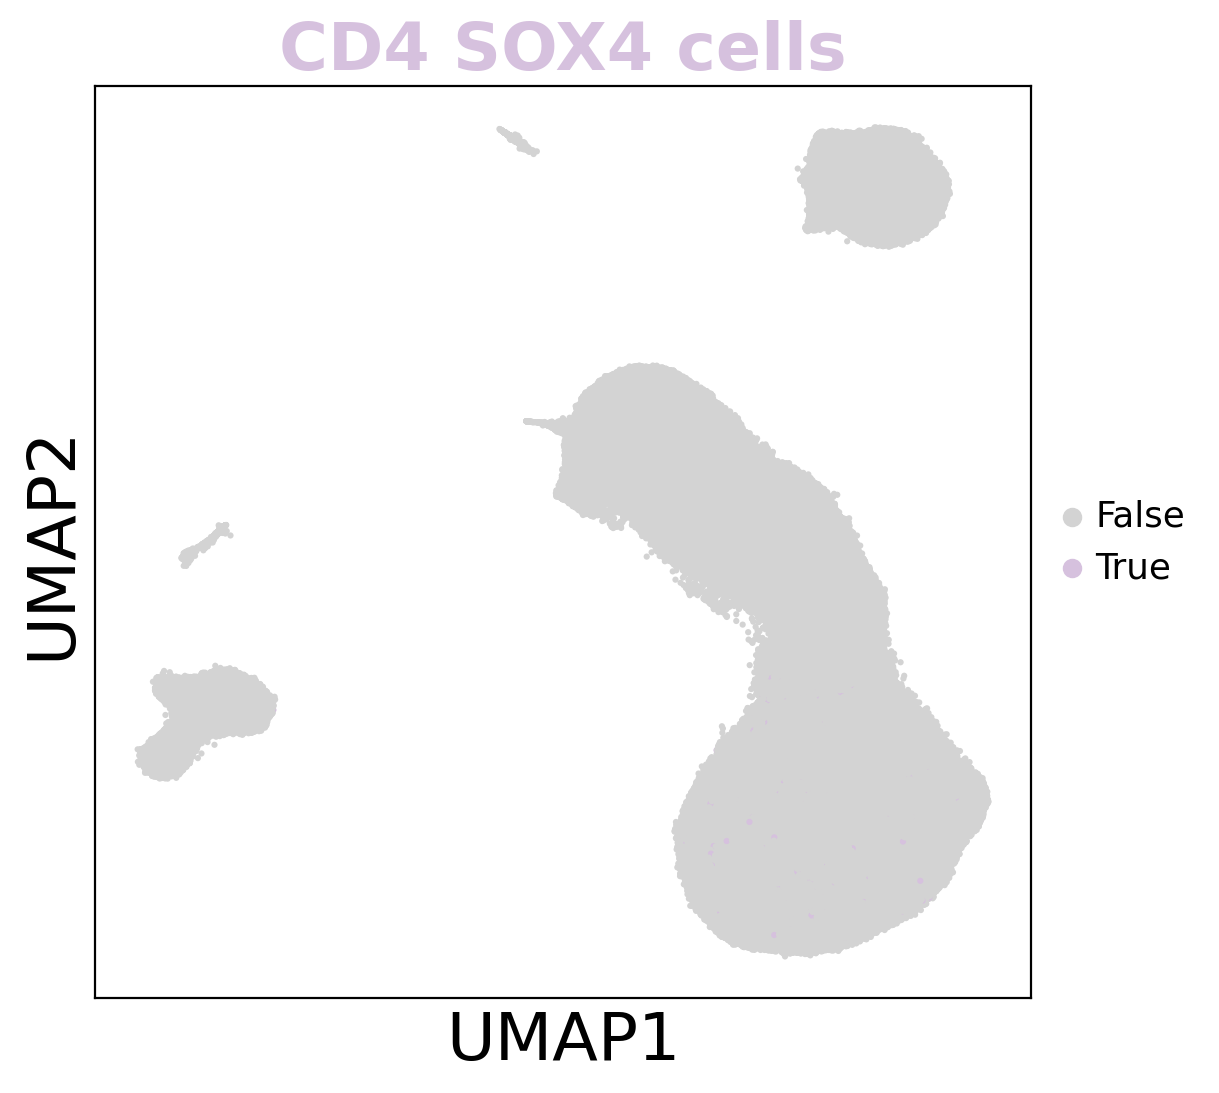

In [40]:
adata.obs = adata.obs.assign(cells2plot = [False]*adata.obs.shape[0])
adata.obs.loc[adata.obs.cell_label == "CD4 SOX4", "cells2plot"] = True

fig, axs = plt.subplots(figsize=(6,6))

sc.pl.umap(adata,
           color="cells2plot", 
           title="CD4 SOX4 cells",
           size=20,
           palette=["lightgrey", cell_label_colors["CD4 SOX4"]],
           hspace=0.14,
           save=None,
           show=False,
           ax=axs)

axs.set_xlabel("UMAP1", fontsize=24)
axs.set_ylabel("UMAP2", fontsize=24)
axs.set_title(axs.get_title(), fontdict={"fontsize":24, "color":cell_label_colors["CD4 SOX4"], "weight":"bold"})


plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-SOX4-cells-highlighted.eps"), 
            bbox_inches="tight", transparent=True, dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-SOX4-cells-highlighted.png"), 
            bbox_inches="tight", transparent=True, dpi=400)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP-cell-state_CD4-SOX4-cells-highlighted.pdf"), 
            bbox_inches="tight", transparent=True, dpi=400)

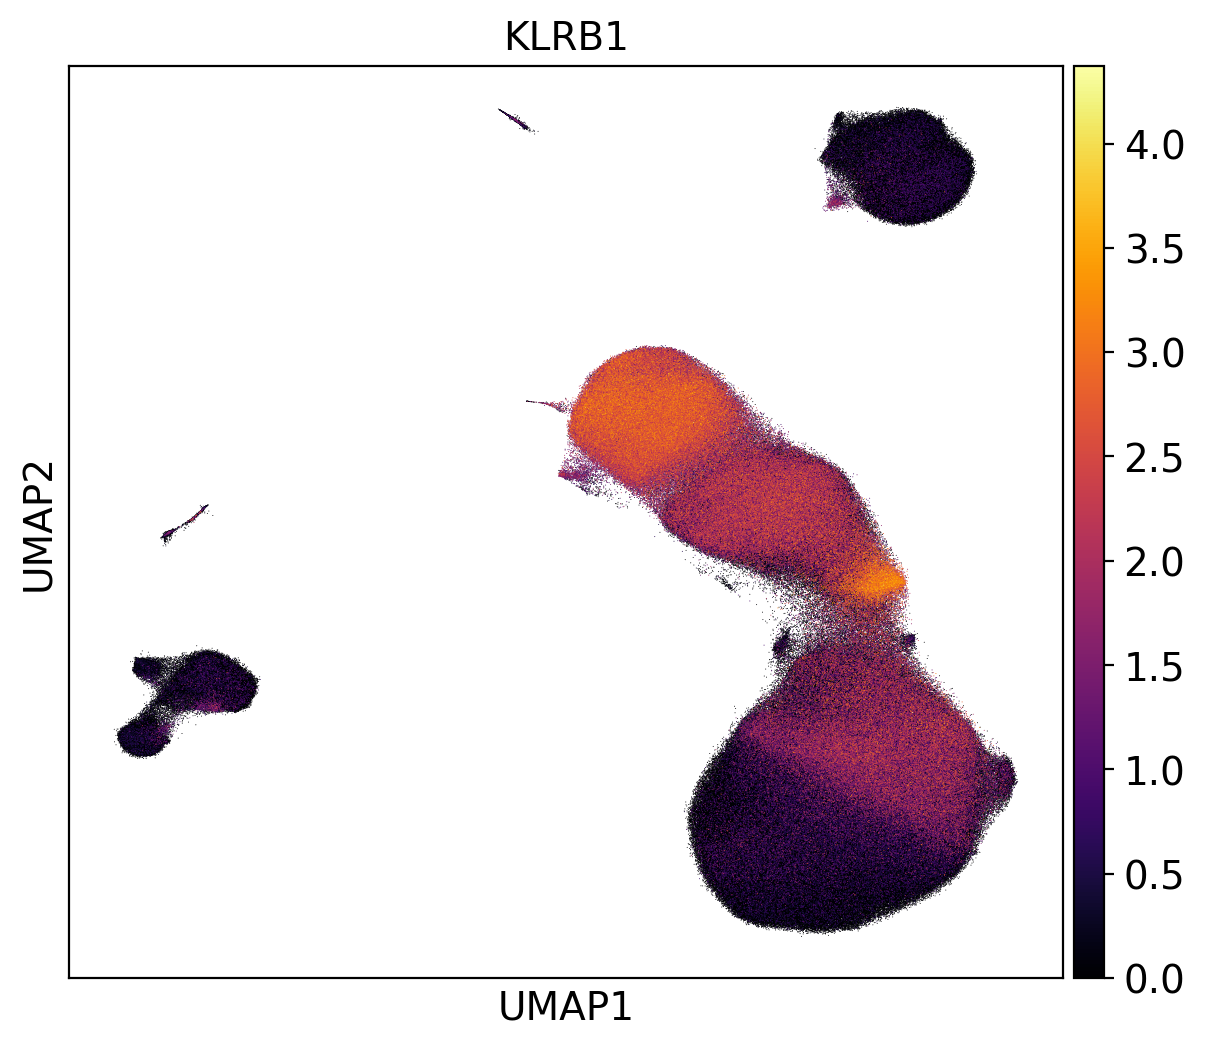

In [107]:
sc.pl.umap(adata, color=DxC_decoder["DxC_Factor287"].abs().nlargest(1).index, 
           title=adata.var.loc[DxC_decoder["DxC_Factor287"].abs().nlargest(1).index].GeneSymbol,
           cmap="inferno", s=0.5, save="_expression-of-KLRB1_SNP-6-29789171.pdf")

In [108]:
adata[adata.obs.loc[adata.obs.cell_label == "CD4 NC"].index, DxC_decoder["DxC_Factor287"].abs().nlargest(1).index].X.mean()

0.10571634863922567

In [109]:
adata[adata.obs.loc[adata.obs.cell_label == "CD4 ET"].index, DxC_decoder["DxC_Factor287"].abs().nlargest(1).index].X.mean()

1.2826754329213323

In [43]:
effect_on_genes = calculate_DxC_gene_effect(
    DxC_associations = GxC_effects.loc[GxC_effects.Factor == "D_Factor287"],
    SNP_id = SNP_dict_inv["6:29789171"],
    cell_state_latent = cell_state,
    A = assignment_matrix,
    DxC_decoder = DxC_decoder.loc[DxC_decoder["DxC_Factor287"].abs().nlargest(5).index, "DxC_Factor287"].to_frame(),
)
effect_on_genes = effect_on_genes.merge(adata.obs.cell_label, right_index=True, left_index=True)
effect_on_genes

ENSG00000111796  ENSG00000198804  ENSG00000167286  \
barcode                                                                 
AAACCTGAGAATGTTG-1         0.015097        -0.004862         0.000685   
AAACCTGAGAGAACAG-1         0.002788        -0.000898         0.000127   
AAACCTGAGCATGGCA-1         0.005445        -0.001754         0.000247   
AAACCTGAGTATTGGA-1         0.006978        -0.002247         0.000317   
AAACCTGAGTGTCCCG-1         0.004981        -0.001604         0.000226   
...                             ...              ...              ...   
TTTGTCATCCGCTGTT-9         0.003565        -0.001148         0.000162   
TTTGTCATCCGTTGTC-9         0.011864        -0.003821         0.000538   
TTTGTCATCGCCGTGA-9         0.011216        -0.003612         0.000509   
TTTGTCATCGCGGATC-9         0.009598        -0.003091         0.000436   
TTTGTCATCTCGTATT-9         0.008716        -0.002807         0.000396   

                    ENSG00000111716  ENSG00000166441 cell_label  
barcode                                                          
AAACCTGAGAATGTTG-1        -0.000573         0.000564     CD4 ET  
AAACCTGAGAGAACAG-1        -0.000106         0.000104         NK  
AAACCTGAGCATGGCA-1        -0.000207         0.000203     CD4 NC  
AAACCTGAGTATTGGA-1        -0.000265         0.000261  CD8 S100B  
AAACCTGAGTGTCCCG-1        -0.000189         0.000186     CD8 ET  
...                             ...              ...        ...  
TTTGTCATCCGCTGTT-9        -0.000135         0.000133       B IN  
TTTGTCATCCGTTGTC-9        -0.000450         0.000443     CD4 NC  
TTTGTCATCGCCGTGA-9        -0.000426         0.000419     CD4 NC  
TTTGTCATCGCGGATC-9        -0.000364         0.000359     CD4 NC  
TTTGTCATCTCGTATT-9        -0.000331         0.000326     CD8 ET  

[1172790 rows x 6 columns]

In [44]:
KLRB1_effect_ct = effect_on_genes.filter(["ENSG00000111796", "cell_label"]).groupby("cell_label").apply(lambda x: x.mean())
KLRB1_effect_ct

/tmp/ipykernel_1773371/2052467359.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


ENSG00000111796
cell_label                 
B IN               0.002516
B Mem              0.004225
CD4 ET             0.011347
CD4 NC             0.009480
CD4 SOX4           0.007657
CD8 ET             0.003031
CD8 NC             0.007133
CD8 S100B          0.006308
DC                 0.001725
Mono C             0.001755
Mono NC            0.001558
NK                 0.002449
NK R               0.002728
Plasma             0.001063

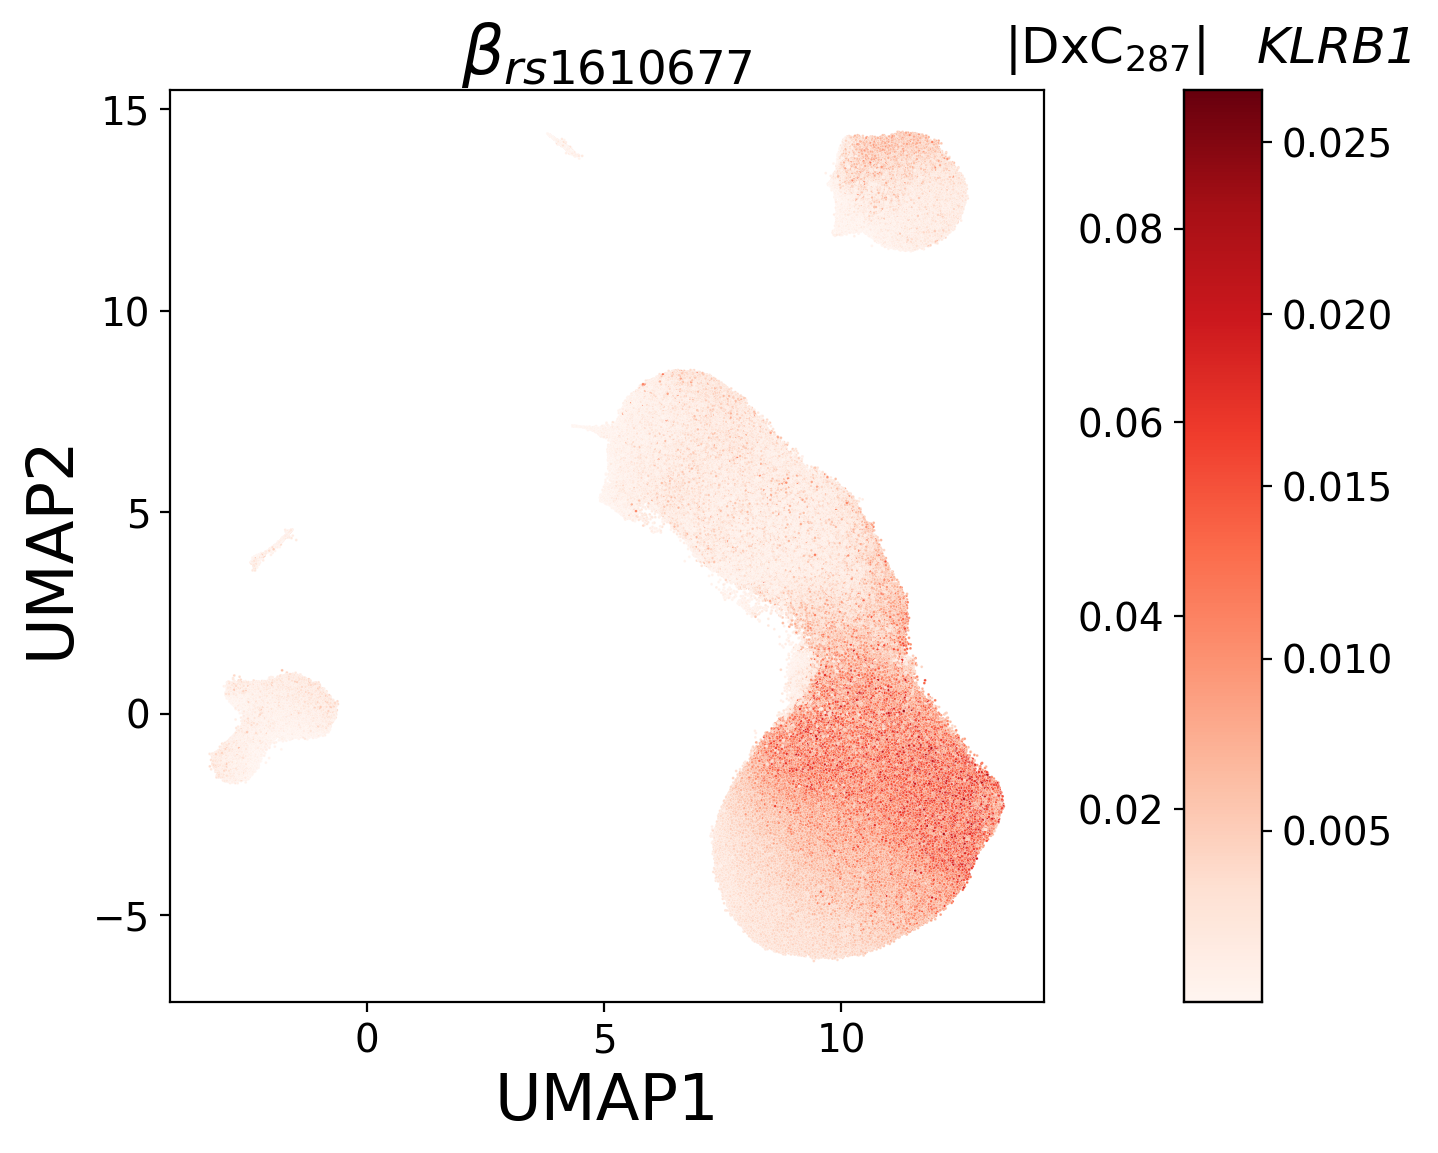

In [116]:
## Double-scale colorbar
g = DxC_decoder["DxC_Factor287"].abs().nlargest(1).index[0]

hgnc_name = adata.var.loc[g].GeneSymbol
comap="Reds"

fig, axs = plt.subplots(figsize=(7,6))
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    hue="GxC_Factor287",
    data=umap_cc.merge(DxC_beta["GxC_Factor287"], right_index=True, left_index=True),
    ax=axs,
    s=1,
    palette=comap,
    rasterized=True,
    legend=False,
)

norM = colors.Normalize(vmin=DxC_beta["GxC_Factor287"].abs().min(), vmax=DxC_beta["GxC_Factor287"].abs().max())
sm = cm.ScalarMappable(
    cmap=comap,
    norm=norM
)
cb = plt.colorbar(sm, ax=axs)
pos = cb.ax.get_position()
cb.ax.set_aspect("auto")
axs2 = cb.ax.twinx()
axs2.set_ylim([effect_on_genes[g].abs().min(), effect_on_genes[g].abs().max()])

# resize the colorbar (otherwise it overlays the plot)
pos.x0 +=0.061
cb.ax.set_position(pos)
axs2.set_position(pos)


axs.set_title(
    label=fr"$\beta_{{{rsid}}}$", fontdict={"fontsize": 24}, loc="center"
)

axs2.text(x=pos.x0-3.2, y=0.0273, s="|DxC$_{287}$|", fontdict={"fontsize": 18})

axs2.text(x=pos.x0+0.03, y=0.0273, s="KLRB1", fontdict={"fontsize": 18, "fontstyle":"italic"})



axs.set_xlabel("UMAP1", fontsize=23)
axs.set_ylabel("UMAP2", fontsize=23)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_D287_SNP-6-29789171-effect-on-{hgnc_name}_trans-fSNP_double-colorbar_Reds-cmap.png"),
            dpi=500, transparent=True, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_D287_SNP-6-29789171-effect-on-{hgnc_name}_trans-fSNP_double-colorbar_Reds-cmap.eps"),
            dpi=500, transparent=True, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_D287_SNP-6-29789171-effect-on-{hgnc_name}_trans-fSNP_double-colorbar_Reds-cmap.pdf"),
            dpi=500, transparent=True, bbox_inches="tight")

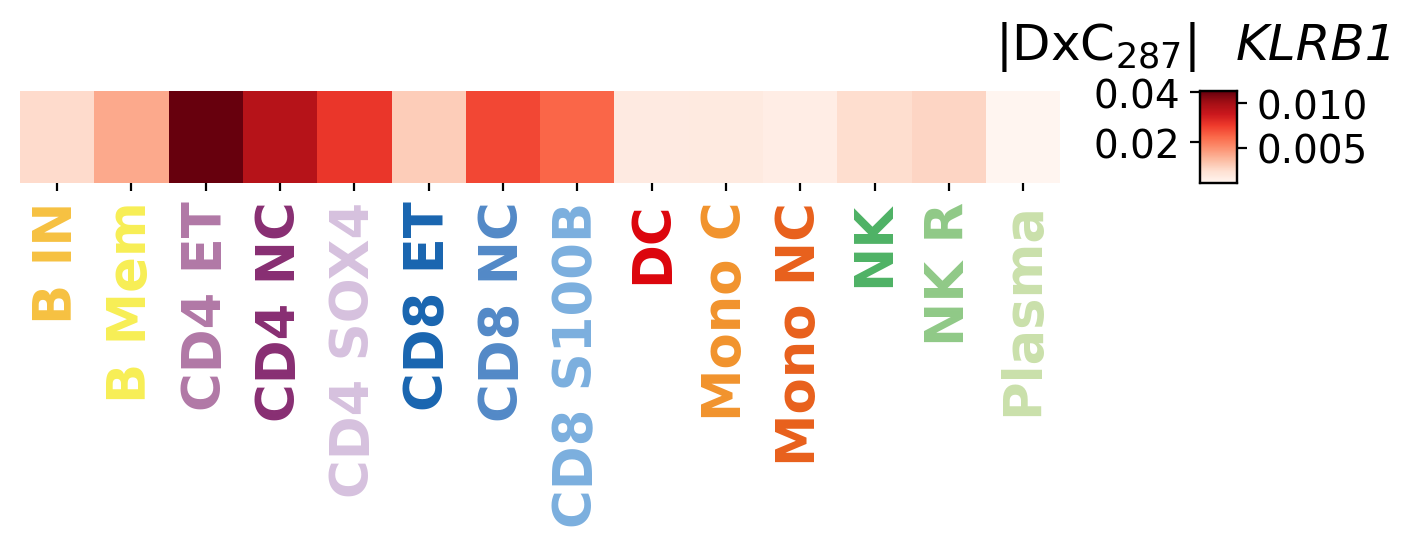

In [132]:
fig, axs = plt.subplots(figsize=(7.8,0.6))

norM = colors.Normalize(vmin=DxC_beta_ct.min(), vmax=DxC_beta_ct.max())

sns.heatmap(DxC_beta_ct.to_frame().T, cmap="Reds", ax=axs, yticklabels=[],
            cbar_kws={"anchor":(2,0.5)}, cbar=False)

sm = cm.ScalarMappable(
    cmap="Reds",
    norm=norM
)
cb = plt.colorbar(sm, ax=axs, pad=0.025, shrink=1, fraction=0.12)
pos = cb.ax.get_position()
cb.ax.set_aspect("auto")
axs2 = cb.ax.twinx()
axs2.set_ylim([KLRB1_effect_ct[g].min(), KLRB1_effect_ct[g].max()])

# Resize the colorbar (otherwise it overlays the plot)
pos.x0 +=0.07
cb.ax.set_position(pos)
axs2.set_position(pos)

axs2.text(x=pos.x0-6.5, y=0.015, s=r"|DxC$_{287}$|", fontdict={"fontsize": 18})

axs2.text(x=pos.x0+0.03, y=0.015, s="KLRB1", fontdict={"fontsize": 18, "fontstyle":"italic"})


axs.set_xlabel("")
axs.xaxis.label.set_fontsize(23)
axs.tick_params(axis="x", length=3)
for j, label in enumerate(axs.get_xticklabels()):
    label.set_color(cell_label_colors[label.get_text()])
    label.set_fontweight("bold")
    label.set_fontsize(19)

    
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171-effect_celltype_heatmap_trans-fSNP_double-colorbar_Reds-cmap.pdf"), 
            bbox_inches="tight", transparent=True, dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171-effect_celltype_heatmap_trans-fSNP_double-colorbar_Reds-cmap.png"), 
            bbox_inches="tight", transparent=True, dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171-effect_celltype_heatmap_trans-fSNP_double-colorbar_Reds-cmap.eps"), 
            bbox_inches="tight", transparent=True, dpi=600)


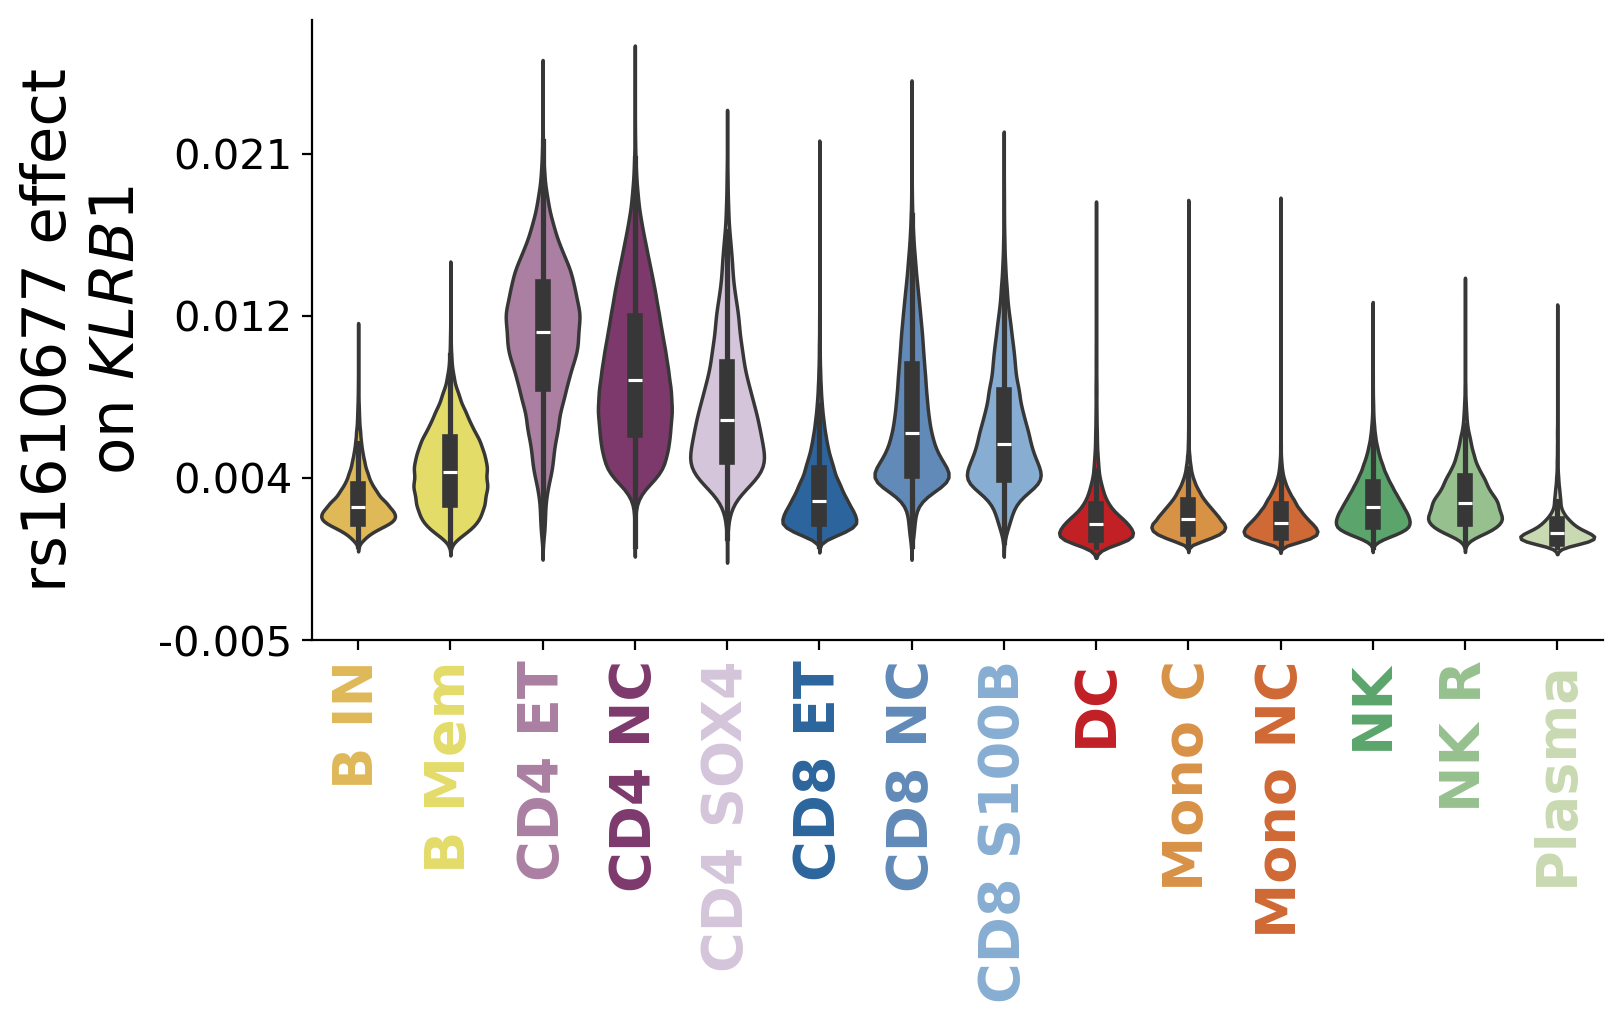

In [122]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(8,5), constrained_layout=True)

GE = DxC_decoder["DxC_Factor287"].abs().nlargest(1).index.tolist()[0]
GE_HGNC = adata.var.loc[GE].GeneSymbol
violins = sns.violinplot(x="cell_label", y=GE, data=effect_on_genes,
                         hue="cell_label", palette=cell_label_colors, ax=axs)
axs.set_ylabel(f"{rsid} effect\non ${GE_HGNC}$", fontsize=22)
# axs.axhline(y=effect_on_genes[GE].mean(), color="grey", linestyle=":")
# axs.axhline(y=effect_on_genes[GE].median(), color="grey", linestyle=":")
tick_interval = np.abs(axs.get_yticks().max() - axs.get_yticks().min())/4
axs.set_yticks(np.arange(axs.get_yticks().min(), axs.get_yticks().max(), tick_interval),
                  np.round(np.arange(axs.get_yticks().min(), axs.get_yticks().max(), tick_interval),3), fontsize=15)
axs.set_xlabel("")
axs.set_xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=90, fontsize=20)
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)
# Extract the colors used by the violins
violin_colors = [child.get_facecolor() for child in violins.collections[::1]]
for j, label in enumerate(axs.get_xticklabels()):
    label.set_color(violin_colors[j])
    label.set_fontweight("bold")

# fig.suptitle(t=f"${rsid}$ effect", fontsize=22)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_Violin-plots_D287_SNP-6-29789171-effect-on-KLRB1_all-celltypes.png"), 
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_Violin-plots_D287_SNP-6-29789171-effect-on-KLRB1_all-celltypes.eps"), 
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_Violin-plots_D287_SNP-6-29789171-effect-on-KLRB1_all-celltypes.pdf"), 
            transparent=True, dpi=500, bbox_inches="tight")

In [126]:
effect_on_genes_CD4T = effect_on_genes.loc[effect_on_genes.cell_label.isin(["CD4 ET", "CD4 NC"])]
effect_on_genes_CD4T.cell_label = effect_on_genes_CD4T.cell_label.cat.remove_unused_categories()

/tmp/ipykernel_1153526/2357319367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/data/danai/scripts/LIVI/src/analysis/plotting.py:2487: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.


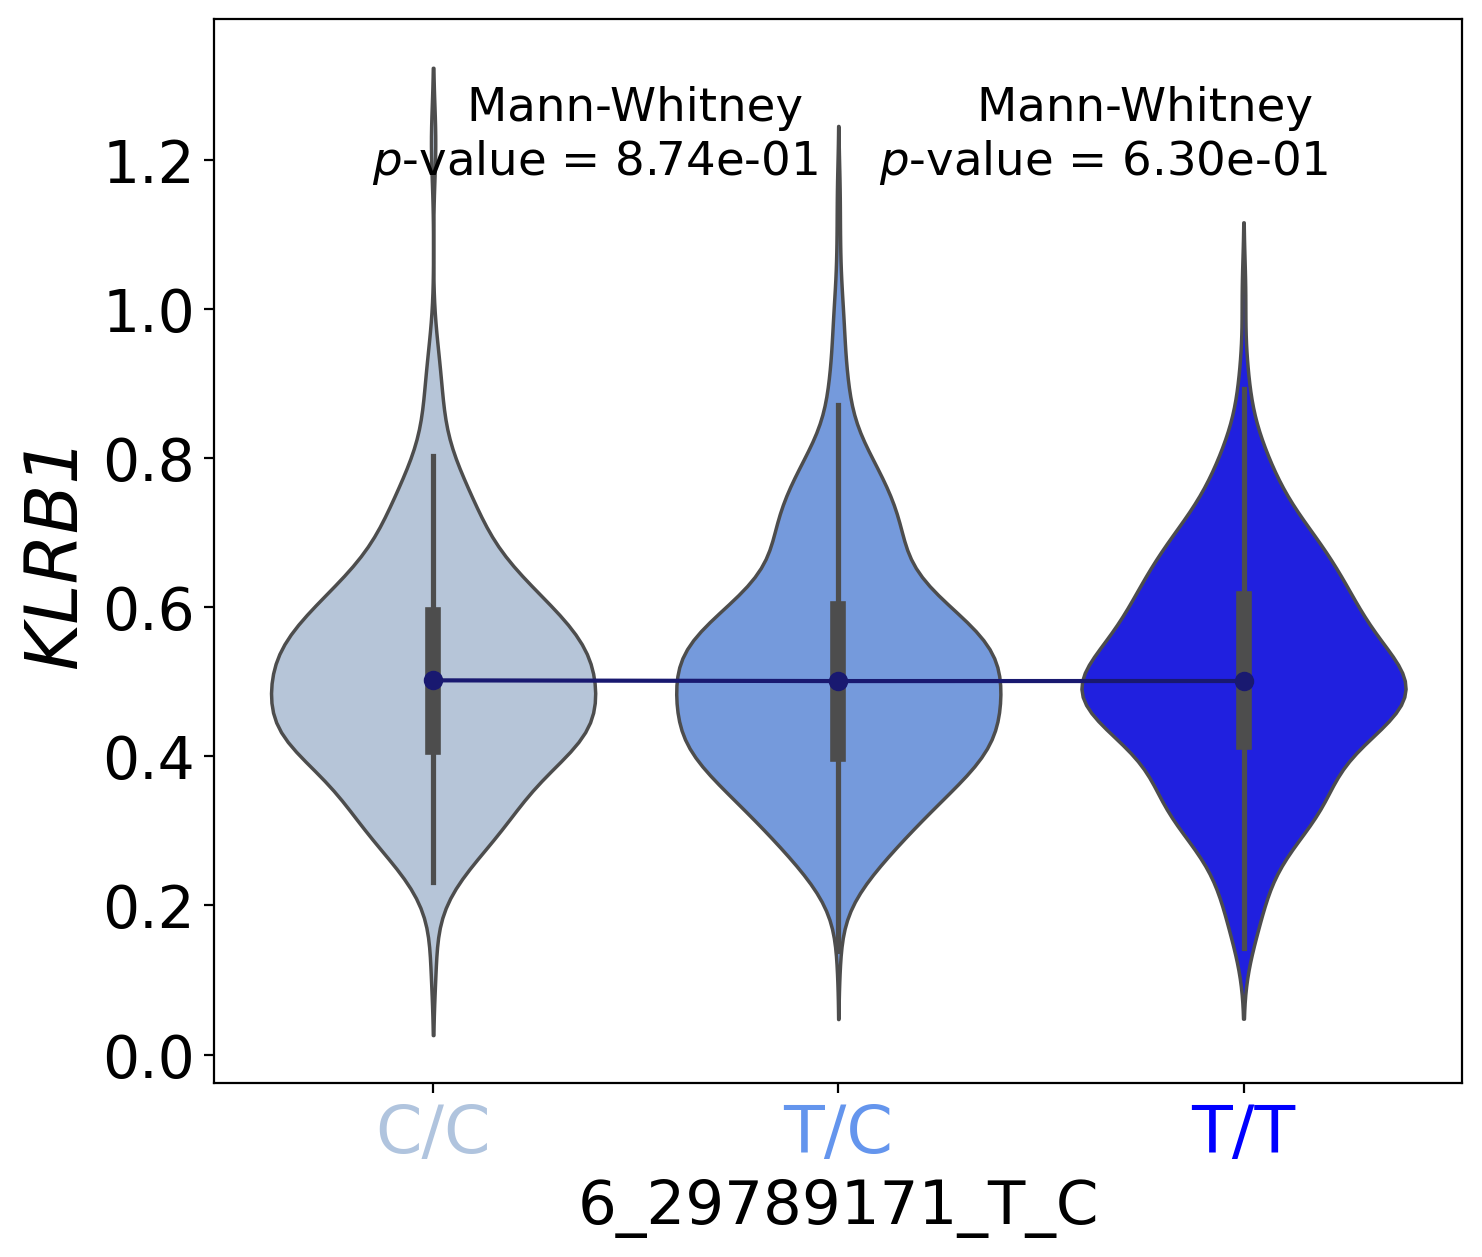

In [130]:
# All cells
plot_ct_gex_vs_gt(
    adata=adata,
    gene="ENSG00000111796",
    annotation_fontsize=24,
    cell_indices=None,
    celltype=None,
    celltype_column="cell_label",
    iid_column="individual",
    GT_matrix=GT_matrix,
    SNP_id=SNP_dict_inv["6:29789171"],
    DxC_associations = GxC_effects,
    hgnc_column="GeneSymbol",
    savefig=True,
    output_dir=os.path.join(model_results_dir, "Figures"),
    format="eps",
)

/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.


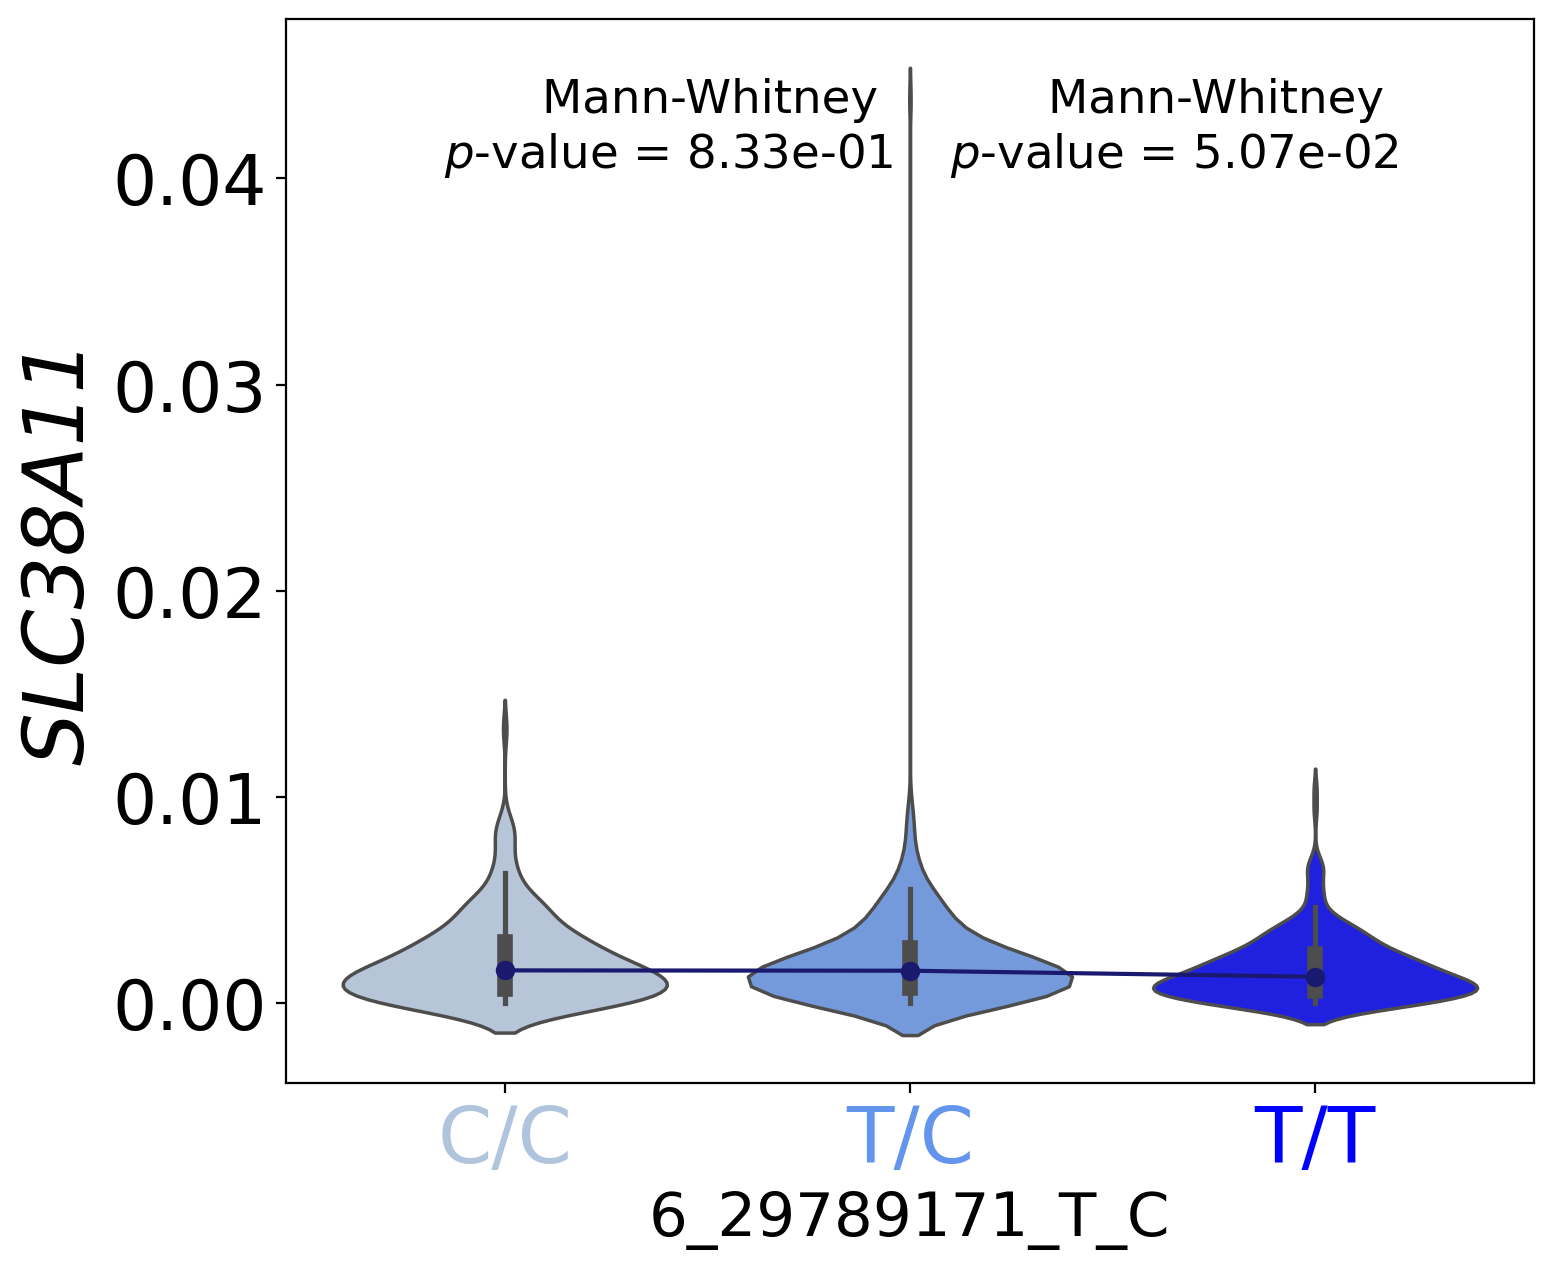

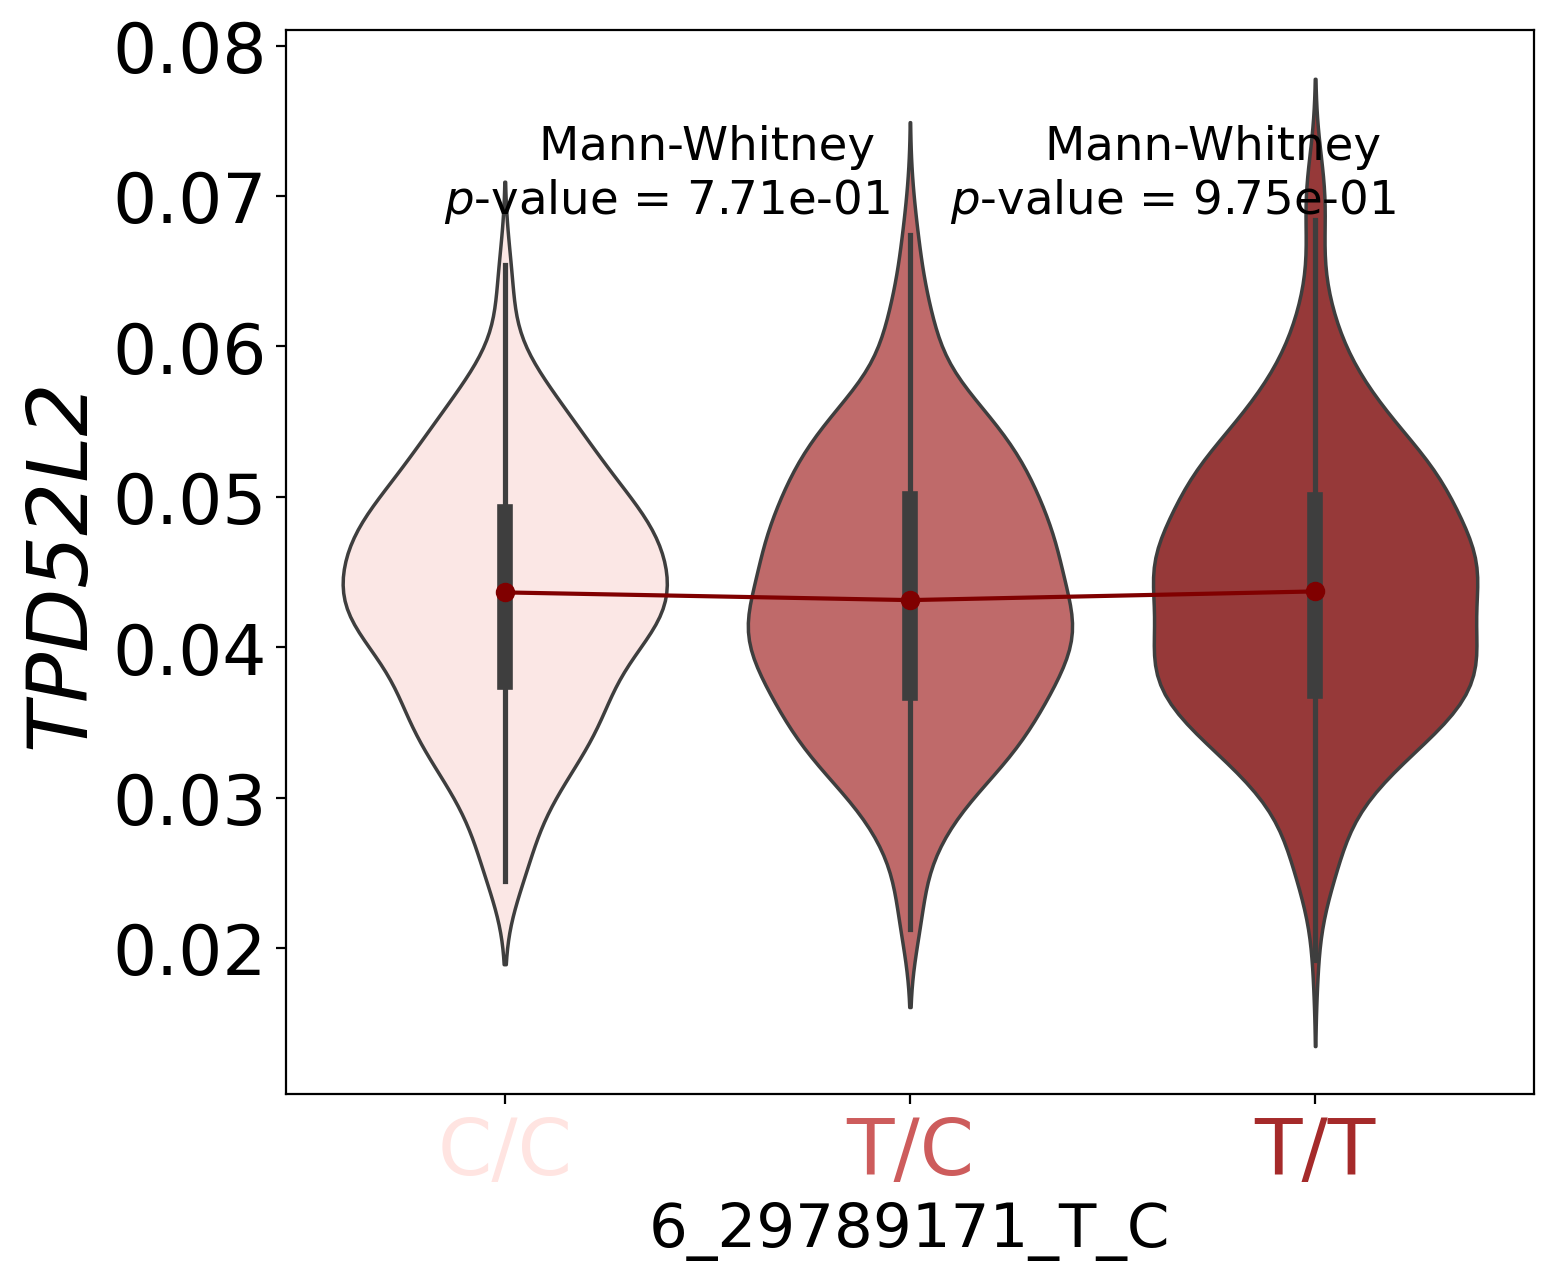

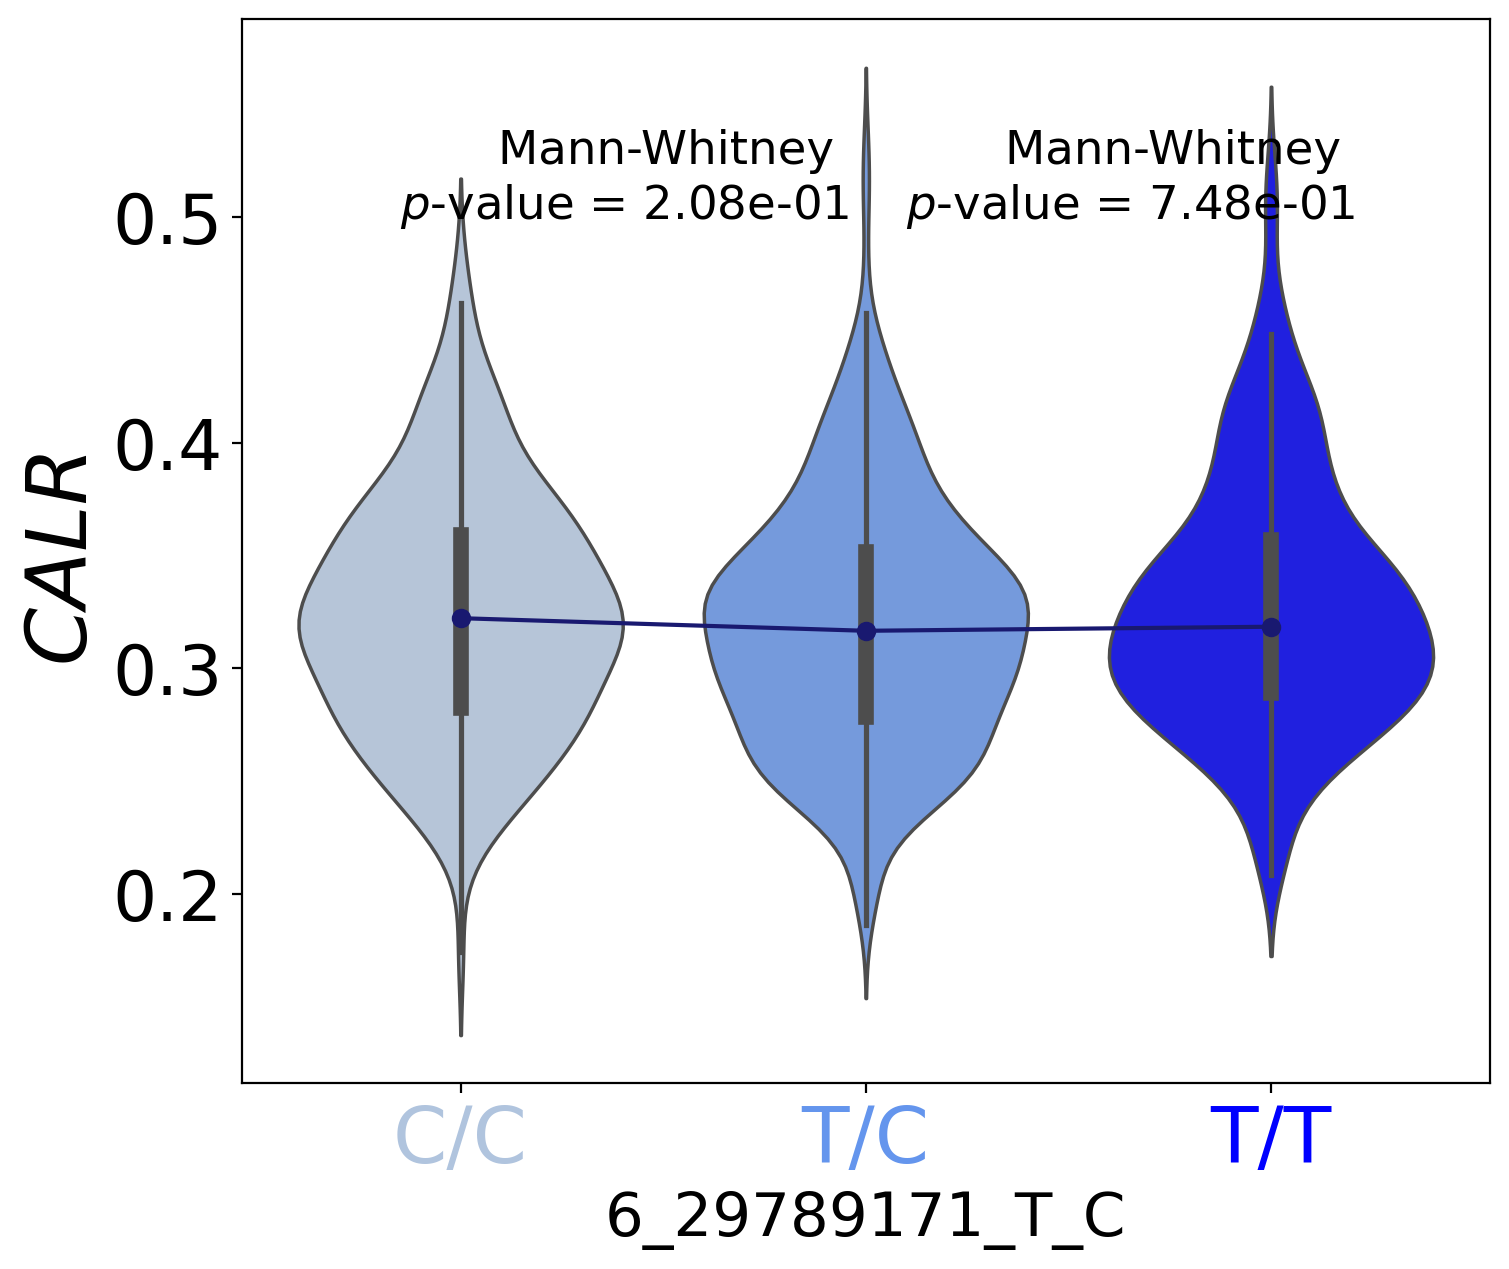

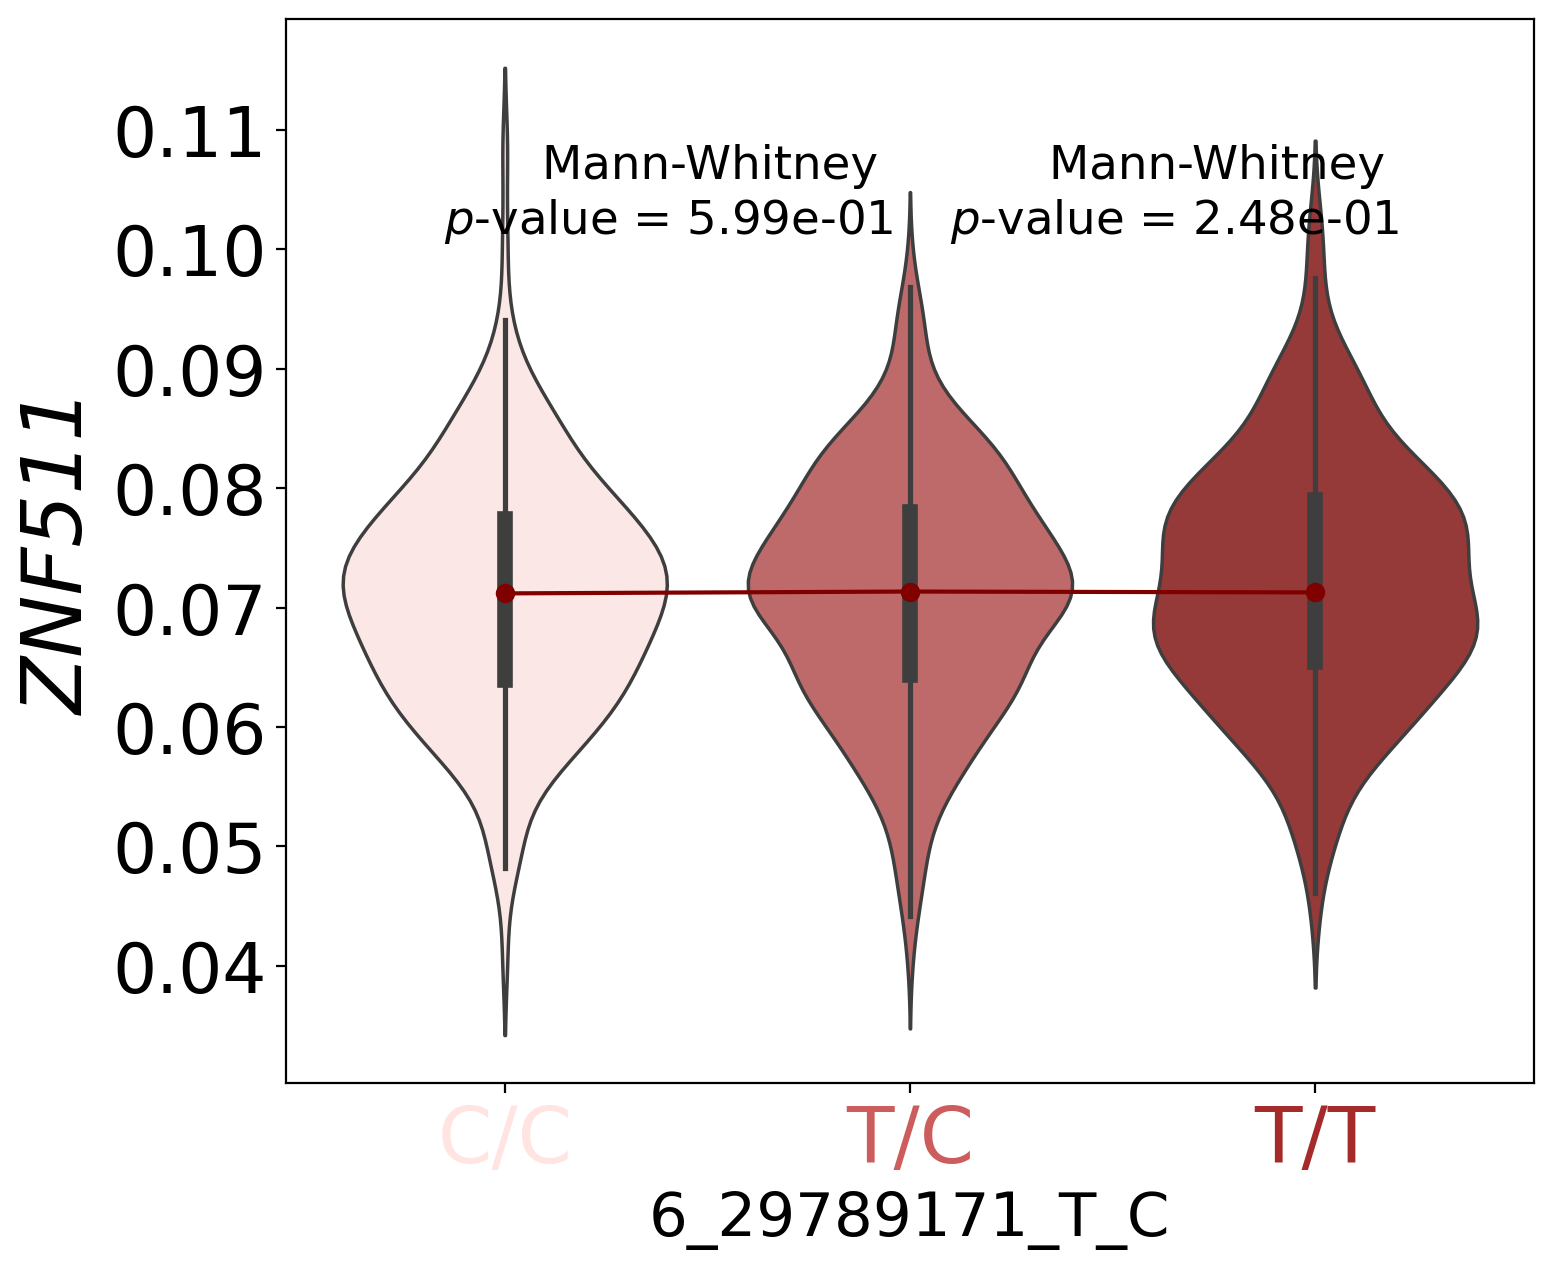

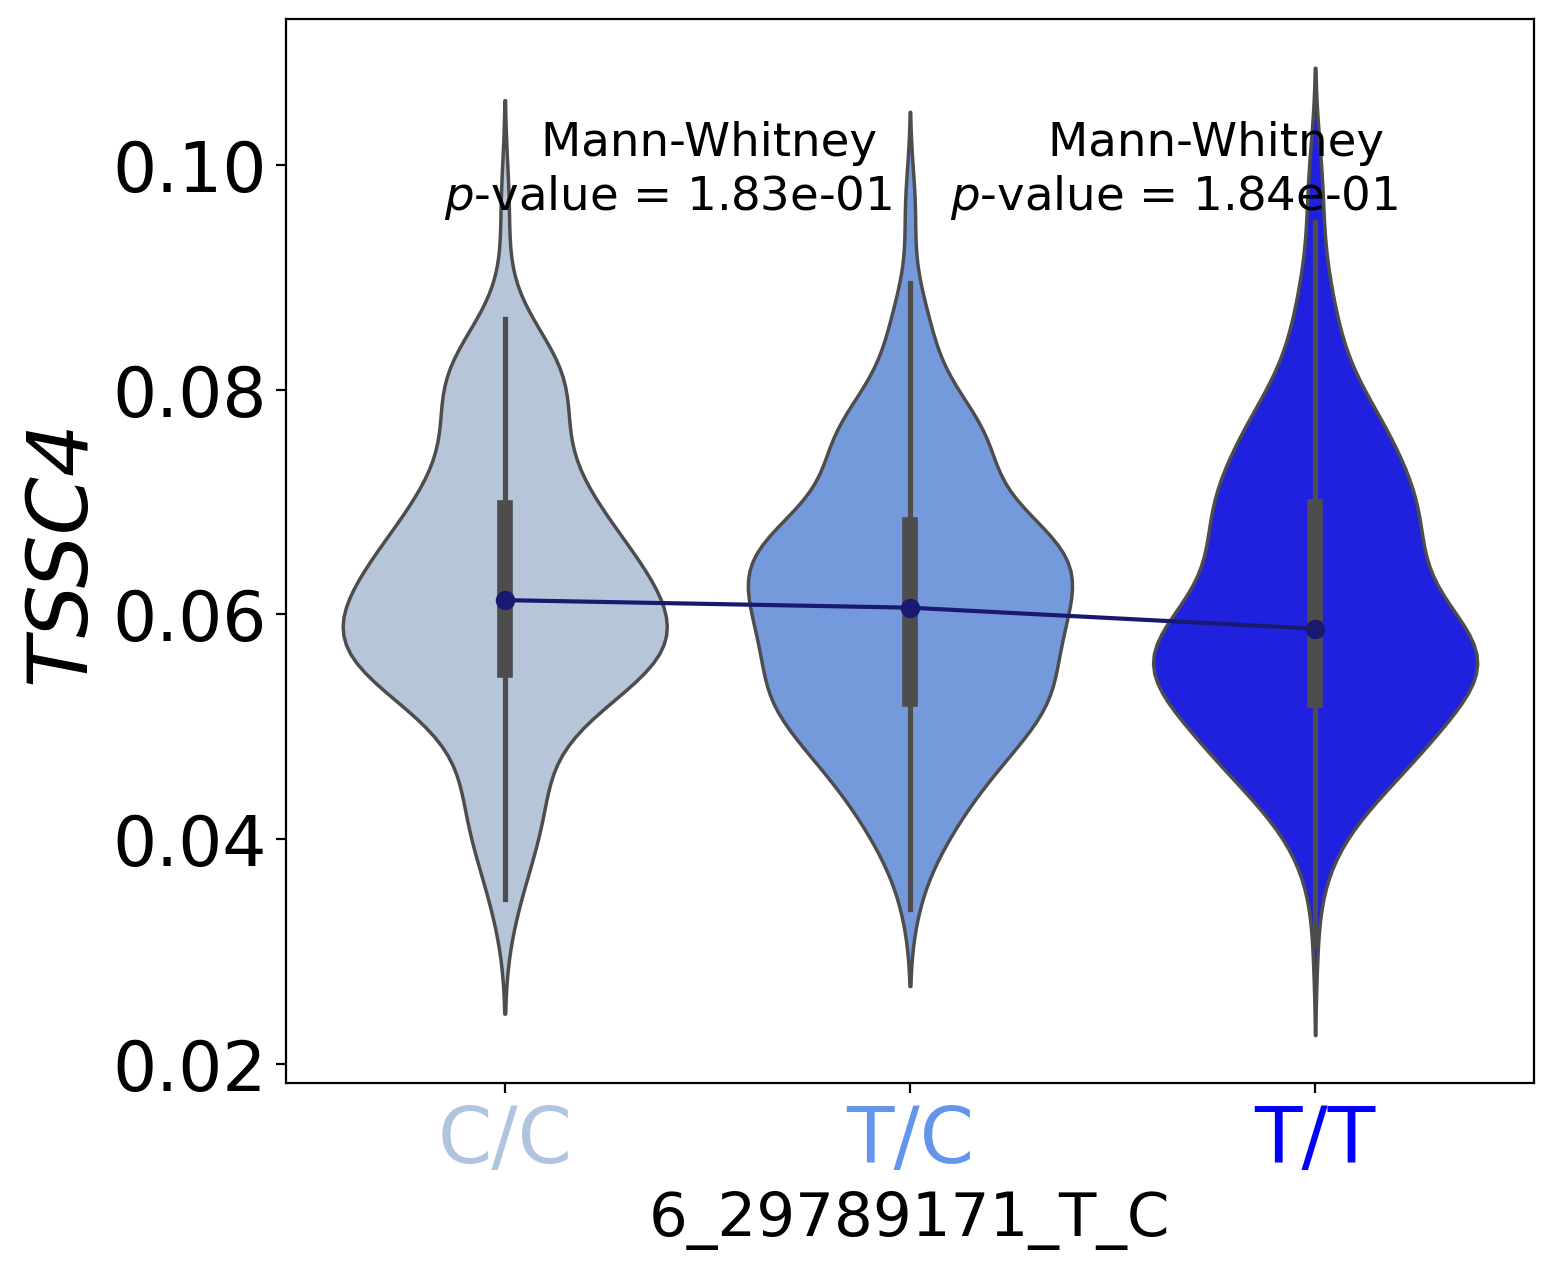

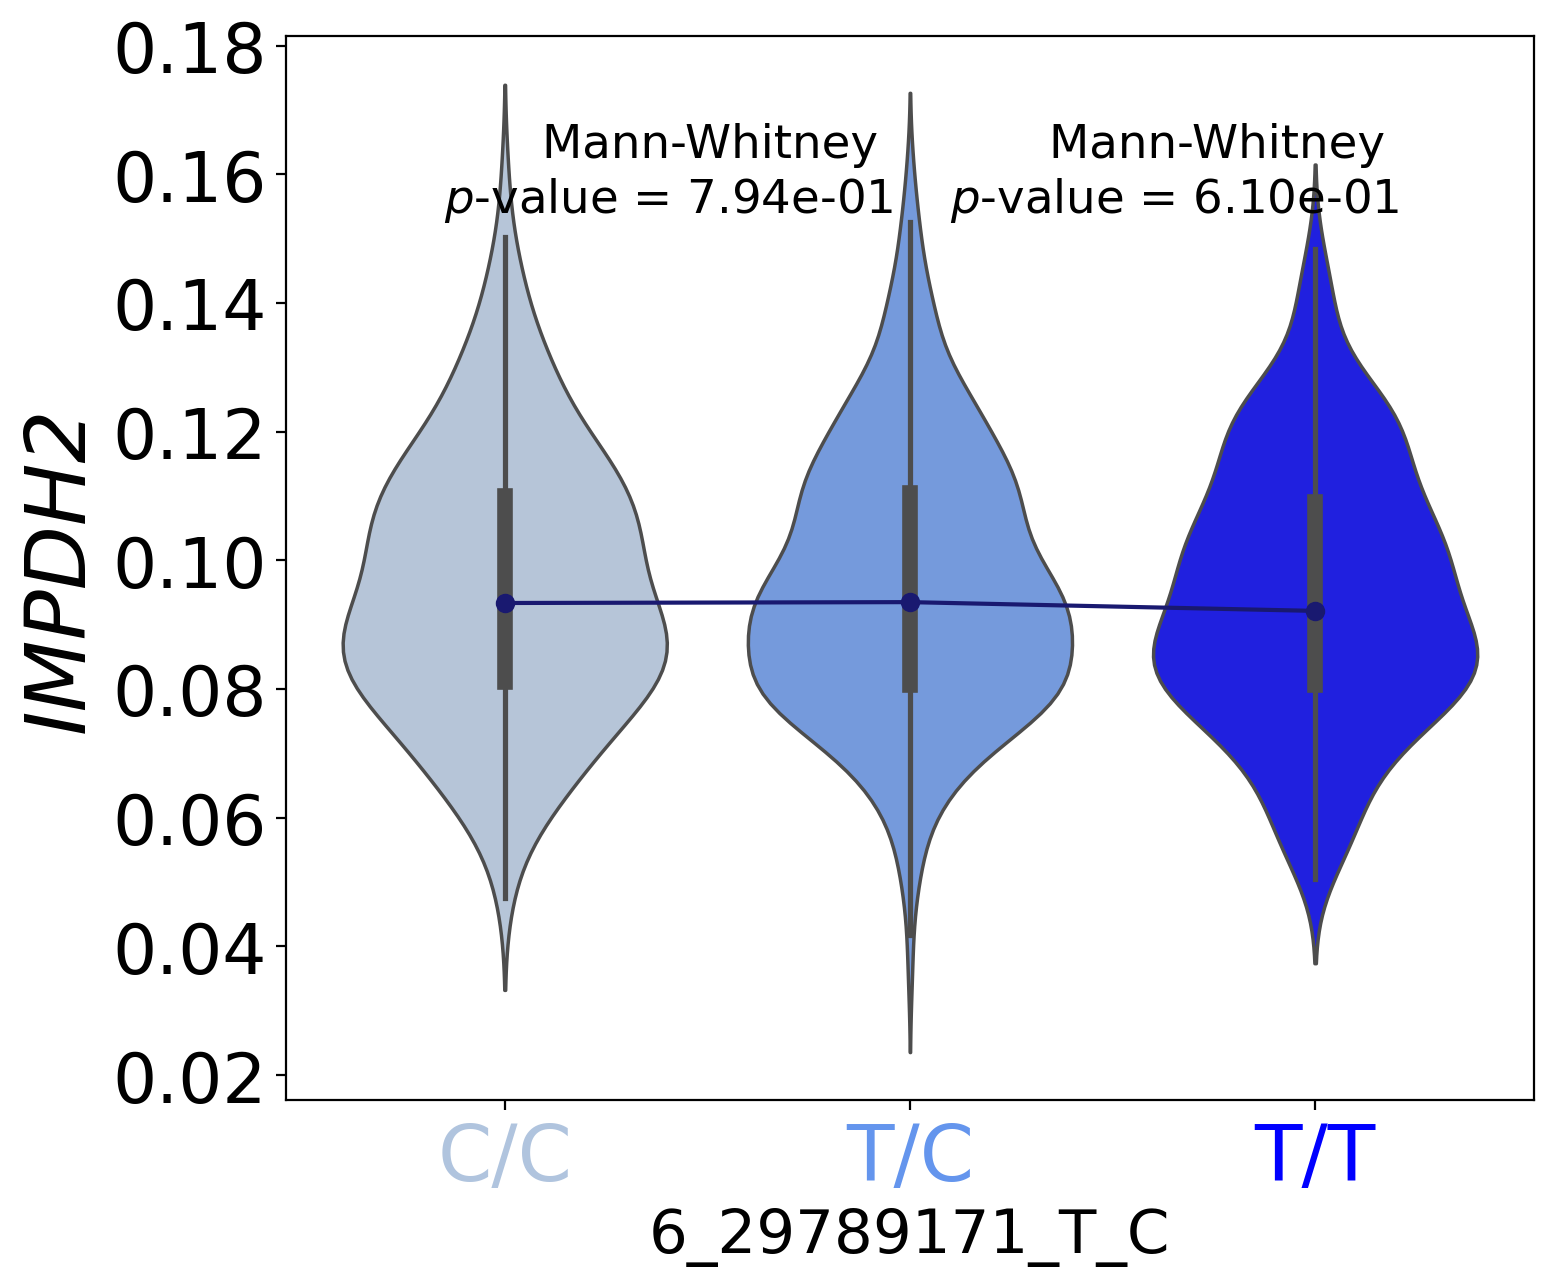

In [72]:
for g in eQTLGen_genes:
    plot_ct_gex_vs_gt(
        adata=adata,
        gene=g,
        filter_maf=False,
        annotation_fontsize=28,
        cell_indices=None,
        celltype=None,
        celltype_column="cell_label",
        iid_column="individual",
        GT_matrix=GT_matrix,
        SNP_id=SNP_dict_inv["6:29789171"],
        DxC_associations = GxC_effects,
        hgnc_column="GeneSymbol",
        savefig=True,
        output_dir=os.path.join(model_results_dir, "Figures"),
        format="pdf",
    )

/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2484: UserWarning: Neither `cell_indices` nor `celltype` were provided.
Aggregating gene expression over all cells.


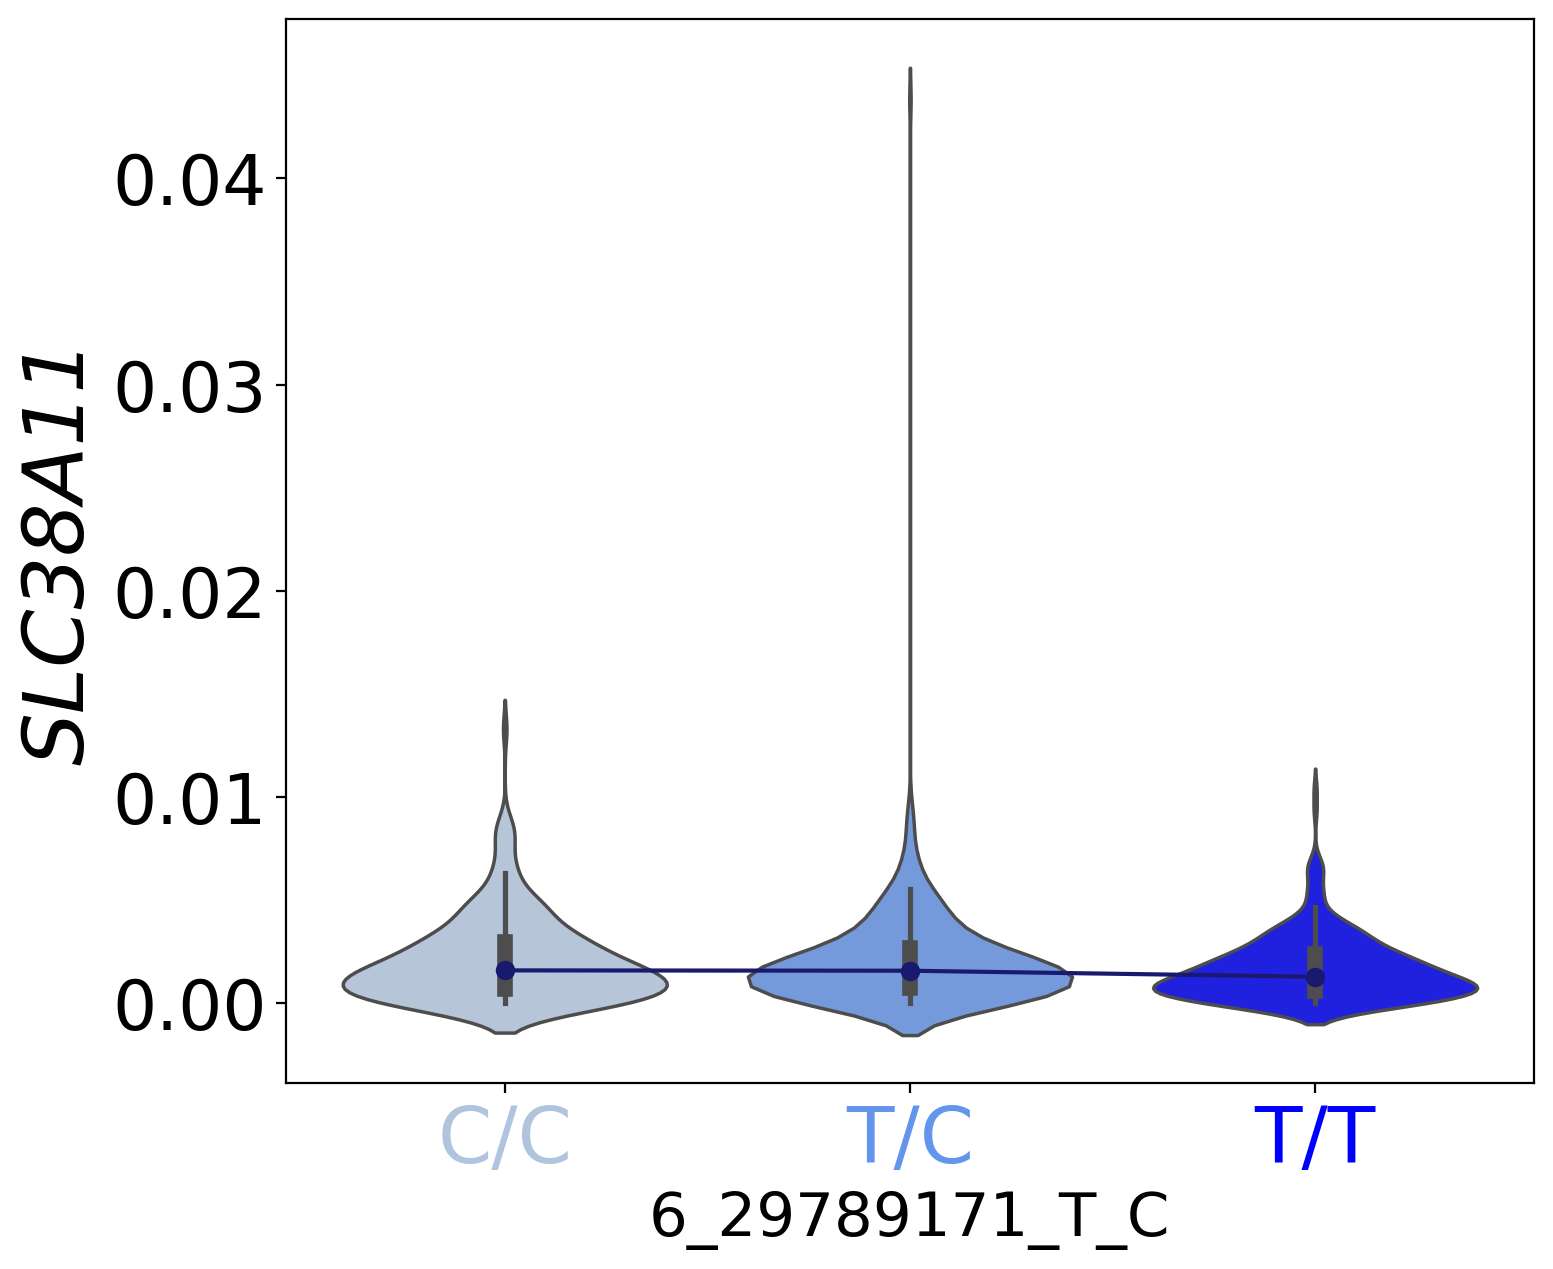

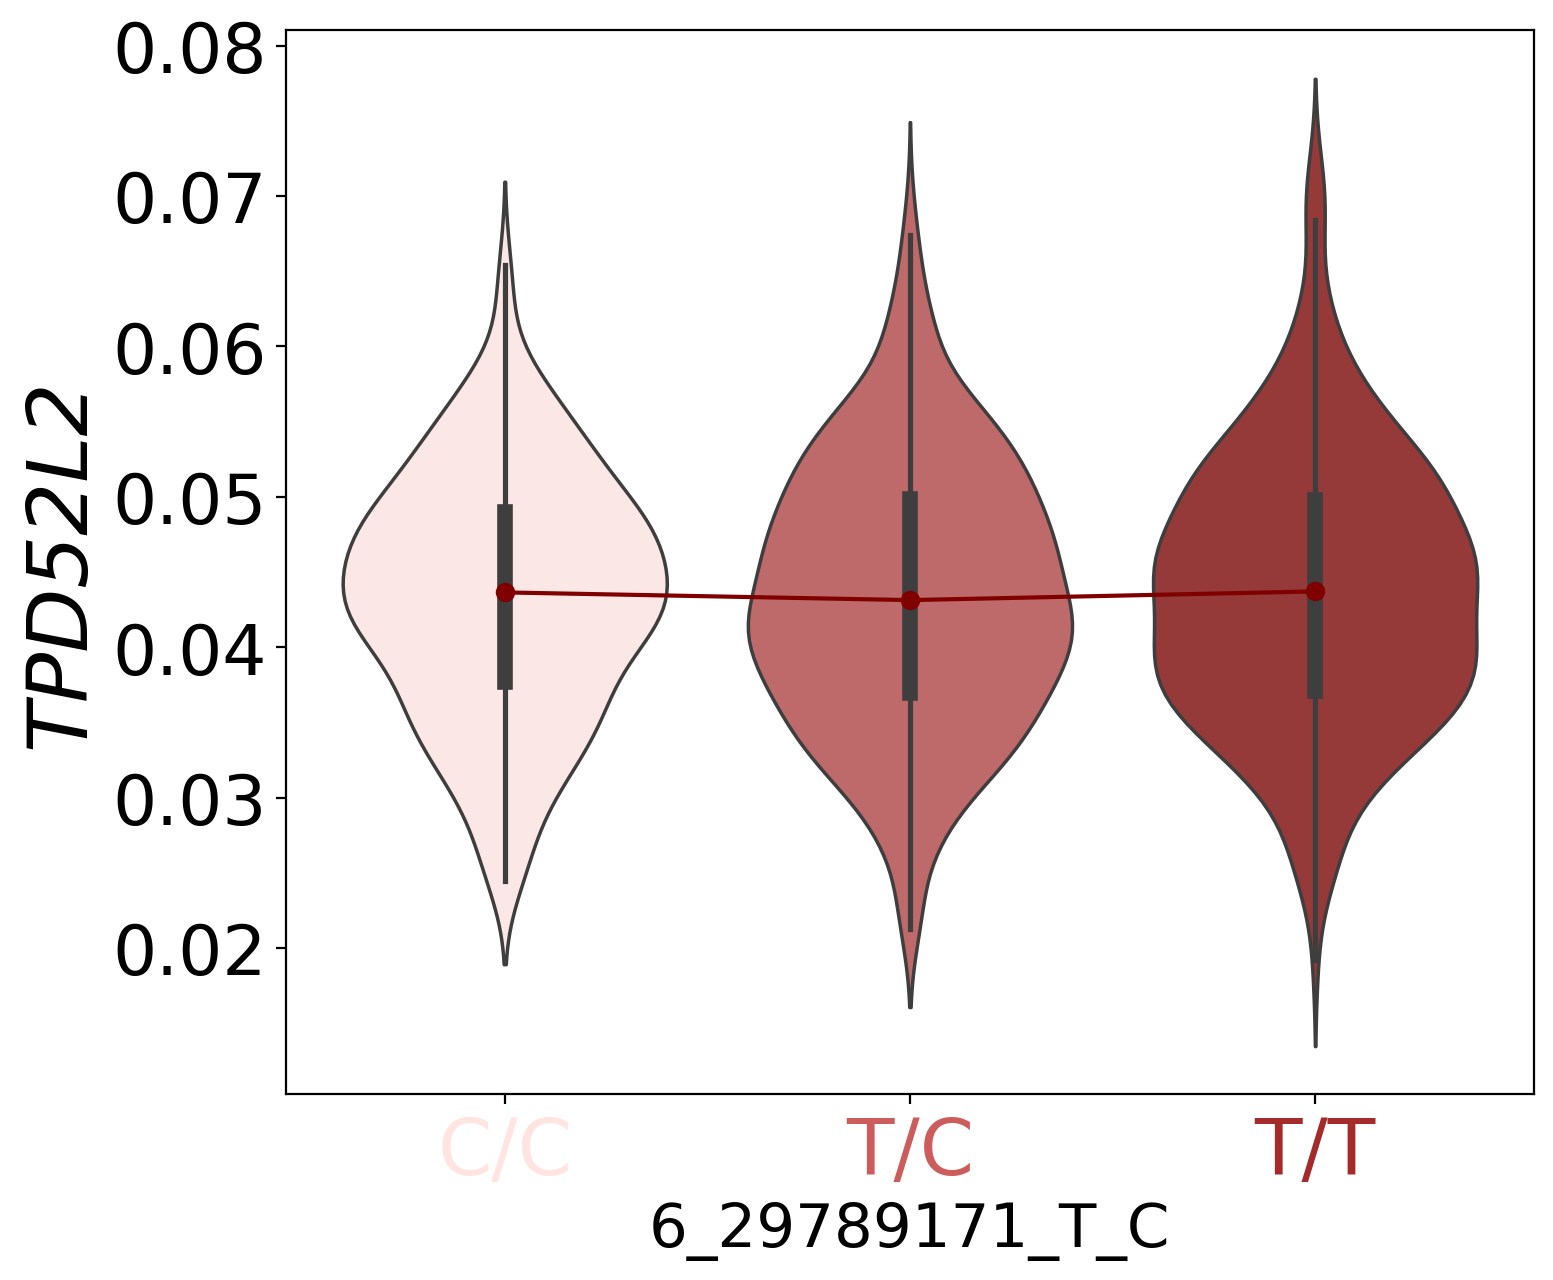

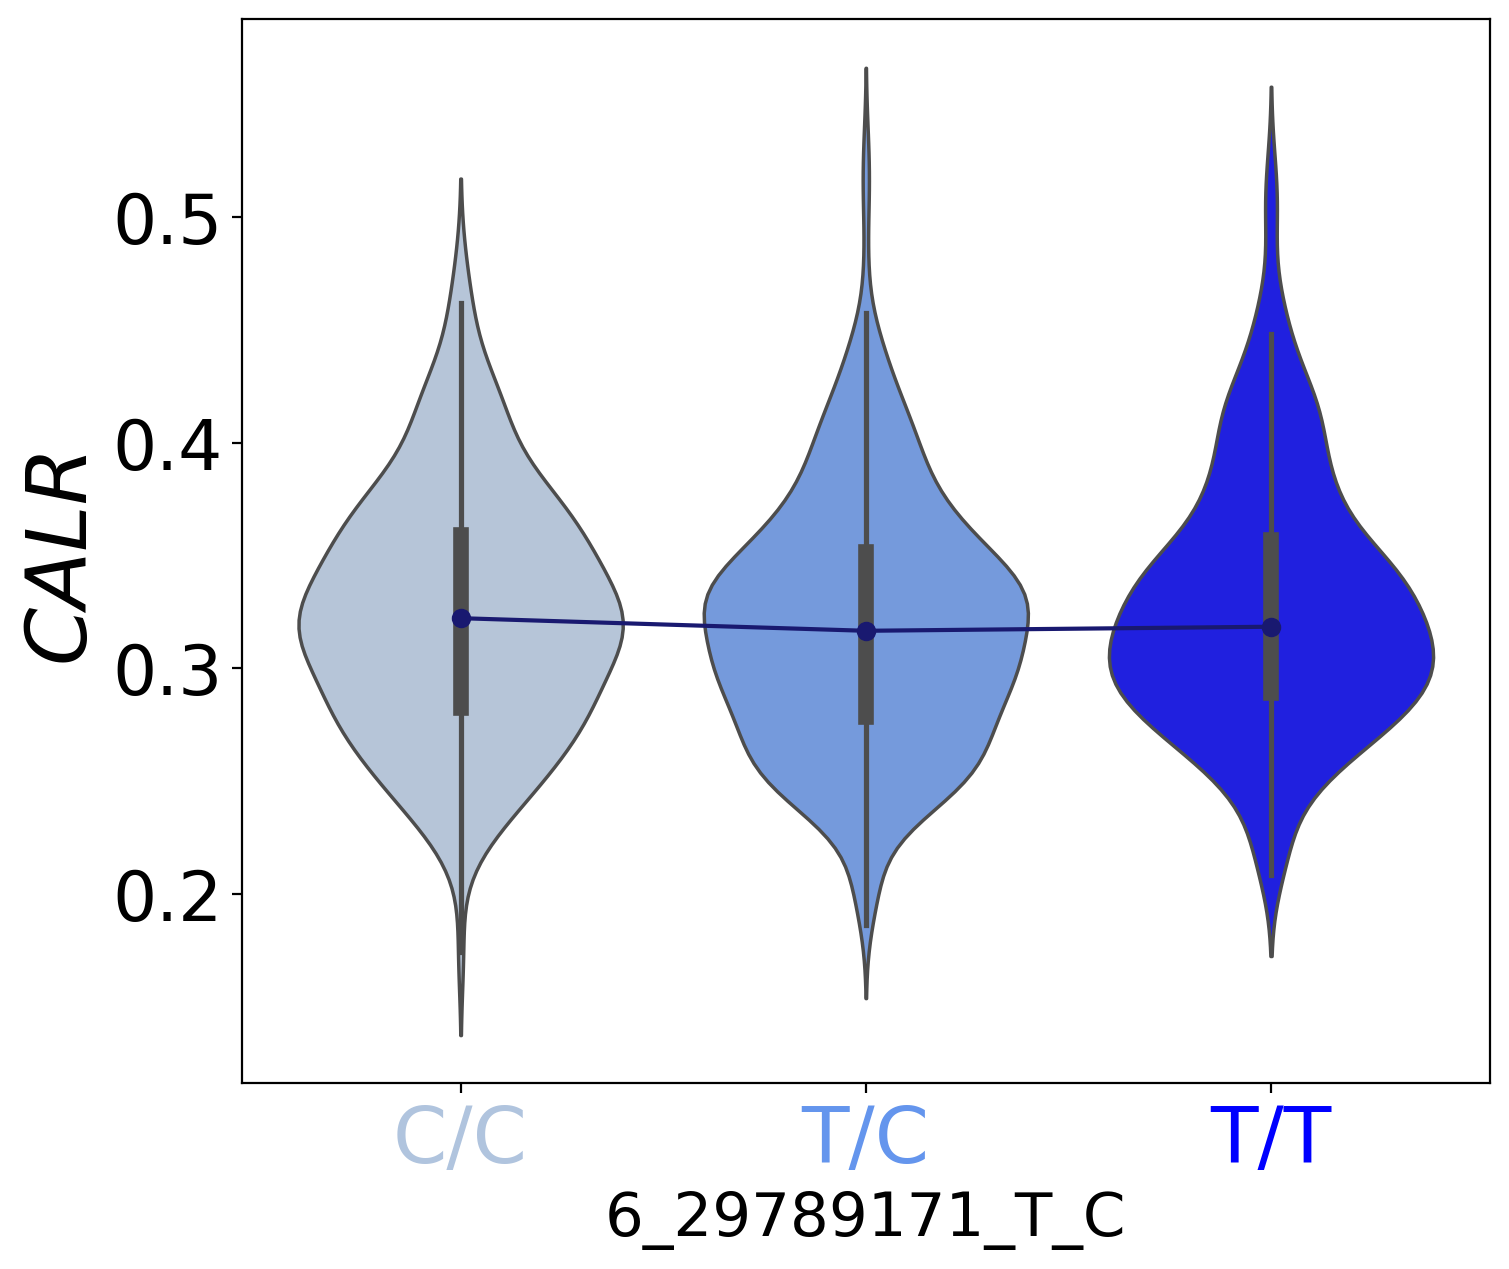

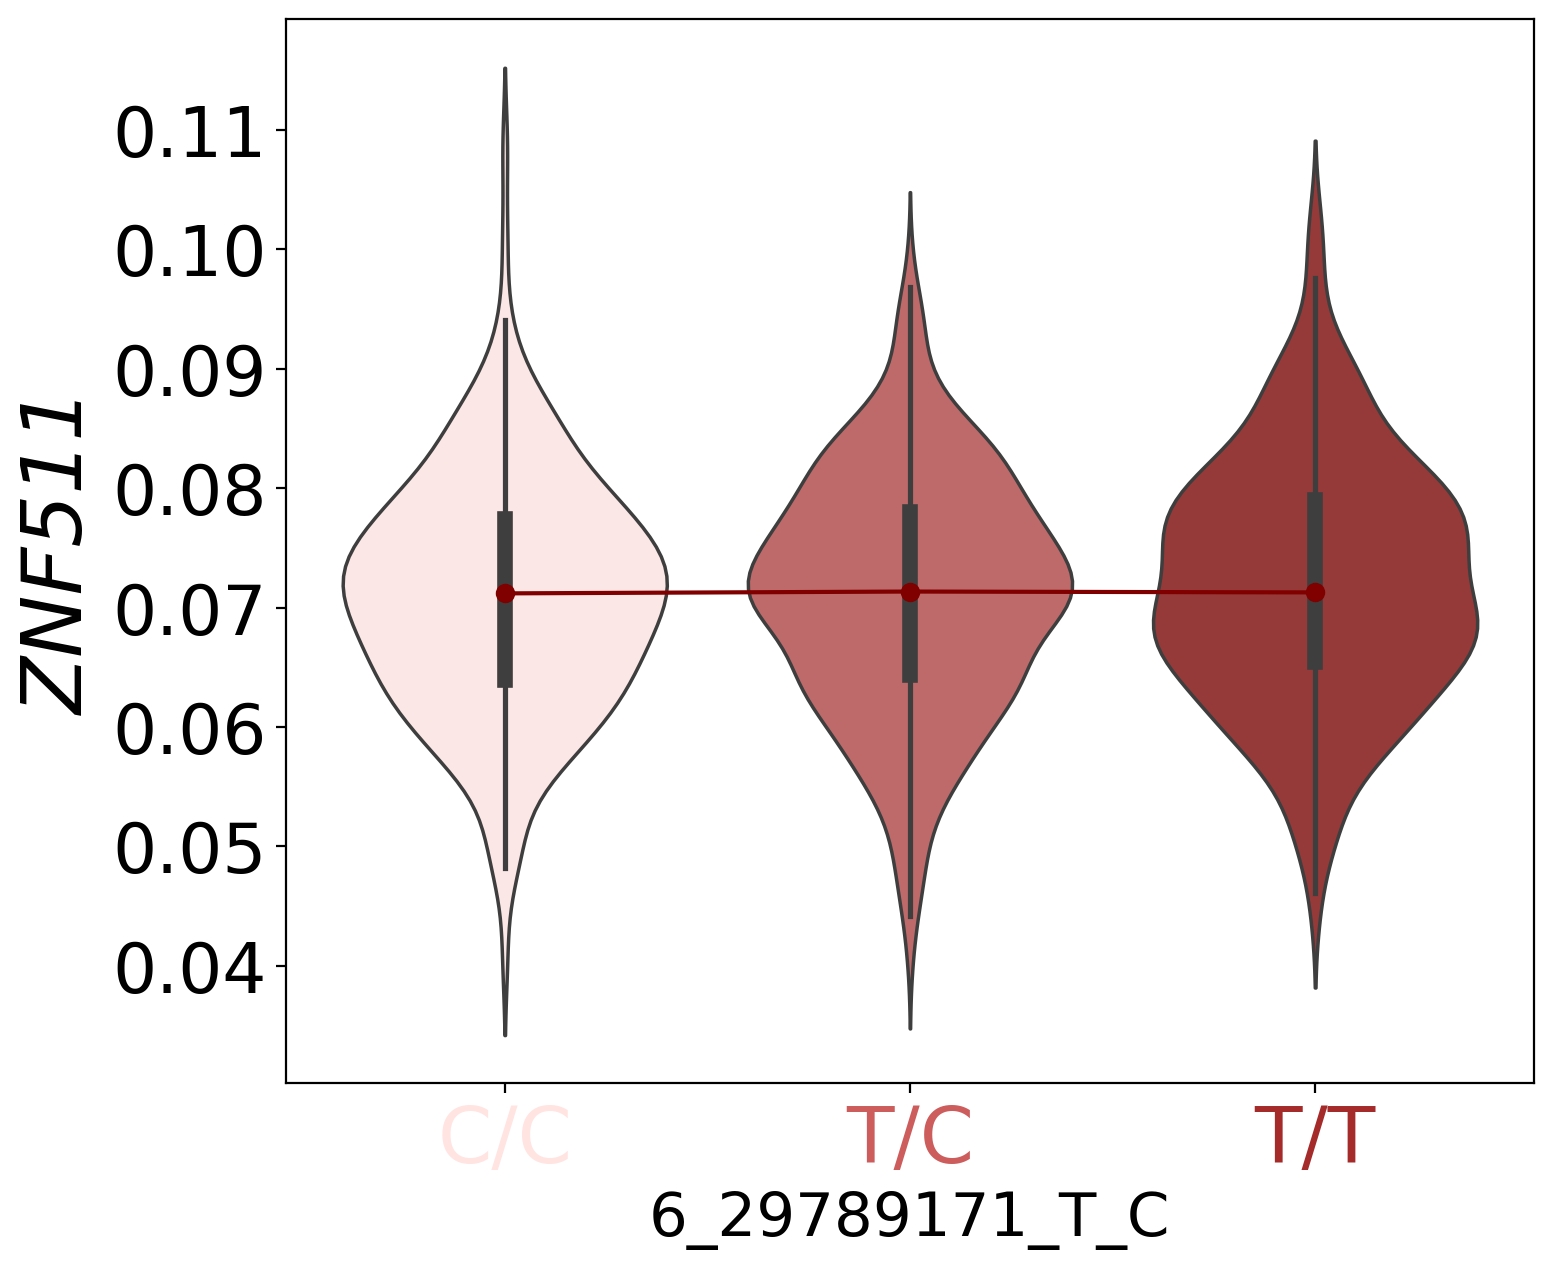

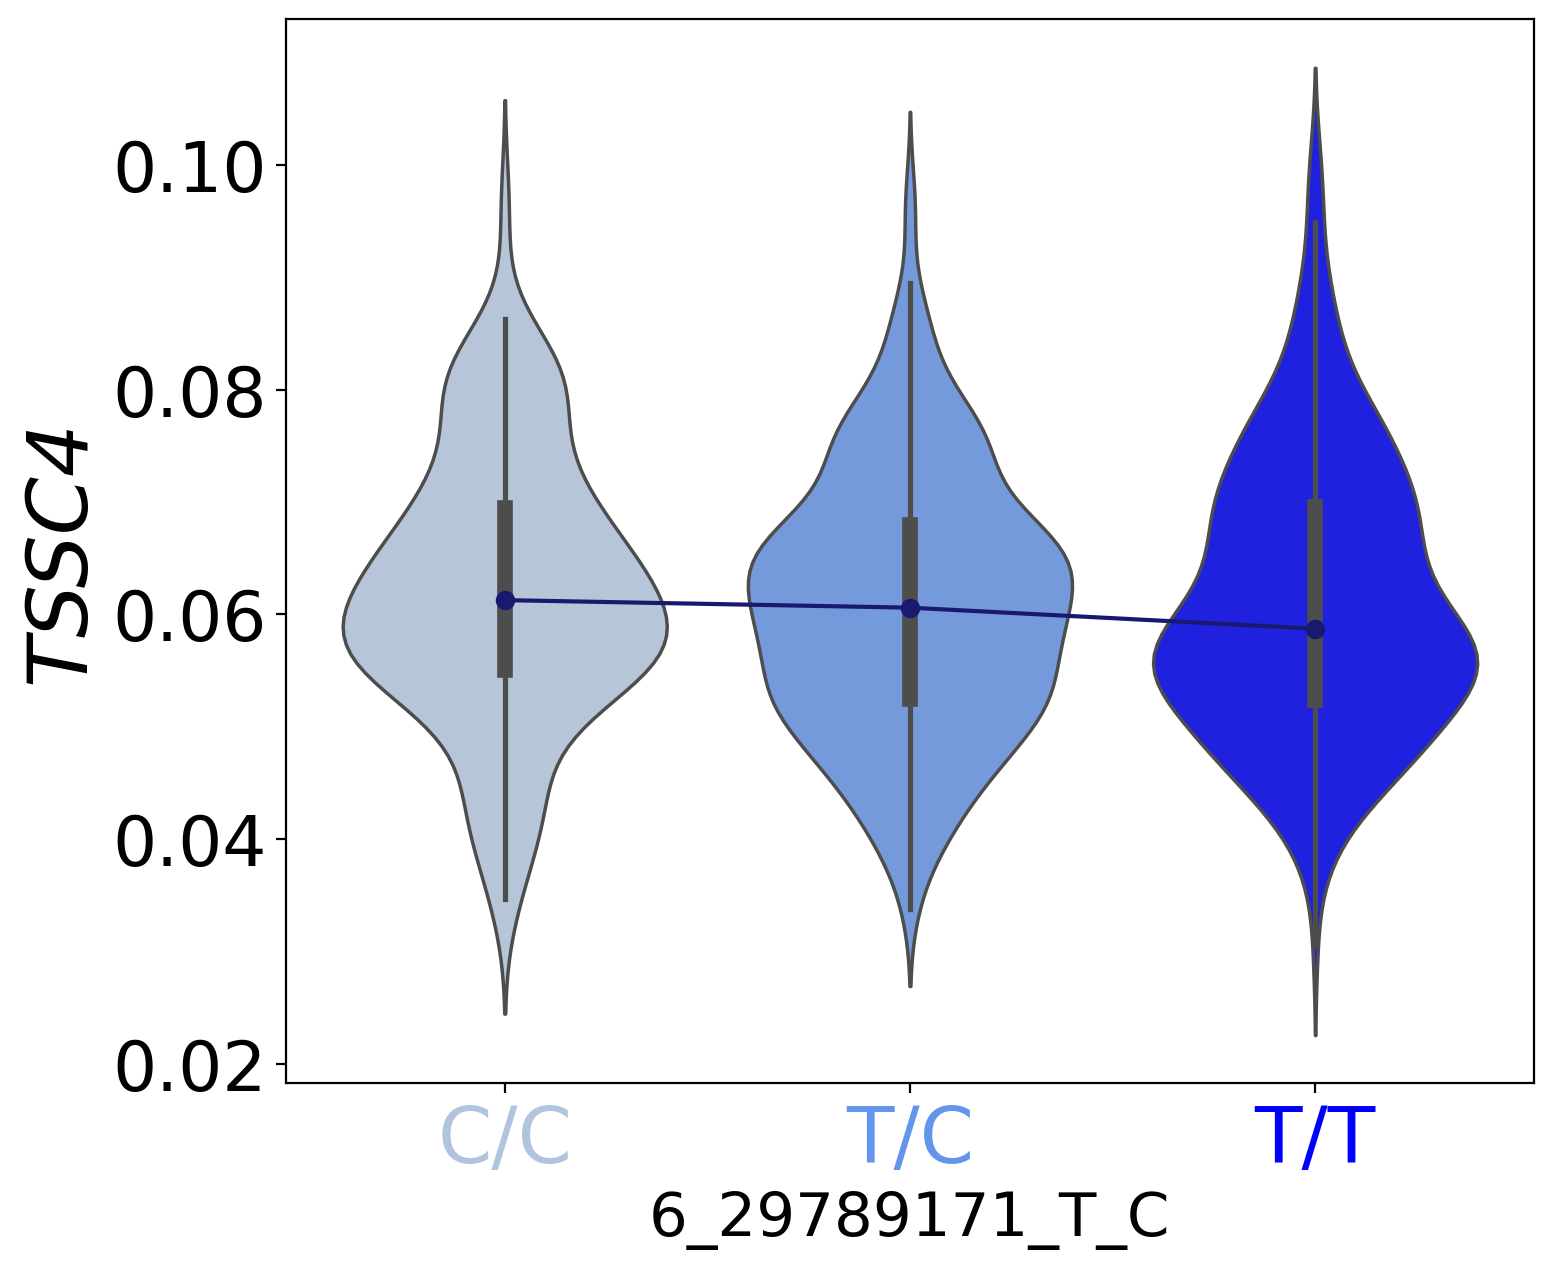

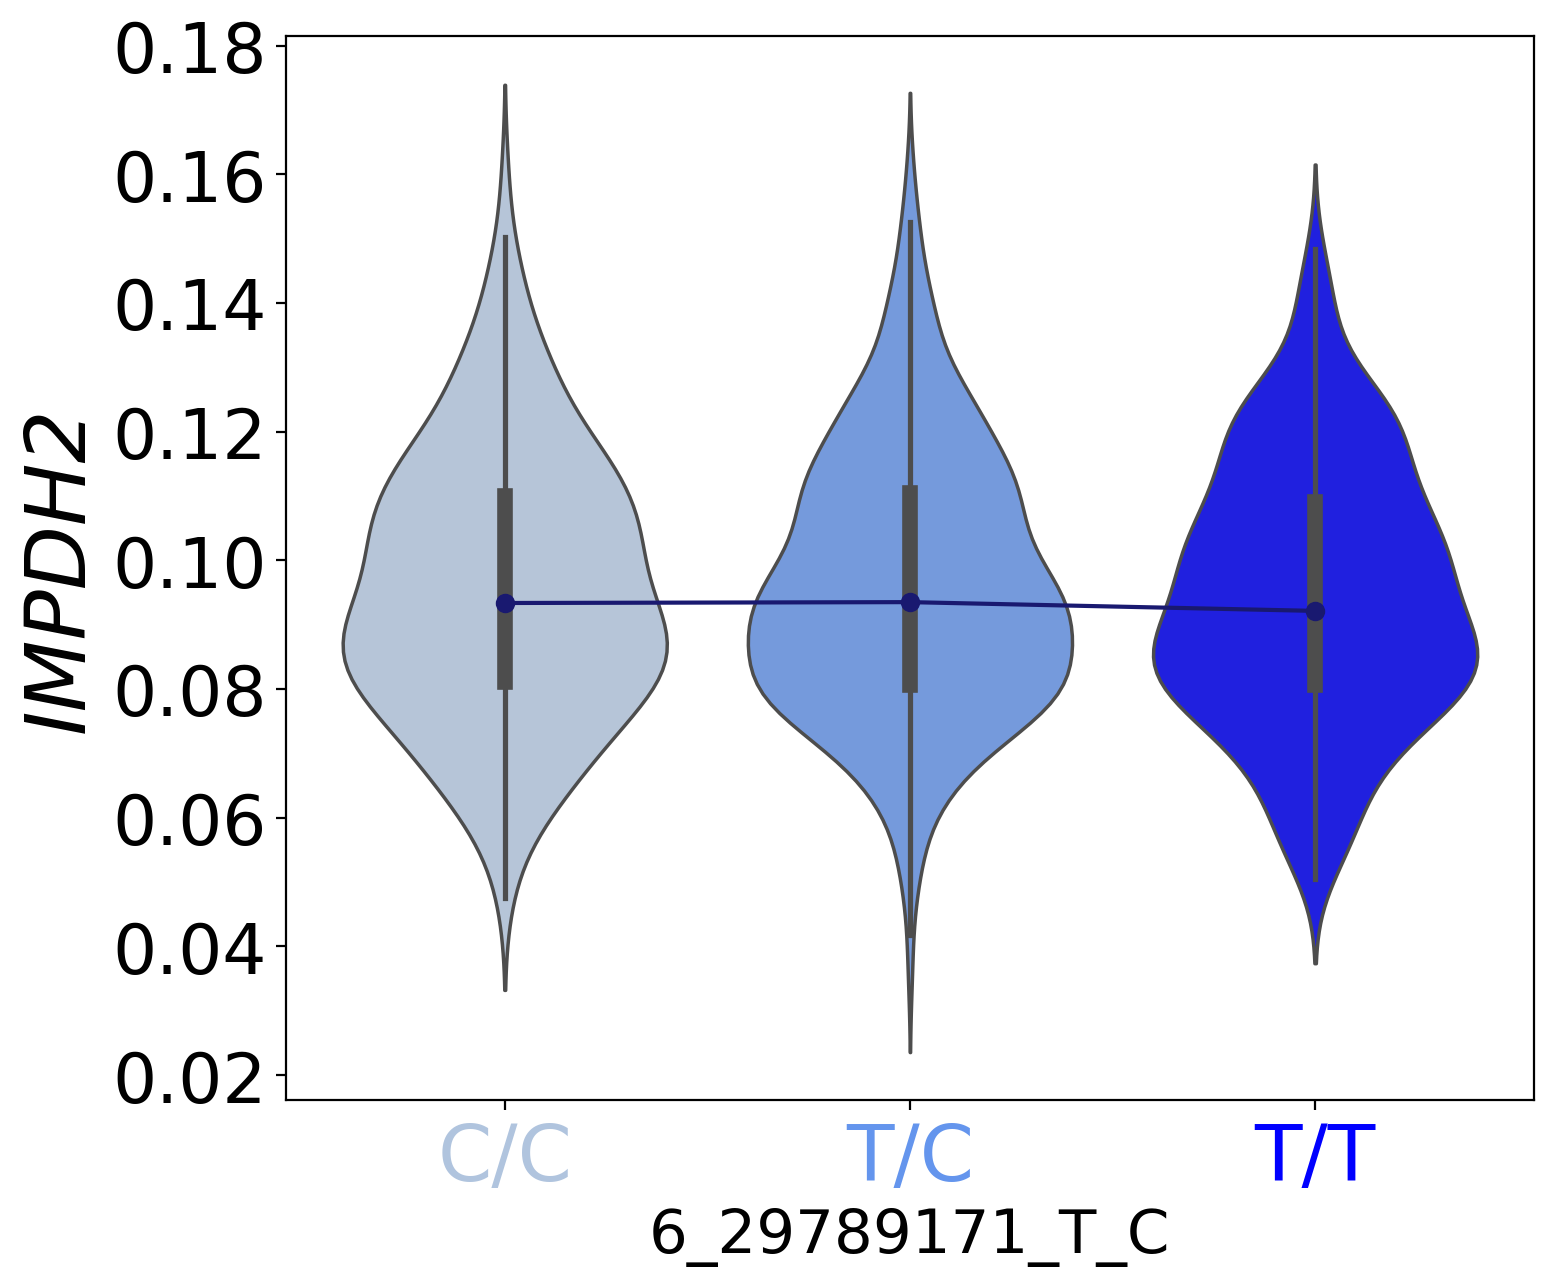

In [71]:
for g in eQTLGen_genes:
    plot_ct_gex_vs_gt(
        adata=adata,
        gene=g,
        filter_maf=False,
        test_gt_groups=False,
        annotation_fontsize=28,
        cell_indices=None,
        celltype=None,
        celltype_column="cell_label",
        iid_column="individual",
        GT_matrix=GT_matrix,
        SNP_id=SNP_dict_inv["6:29789171"],
        DxC_associations = GxC_effects,
        hgnc_column="GeneSymbol",
        savefig=True,
        output_dir=os.path.join(model_results_dir, "Figures"),
        output_prefix="WO-Mann-Whitney",
        format="pdf",
    )

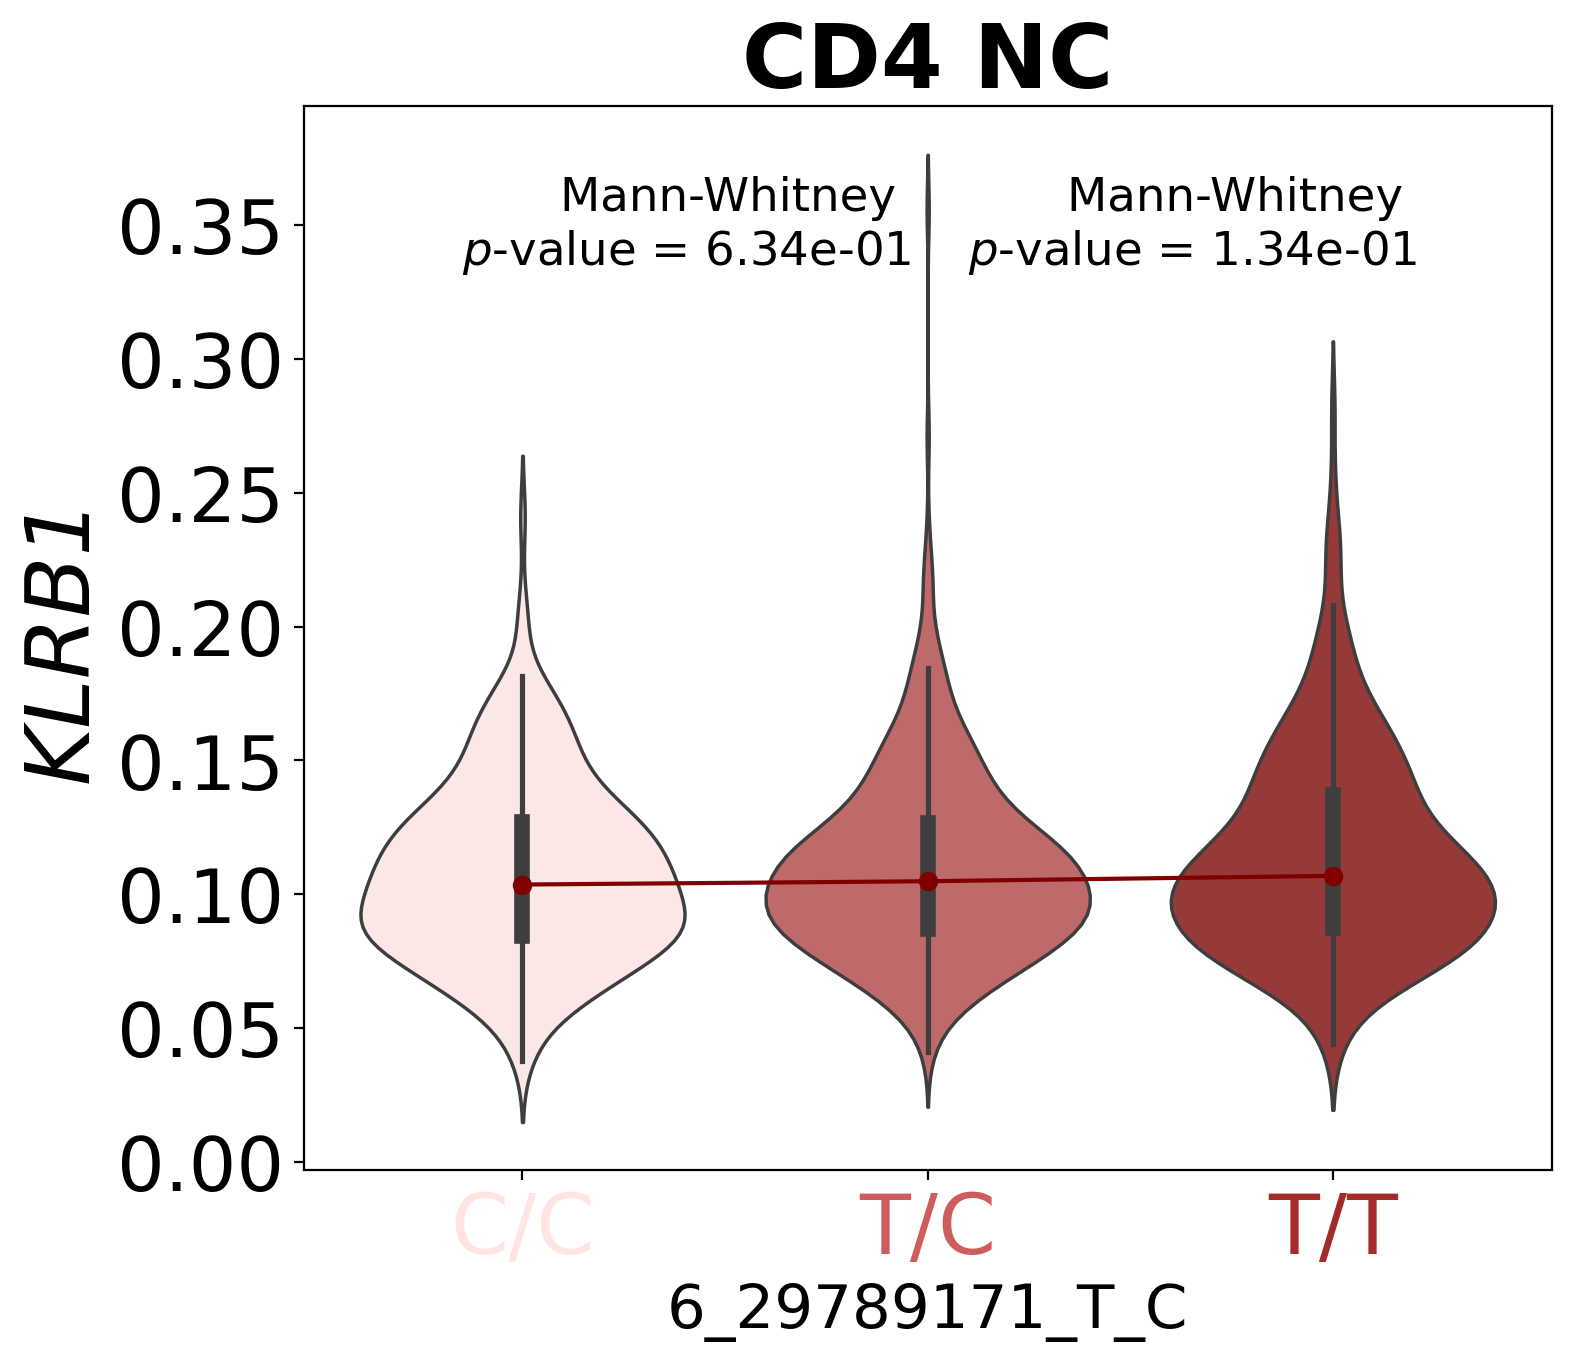

In [38]:
plot_ct_gex_vs_gt(
    adata=adata,
    gene="ENSG00000111796",
    annotation_fontsize=30,
    cell_indices=None,
    celltype=["CD4 NC"],
    celltype_column="cell_label",
    iid_column="individual",
    GT_matrix=GT_matrix,
    SNP_id=SNP_dict_inv["6:29789171"],
    DxC_associations = GxC_effects,
    hgnc_column="GeneSymbol",
    savefig=True,
    output_dir=os.path.join(model_results_dir, "Figures"),
    format="png",
)

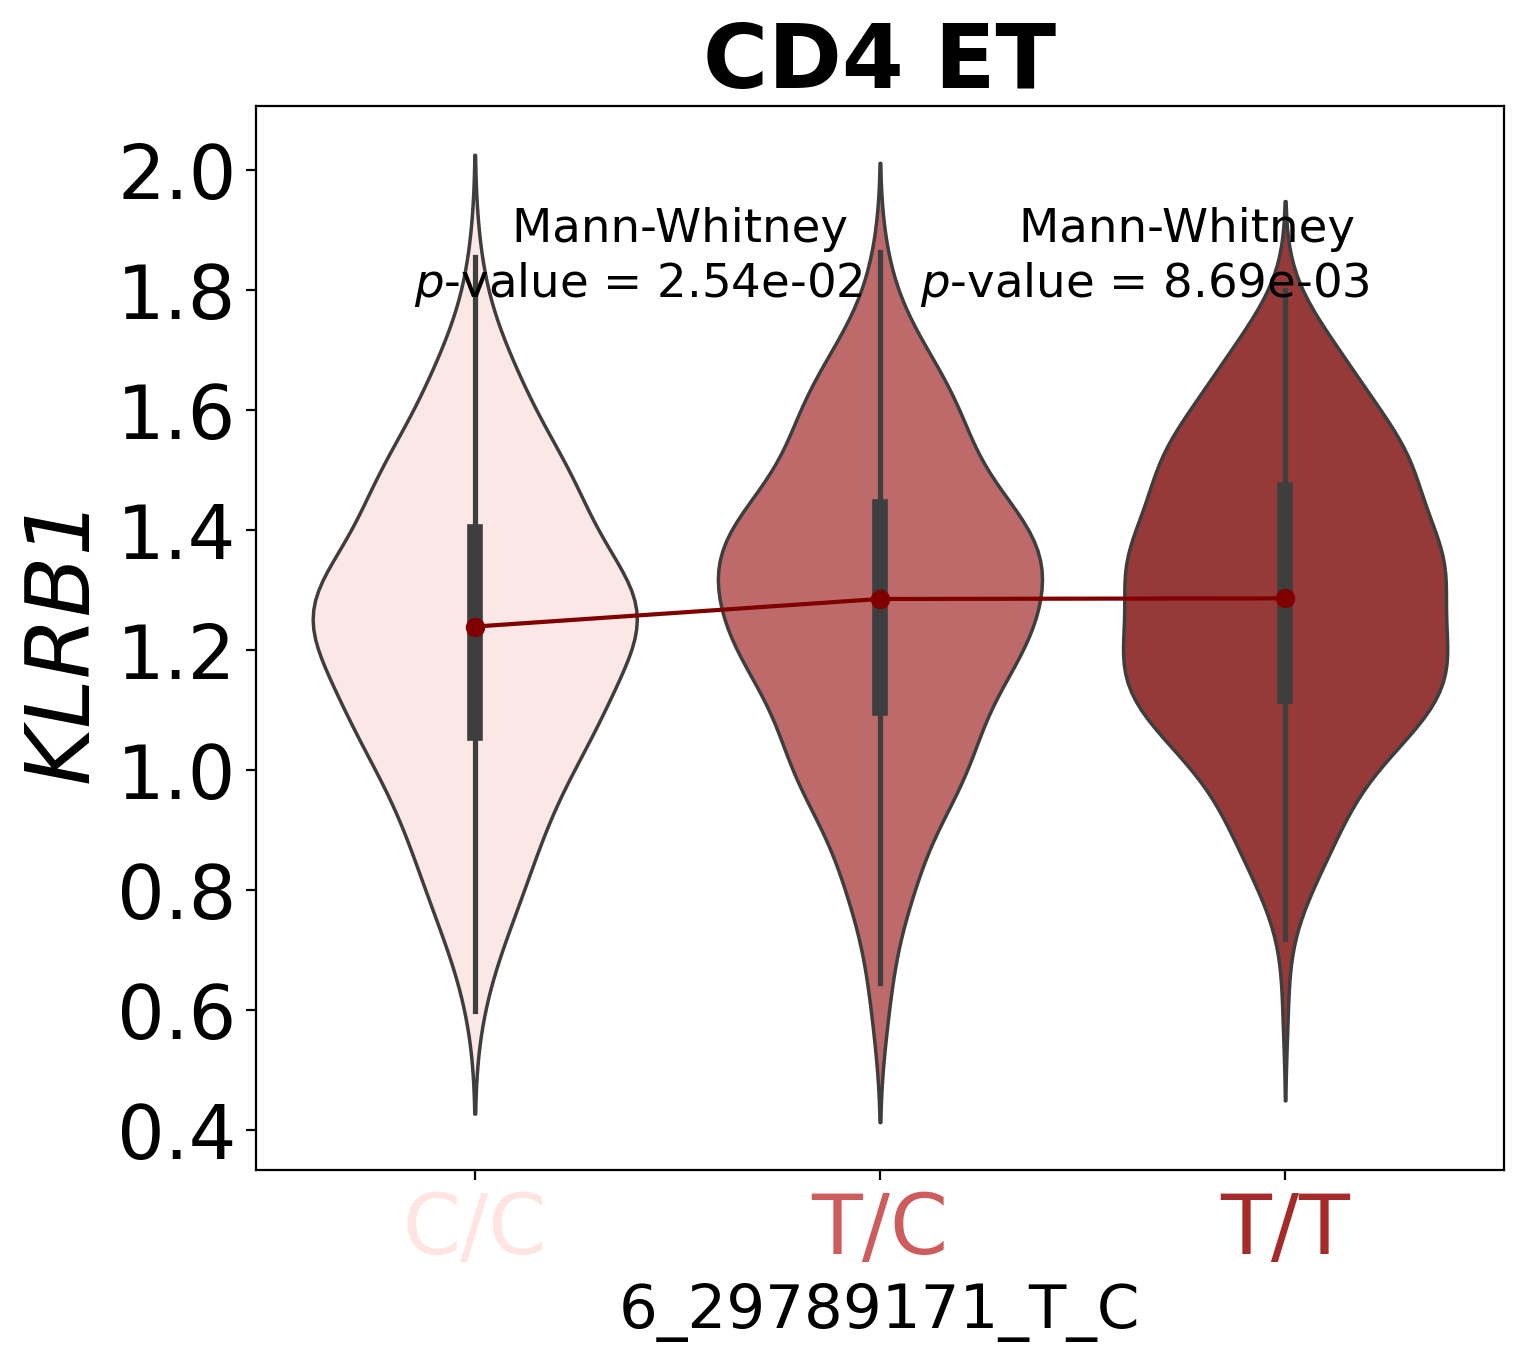

In [37]:
plot_ct_gex_vs_gt(
    adata=adata,
    gene="ENSG00000111796",
    annotation_fontsize=30,
    cell_indices=None,
    celltype=["CD4 ET"],
    celltype_column="cell_label",
    iid_column="individual",
    GT_matrix=GT_matrix,
    SNP_id=SNP_dict_inv["6:29789171"],
    DxC_associations = GxC_effects,
    hgnc_column="GeneSymbol",
    savefig=True,
    output_dir=os.path.join(model_results_dir, "Figures"),
    format="png",
)

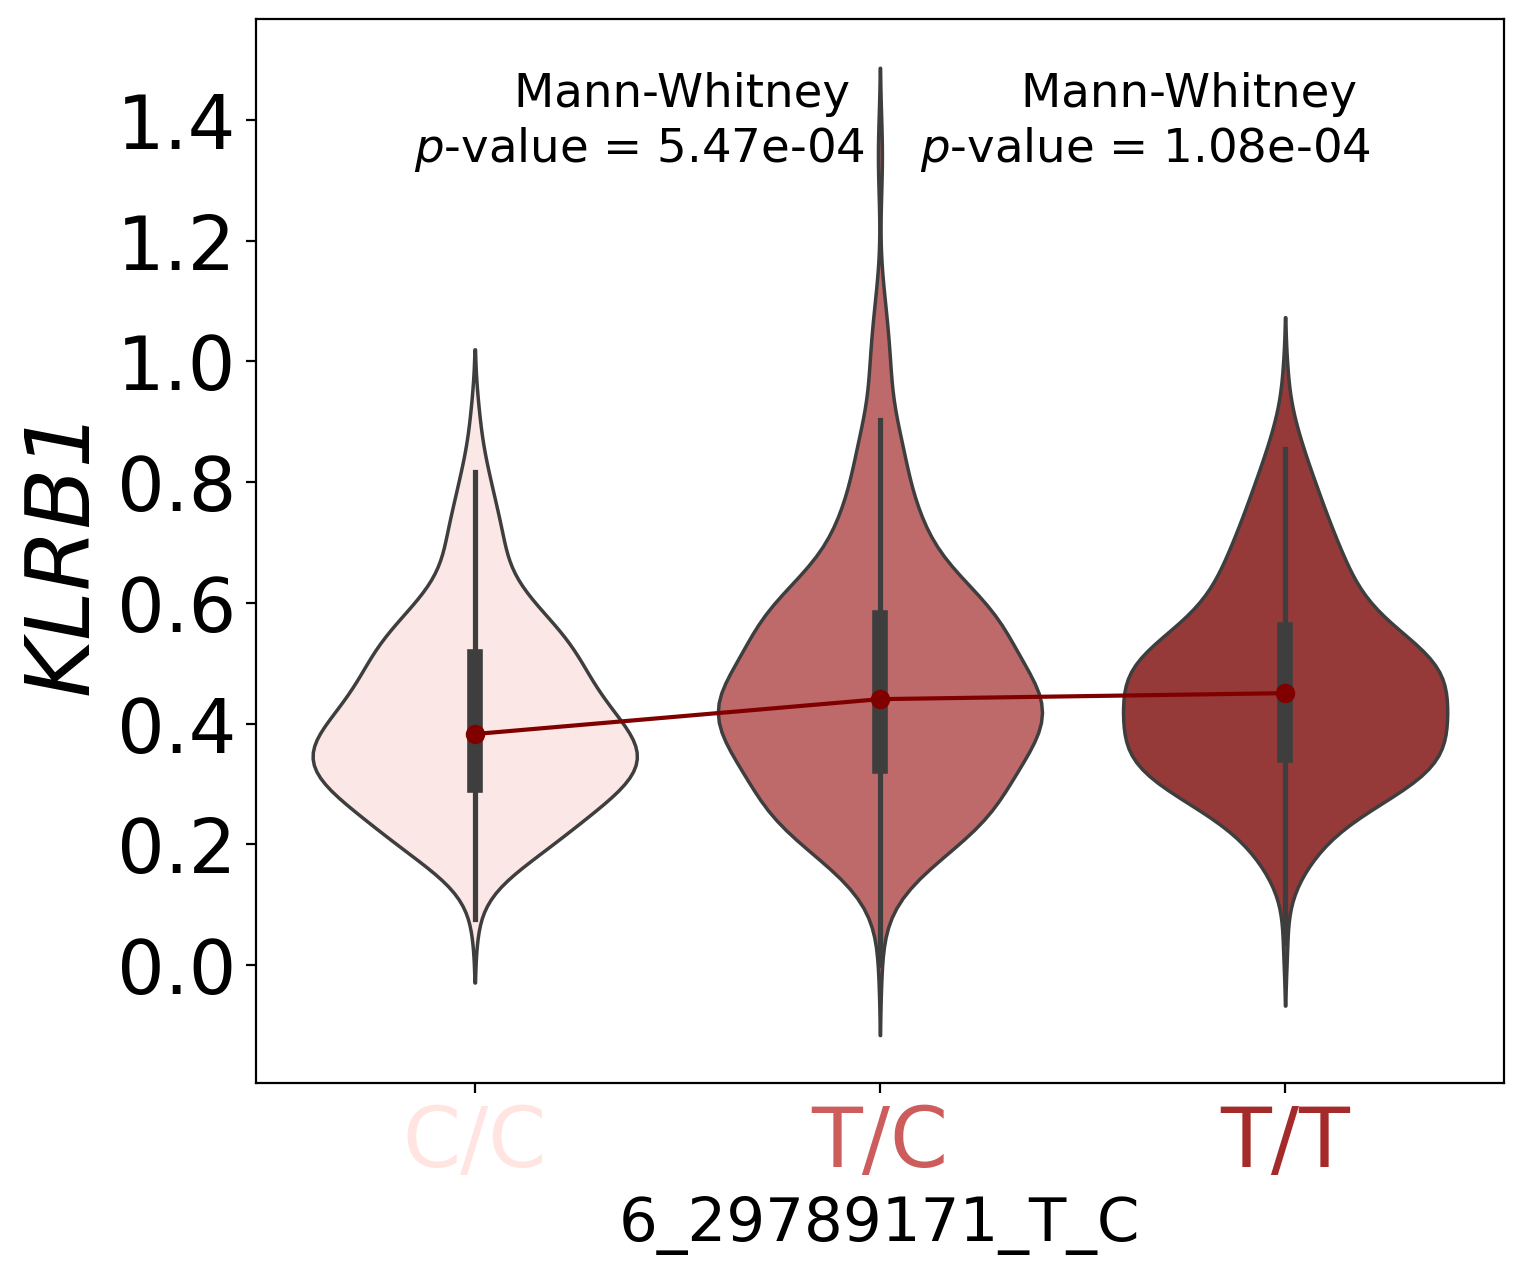

In [131]:
# LIVI cells
plot_ct_gex_vs_gt(
    adata=adata,
    gene="ENSG00000111796",
    annotation_fontsize=30,
    cell_indices=DxC_beta.loc[DxC_beta["DxC_Factor287"] > 0.05].index,
    celltype=None,
    celltype_column="cell_label",
    iid_column="individual",
    GT_matrix=GT_matrix,
    SNP_id=SNP_dict_inv["6:29789171"],
    DxC_associations = GxC_effects,
    hgnc_column="GeneSymbol",
    savefig=True,
    output_dir=os.path.join(model_results_dir, "Figures"),
    output_prefix="DxC287-005-cells",
    format="eps",
)

In [80]:
adata[DxC_beta.loc[DxC_beta["DxC_Factor287"] > 0.05].index, :].write("/data/danai/Data/OneK1K/LIVI_cells_6-29789171_DxC287_005-cutoff.h5ad")

/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


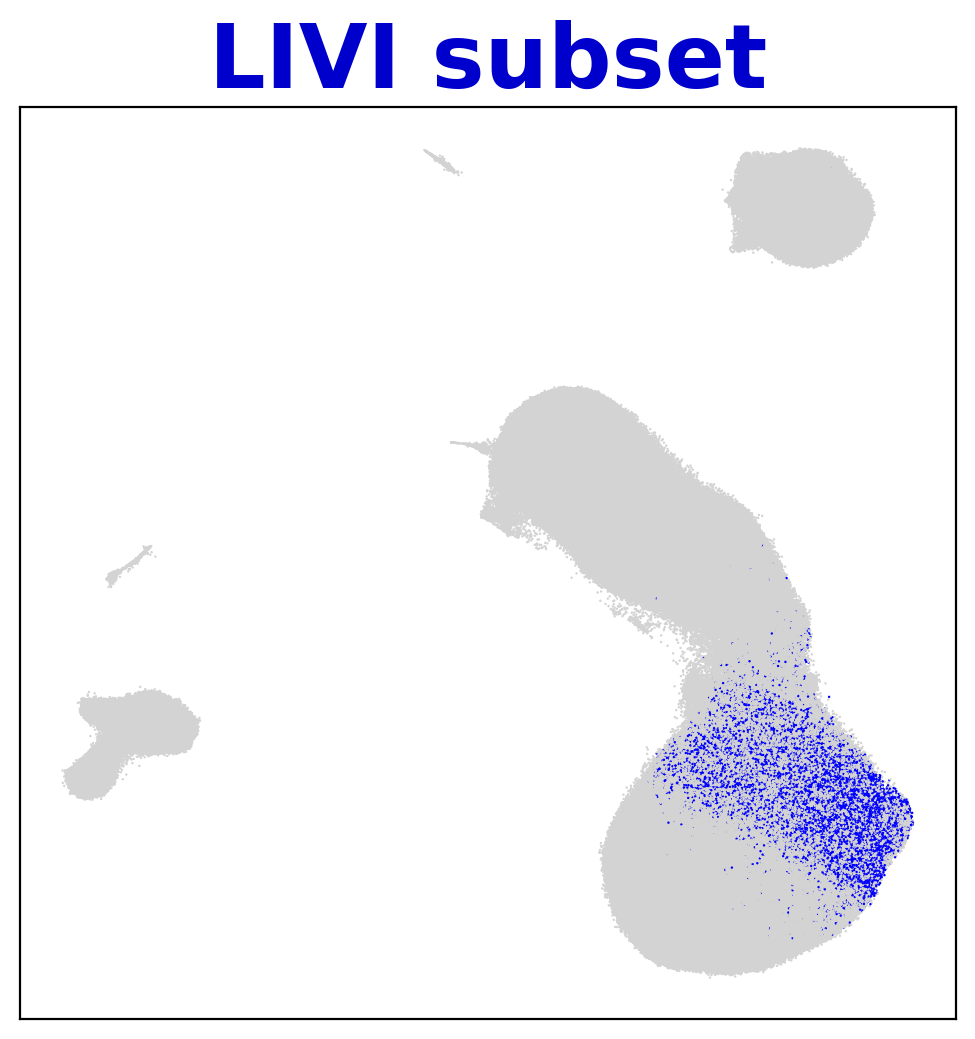

In [45]:
adata.obs = adata.obs.assign(cells2plot = [False]*adata.obs.shape[0])
adata.obs.loc[DxC_beta.loc[DxC_beta["DxC_Factor287"] > 0.05].index, "cells2plot"] = True

fig, axs = plt.subplots(figsize=(6,6))

sc.pl.umap(adata,
           color="cells2plot", 
           title="LIVI subset",
           size=3,
           palette=["lightgrey", "blue"],
           hspace=0.14,
           save=None,
           show=False,
           legend_loc="none",
           ax=axs)

axs.set_xlabel("")
axs.set_ylabel("")
axs.set_title(axs.get_title(), fontdict={"fontsize":32, "color":"mediumblue", "weight":"bold"})

plt.savefig(os.path.join(model_results_dir, "Figures", "UMAP-cell-state_highlighted_DxC287-005-cutoff-cells_blue_wo-axis-labels.pdf"), 
            dpi=600, bbox_inches="tight", transparent="True")
plt.savefig(os.path.join(model_results_dir, "Figures", "UMAP-cell-state_highlighted_DxC287-005-cutoff-cells_blue_wo-axis-labels.eps"), 
            dpi=600, bbox_inches="tight", transparent="True")
plt.savefig(os.path.join(model_results_dir, "Figures", "UMAP-cell-state_highlighted_DxC287-005-cutoff-cells_blue_wo-axis-labels.png"), 
            dpi=600, bbox_inches="tight", transparent="True")

In [58]:
tensorqtl_6_29789171_all = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/tensorqtl_results_all_6_29789171.tsv", sep="\t", index_col=False)
tensorqtl_6_29789171_all.head()

SNP_id             gene   p_value ref_allele alt_allele celltype  \
0  6:29789171  ENSG00000166987  0.269884          T          C   CD4-ET   
1  6:29789171  ENSG00000170624  0.698552          T          C   CD4-ET   
2  6:29789171  ENSG00000117115  0.397819          T          C   CD4-ET   
3  6:29789171  ENSG00000137078  0.359468          T          C   CD4-ET   
4  6:29789171  ENSG00000082213  0.150724          T          C   CD4-ET   

                                      eQTL  
0  6_29789171_T_C__ENSG00000166987__CD4-ET  
1  6_29789171_T_C__ENSG00000170624__CD4-ET  
2  6_29789171_T_C__ENSG00000117115__CD4-ET  
3  6_29789171_T_C__ENSG00000137078__CD4-ET  
4  6_29789171_T_C__ENSG00000082213__CD4-ET

In [65]:
tensorqtl_6_29789171_all.loc[(tensorqtl_6_29789171_all.celltype.isin(["CD4-ET", "CD4-NC"])) & (tensorqtl_6_29789171_all.gene == "ENSG00000111796")]

SNP_id             gene   p_value ref_allele alt_allele celltype  \
10122  6:29789171  ENSG00000111796  0.240739          T          C   CD4-ET   
35032  6:29789171  ENSG00000111796  0.023747          T          C   CD4-NC   

                                          eQTL  
10122  6_29789171_T_C__ENSG00000111796__CD4-ET  
35032  6_29789171_T_C__ENSG00000111796__CD4-NC

In [82]:
LIVI_cells = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/LIVI_cells_6-29789171_DxC287_005-cutoff_10PCs_10GT-PCs_trans-mapping_6-29789171-only.tsv", sep="\t", index_col=False)
LIVI_cells

SNP_id             gene   p_value   effect_size  effect_size_se  \
0      6:29789171  ENSG00000257019  0.398803 -1.682862e-14    1.993588e-14   
1      6:29789171  ENSG00000166987  0.405647 -9.000661e-02    1.081882e-01   
2      6:29789171  ENSG00000170624  0.355590  2.994410e-02    3.239836e-02   
3      6:29789171  ENSG00000140519  0.398803 -1.682862e-14    1.993588e-14   
4      6:29789171  ENSG00000117115  0.668710  2.186383e-02    5.107763e-02   
...           ...              ...       ...           ...             ...   
13993  6:29789171  ENSG00000185811  0.283766  4.819786e-02    4.493980e-02   
13994  6:29789171  ENSG00000234465  0.041392  2.407735e-01    1.178917e-01   
13995  6:29789171  ENSG00000170615  0.263167 -7.909882e-02    7.064953e-02   
13996  6:29789171  ENSG00000151778  0.972548  1.374393e-03    3.992812e-02   
13997  6:29789171  ENSG00000188993  0.613888 -1.736094e-02    3.439879e-02   

      ref_allele alt_allele  
0              T          C  
1              T          C  
2              T          C  
3              T          C  
4              T          C  
...          ...        ...  
13993          T          C  
13994          T          C  
13995          T          C  
13996          T          C  
13997          T          C  

[13998 rows x 7 columns]

In [83]:
LIVI_cells.loc[LIVI_cells.gene == "ENSG00000111796"]

SNP_id             gene   p_value  effect_size  effect_size_se  \
11381  6:29789171  ENSG00000111796  0.003468    -0.135271        0.046165   

      ref_allele alt_allele  
11381          T          C

In [245]:
LIVI_cells_sign = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/LIVI_cells_6-29789171_DxC287_005-cutoff_10PCs_10GT-PCs_trans-mapping_all-chroms_tensorQTL_significant_BH_005.tsv", sep="\t", index_col=False)
LIVI_cells_sign.loc[(LIVI_cells_sign.SNP_id == "6:29789171") & (LIVI_cells_sign.gene == "ENSG00000111796")]

Empty DataFrame
Columns: [SNP_id, gene, p_value, effect_size, effect_size_se, ref_allele, alt_allele, celltype, BH_corrected_pvalue]
Index: []

In [246]:
LIVI_cells_sign.loc[(LIVI_cells_sign.gene == "ENSG00000111796")]

Empty DataFrame
Columns: [SNP_id, gene, p_value, effect_size, effect_size_se, ref_allele, alt_allele, celltype, BH_corrected_pvalue]
Index: []

In [88]:
## Pseudobulk GEX
adata_aggr_CD4NC = aggregate_cell_counts(
    adata=adata[adata.obs.loc[adata.obs["cell_label"] == "CD4 NC"].index, "ENSG00000111796"],
    aggregate_cols=["individual"],
    layer=None,
    sum_gene=True,
)

adata_aggr_CD4ET = aggregate_cell_counts(
    adata=adata[adata.obs.loc[adata.obs["cell_label"] == "CD4 ET"].index, "ENSG00000111796"],
    aggregate_cols=["individual"],
    layer=None,
    sum_gene=True,
)

adata_aggr_LIVI = aggregate_cell_counts(
    adata=adata[DxC_beta.loc[DxC_beta["DxC_Factor287"] > 0.05].index, "ENSG00000111796"],
    aggregate_cols=["individual"],
    layer=None,
    sum_gene=True,
)


In [90]:
## Concatenate dfs

# CD4 NC
dfs = []
aggr_expr = pd.DataFrame(
    adata_aggr_CD4NC.X.astype(np.float32),
    index=adata_aggr_CD4NC.obs["individual"],
    columns=adata_aggr_CD4NC.var.index,
)

aggr_expr = aggr_expr.assign(celltype = ["CD4 NC"]*aggr_expr.shape[0])

plot_df = (
    aggr_expr.reset_index(drop=False)
    .merge(
        GT_matrix.loc[SNP_dict_inv["6:29789171"]].T.rename_axis("individual").reset_index(drop=False),
        on="individual",
        how="left",
    ).set_index("individual")
)

dfs.append(plot_df)


# CD4 ET
aggr_expr = pd.DataFrame(
    adata_aggr_CD4ET.X.astype(np.float32),
    index=adata_aggr_CD4ET.obs["individual"],
    columns=adata_aggr_CD4ET.var.index,
)
aggr_expr = aggr_expr.assign(celltype = ["CD4 ET"]*aggr_expr.shape[0])

plot_df = (
    aggr_expr.reset_index(drop=False)
    .merge(
        GT_matrix.loc[SNP_dict_inv["6:29789171"]].T.rename_axis("individual").reset_index(drop=False),
        on="individual",
        how="left",
    ).set_index("individual")
)
dfs.append(plot_df)

# LIVI cells
aggr_expr = pd.DataFrame(
    adata_aggr_LIVI.X.astype(np.float32),
    index=adata_aggr_LIVI.obs["individual"],
    columns=adata_aggr_LIVI.var.index,
)
aggr_expr = aggr_expr.assign(celltype = ["LIVI subset"]*aggr_expr.shape[0])

plot_df = (
    aggr_expr.reset_index(drop=False)
    .merge(
        GT_matrix.loc[SNP_dict_inv["6:29789171"]].T.rename_axis("individual").reset_index(drop=False),
        on="individual",
        how="left",
    ).set_index("individual")
)
dfs.append(plot_df)

dfs = pd.concat(dfs, axis=0, ignore_index=True)

alleles = re.search(
    re.compile(".*[0-9]+_([A-Z]+)_([A-Z]+)"), GT_matrix.loc[SNP_dict_inv["6:29789171"]].T.name
).groups()

if (alleles[0] == GxC_effects.loc[GxC_effects.SNP_id == SNP_dict_inv["6:29789171"]].assessed_allele).all():
    allele_dict = {
        0: "/".join([alleles[1], alleles[1]]),
        1: "/".join([alleles[0], alleles[1]]),
        2: "/".join([alleles[0], alleles[0]]),
    }
    dfs = dfs.replace({SNP_dict_inv["6:29789171"]: allele_dict})
    dfs[SNP_dict_inv["6:29789171"]] = pd.Categorical(
        dfs[SNP_dict_inv["6:29789171"]],
        categories=[
            "/".join([alleles[1], alleles[1]]),
            "/".join([alleles[0], alleles[1]]),
            "/".join([alleles[0], alleles[0]]),
        ],
    )
else:
    allele_dict = {
        0: "/".join([alleles[0], alleles[0]]),
        1: "/".join([alleles[0], alleles[1]]),
        2: "/".join([alleles[1], alleles[1]]),
    }
    dfs = dfs.replace({SNP_dict_inv["6:29789171"]: allele_dict})
    dfs[SNP_dict_inv["6:29789171"]] = pd.Categorical(
        dfs[SNP_dict_inv["6:29789171"]],
        categories=[
            "/".join([alleles[0], alleles[0]]),
            "/".join([alleles[0], alleles[1]]),
            "/".join([alleles[1], alleles[1]]),
        ],
    )


dfs

ENSG00000111796     celltype 6_29789171_T_C
0            0.098970       CD4 NC            T/C
1            0.105855       CD4 NC            T/C
2            0.088391       CD4 NC            T/T
3            0.088488       CD4 NC            T/C
4            0.109073       CD4 NC            C/C
...               ...          ...            ...
2938         0.509249  LIVI subset            T/C
2939         0.607700  LIVI subset            T/C
2940         0.528048  LIVI subset            T/T
2941         0.542537  LIVI subset            T/C
2942         0.797213  LIVI subset            T/T

[2943 rows x 3 columns]

In [99]:
gt_group_median = (
    dfs.filter(["ENSG00000111796", SNP_dict_inv["6:29789171"], "celltype"]).groupby(by=[SNP_dict_inv["6:29789171"], "celltype"], observed=True)["ENSG00000111796"].median()
)
gt_group_median

6_29789171_T_C  celltype   
C/C             CD4 ET         1.239074
                CD4 NC         0.103641
                LIVI subset    0.382641
T/C             CD4 ET         1.285084
                CD4 NC         0.104874
                LIVI subset    0.440461
T/T             CD4 ET         1.286089
                CD4 NC         0.106889
                LIVI subset    0.450364
Name: ENSG00000111796, dtype: float32

In [100]:
gt_group_median = gt_group_median.unstack(SNP_dict_inv["6:29789171"]).reindex(index=["CD4 NC", "CD4 ET", "LIVI subset"], columns=list(allele_dict.values()))
gt_group_median

6_29789171_T_C       C/C       T/C       T/T
celltype                                    
CD4 NC          0.103641  0.104874  0.106889
CD4 ET          1.239074  1.285084  1.286089
LIVI subset     0.382641  0.440461  0.450364

In [101]:
simple_violin_colors = ["lightgrey", "darkgrey", "grey"]
violin_colors_dict = dict(zip(list(allele_dict.values()), simple_violin_colors))
violin_colors_dict

{'C/C': 'lightgrey', 'T/C': 'darkgrey', 'T/T': 'grey'}

In [161]:
pvals_dict = tensorqtl_6_29789171_all.loc[(tensorqtl_6_29789171_all.celltype.isin(["CD4-ET", "CD4-NC"])) & (tensorqtl_6_29789171_all.gene == "ENSG00000111796")].filter(["celltype", "p_value"])
pvals_dict.celltype = pvals_dict.celltype.str.replace("-", " ")
pvals_dict = pvals_dict.set_index("celltype")["p_value"].to_dict()
pvals_dict

{'CD4 ET': 0.24073909, 'CD4 NC': 0.023746716}

In [162]:
pvals_dict["LIVI subset"] = LIVI_cells.loc[LIVI_cells.gene == "ENSG00000111796"].p_value.iloc[0]
pvals_dict

{'CD4 ET': 0.24073909,
 'CD4 NC': 0.023746716,
 'LIVI subset': 0.0034681061394897}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


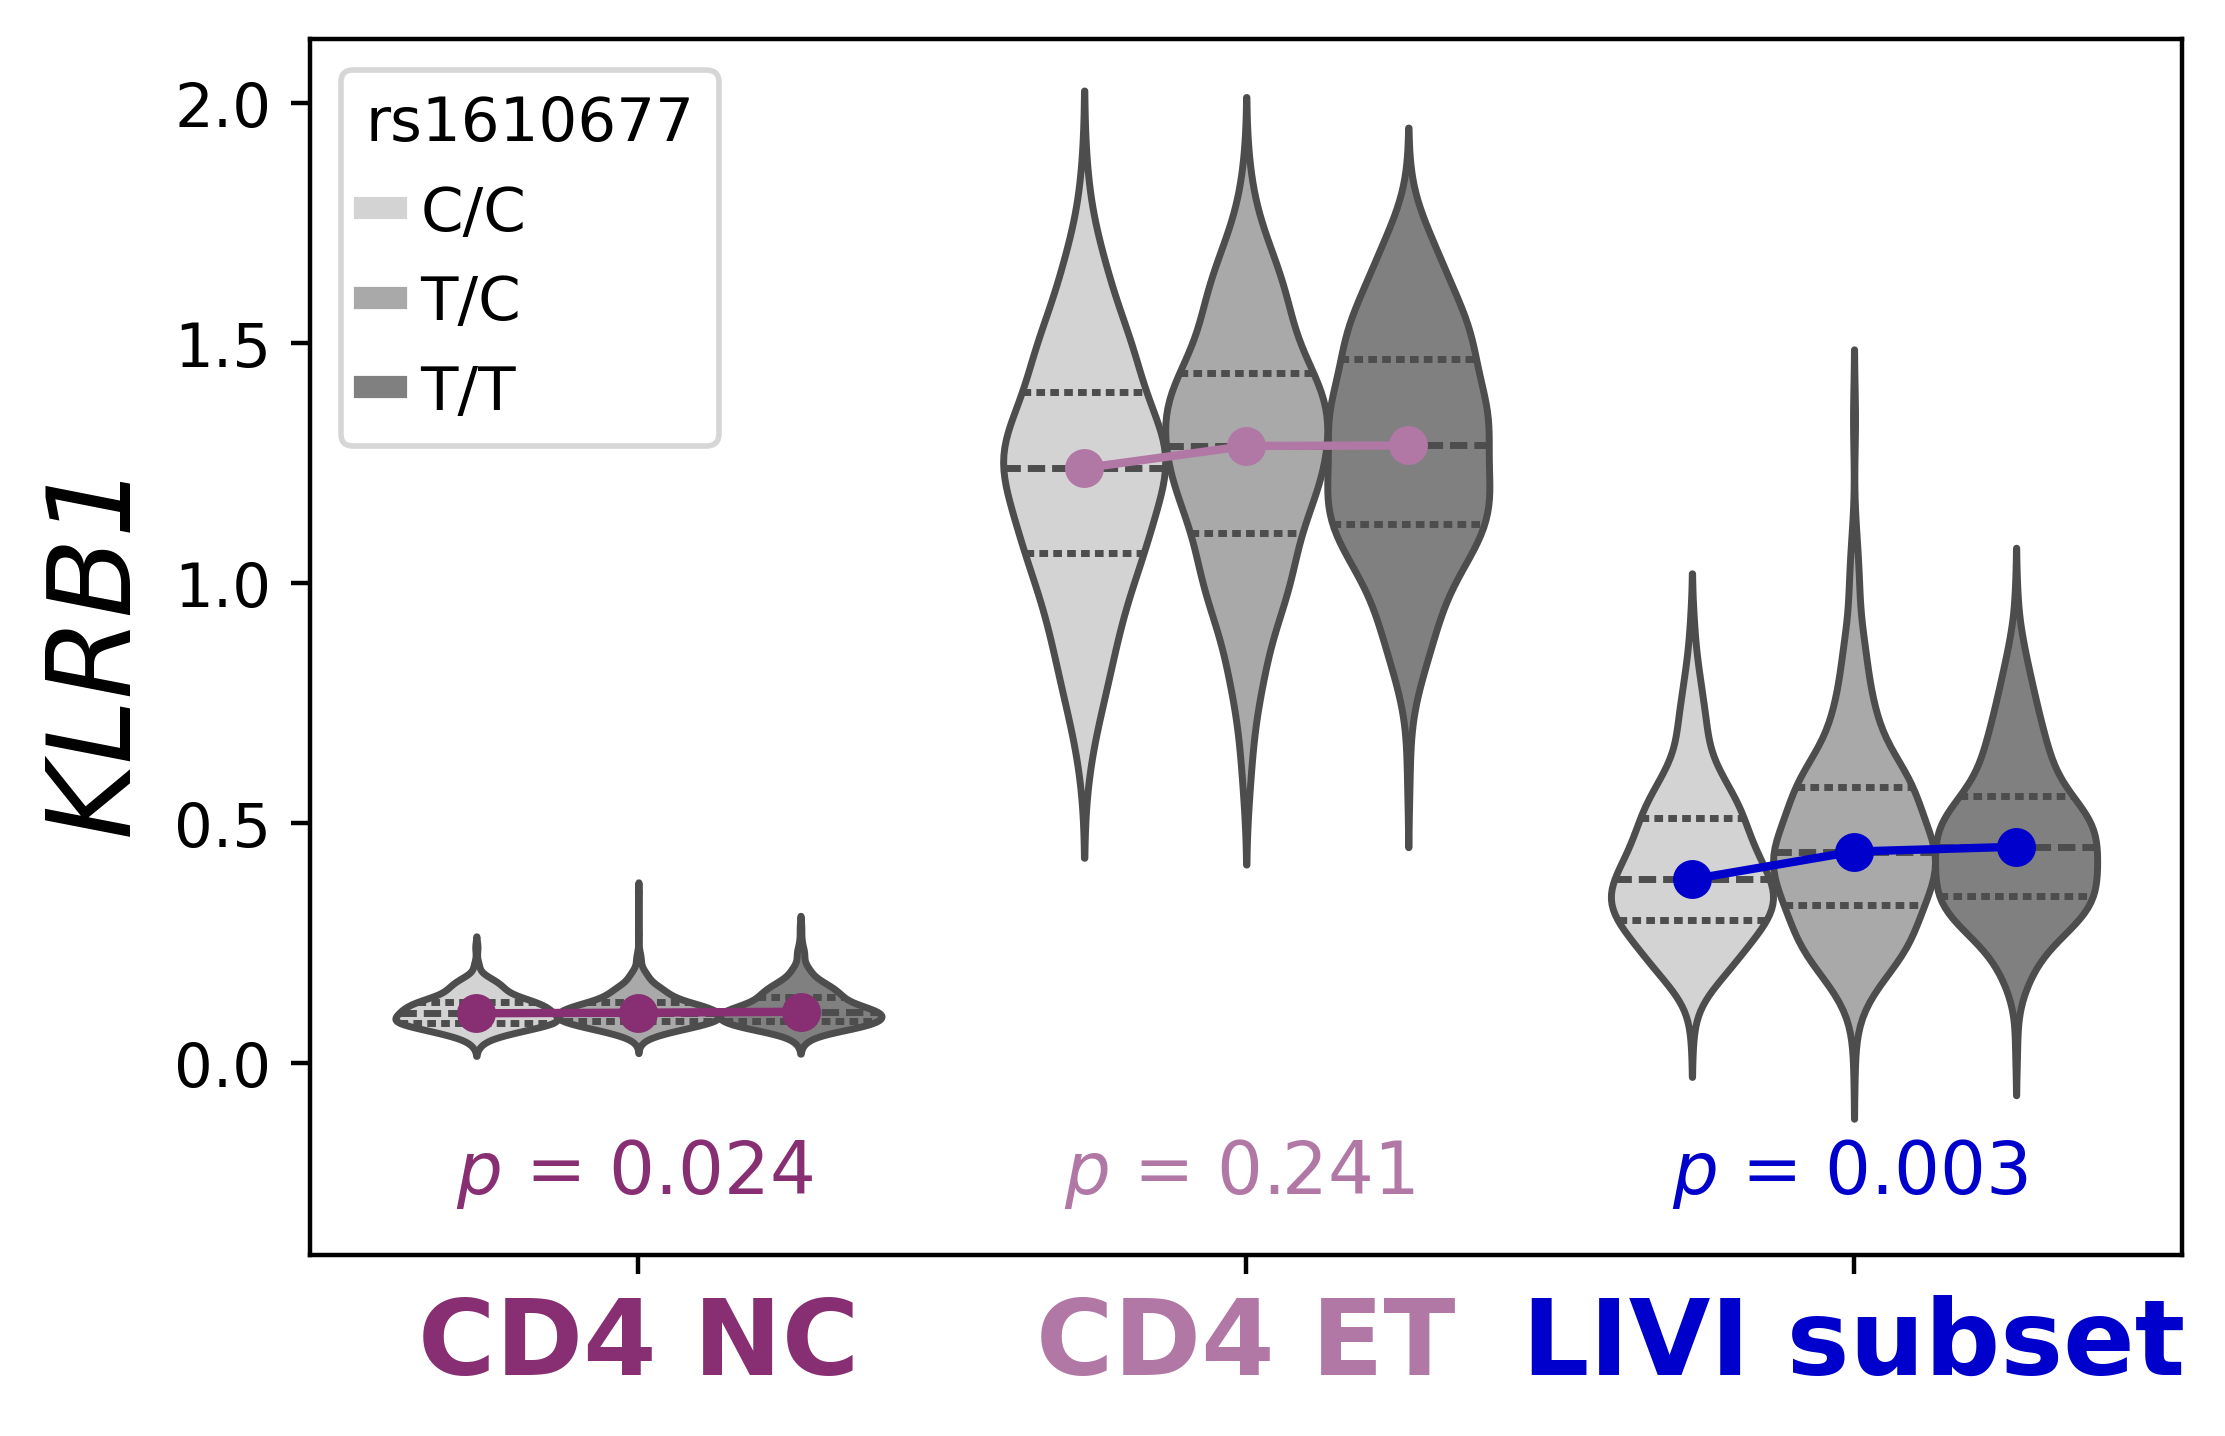

In [181]:
annotation_fontsize = 19

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), constrained_layout=False)
sns.violinplot(
    dfs,
    y="ENSG00000111796",
    x="celltype",
    hue=SNP_dict_inv["6:29789171"],
    palette=simple_violin_colors,
    ax=axs,
    legend=False,
    split=False,
    order=["CD4 NC", "CD4 ET", "LIVI subset"],
    hue_order=list(allele_dict.values()),   
    inner="quart",
    native_scale=True,
    density_norm = "count", # "width",
    common_norm=False,
    rasterized=True,
)
axs.set_ylabel(
    "KLRB1", fontdict={"fontsize": annotation_fontsize + 2, "fontstyle": "italic"}
)

for label in axs.get_xticklabels():
    if label.get_text() in cell_label_colors.keys():
        label.set_color(cell_label_colors[label.get_text()])
    else:
        label.set_color("mediumblue")
    label.set_fontweight("bold")
    label.set_fontsize(annotation_fontsize)
axs.xaxis.set_label_text("")
[t.set_fontsize(annotation_fontsize - 8) for t in axs.yaxis.get_ticklabels()]


def gt_pos(x_index, hue_index, width=0.8, k=3):
    # center of group is at integer x_index; distribute hue positions within width
    return x_index + (hue_index - (k - 1) / 2) * (width / k)

for j, ct in enumerate(["CD4 NC", "CD4 ET", "LIVI subset"]):
    medians = gt_group_median.loc[ct].values
    xs = [gt_pos(j, i) for i in range(3)]
    if ct in cell_label_colors.keys():
        axs.plot(xs, medians, marker="o", linestyle="-", color=cell_label_colors[ct], zorder=10)
    else:
        axs.plot(xs, medians, marker="o", linestyle="-", color="mediumblue", zorder=10)
    axs.text(x=xs[1]-0.3, y=-0.27, s=f"$p$ = {np.round(pvals_dict[ct], 3)}", 
             fontdict={"fontsize":annotation_fontsize-6, "color": cell_label_colors[ct] if ct in cell_label_colors.keys() else "mediumblue"})


legend_handles = []
for gt, gt_color in violin_colors_dict.items():
    legend_handles.append(
        Line2D([], [], color=gt_color, linewidth=4, label=gt)
    )

# axs.legend(handles=legend_handles, fontsize=annotation_fontsize-8, alignment="left", loc="upper center", frameon=False, 
# ncol=3, bbox_to_anchor=(0.5, 1.02))

axs.legend(handles=legend_handles, title=f"{rsid}", title_fontsize=annotation_fontsize-8, fontsize=annotation_fontsize-8,
           alignment="left", loc="upper left", frameon=True)

axs.set_ylim(-0.4, max(axs.get_ylim()))

plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171_CD4-NC_CD4-ET_LIVI-cells.png"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171_CD4-NC_CD4-ET_LIVI-cells.pdf"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171_CD4-NC_CD4-ET_LIVI-cells.eps"),
            bbox_inches="tight", dpi=500, transparent=True)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


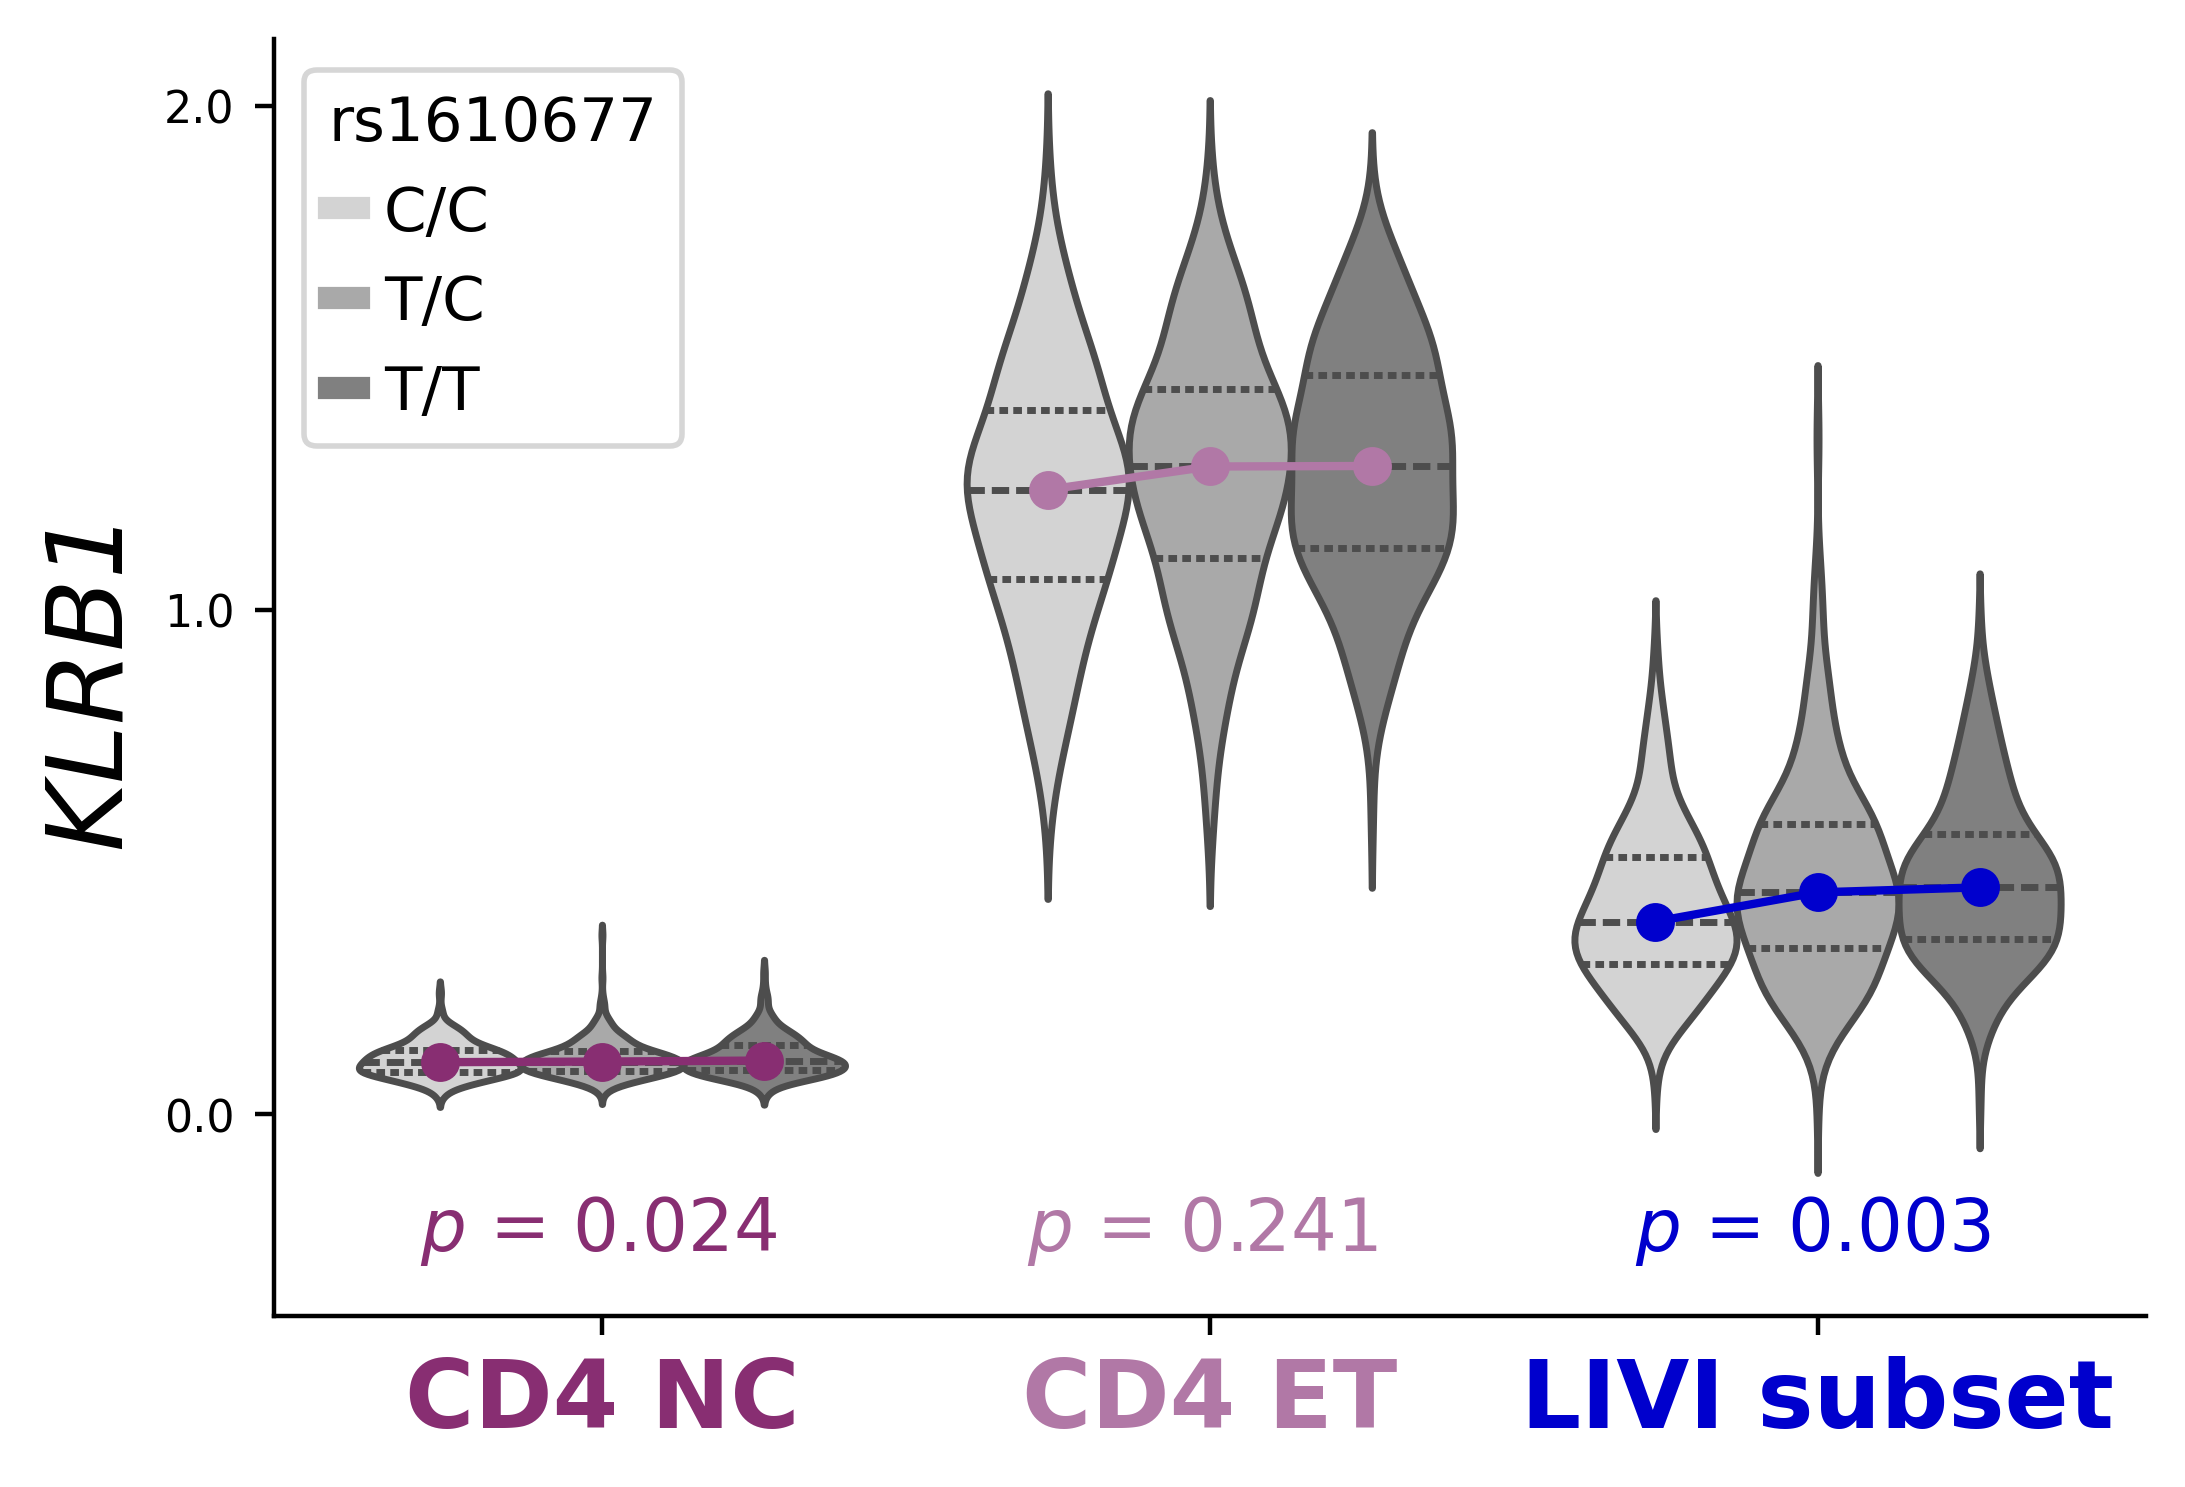

In [216]:
annotation_fontsize = 17

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(6, 4.2), constrained_layout=False)
sns.violinplot(
    dfs,
    y="ENSG00000111796",
    x="celltype",
    hue=SNP_dict_inv["6:29789171"],
    palette=simple_violin_colors,
    ax=axs,
    legend=False,
    split=False,
    order=["CD4 NC", "CD4 ET", "LIVI subset"],
    hue_order=list(allele_dict.values()),   
    inner="quart",
    native_scale=True,
    density_norm = "count", # "width",
    common_norm=False,
    rasterized=True,
)
axs.set_ylabel(
    "KLRB1", fontdict={"fontsize": annotation_fontsize + 2, "fontstyle": "italic"}
)

for label in axs.get_xticklabels():
    if label.get_text() in cell_label_colors.keys():
        label.set_color(cell_label_colors[label.get_text()])
    else:
        label.set_color("mediumblue")
    label.set_fontweight("bold")
    label.set_fontsize(annotation_fontsize)
axs.xaxis.set_label_text("")
[t.set_fontsize(annotation_fontsize - 9) for t in axs.yaxis.get_ticklabels()]


def gt_pos(x_index, hue_index, width=0.8, k=3):
    # center of group is at integer x_index; distribute hue positions within width
    return x_index + (hue_index - (k - 1) / 2) * (width / k)

for j, ct in enumerate(["CD4 NC", "CD4 ET", "LIVI subset"]):
    medians = gt_group_median.loc[ct].values
    xs = [gt_pos(j, i) for i in range(3)]
    if ct in cell_label_colors.keys():
        axs.plot(xs, medians, marker="o", linestyle="-", color=cell_label_colors[ct], zorder=10)
    else:
        axs.plot(xs, medians, marker="o", linestyle="-", color="mediumblue", zorder=10)
    axs.text(x=xs[1]-0.3, y=-0.27, s=f"$p$ = {np.round(pvals_dict[ct], 3)}", fontdict={"fontsize":annotation_fontsize-4, "color": cell_label_colors[ct] if ct in cell_label_colors.keys() else "mediumblue"})


legend_handles = []
for gt, gt_color in violin_colors_dict.items():
    legend_handles.append(
        Line2D([], [], color=gt_color, linewidth=4, label=gt)
    )

# axs.legend(handles=legend_handles, fontsize=annotation_fontsize-8, alignment="left", loc="upper center", frameon=False,  ncol=3, bbox_to_anchor=(0.5, 1.02))

axs.legend(handles=legend_handles, title=f"{rsid}", title_fontsize=annotation_fontsize-6, fontsize=annotation_fontsize-6, alignment="left", loc="upper left", frameon=True)

axs.set_ylim(-0.4, max(axs.get_ylim()))
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)
axs.set_yticks(np.arange(0, 3, 1, dtype=float), np.arange(0, 3, 1, dtype=float), fontdict={"fontsize":annotation_fontsize - 9})


plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171_CD4-NC_CD4-ET_LIVI-cells_smaller-fontsize_wo-spines.png"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171_CD4-NC_CD4-ET_LIVI-cells_smaller-fontsize_wo-spines.pdf"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC287_6-29789171_CD4-NC_CD4-ET_LIVI-cells_smaller-fontsize_wo-spines.eps"),
            bbox_inches="tight", dpi=500, transparent=True)
